# EDA
This notebook explore our data, mainly counting label distribution because the input features are hard to visualize.

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from preprocess import get_records, read_records
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:

# train, test, val directory
train_dir  = "/Users/shufanxia/Documents/frame-level/"  
val_dir = "/Users/shufanxia/Documents/validate-frame/"
test_dir = "/Users/shufanxia/Documents/test-frame/"

# get and read records
frames_train = get_records(train_dir,"train")[:2]
frames_val = get_records(val_dir,"validate")[:2]
frames_test = get_records(test_dir,"validate")[:2] # it's called validate in the test_dir

feat_rgb,feat_audio,feat_pseudoid,feat_labels = read_records(frames_train)
feat_rgb_val,feat_audio_val,feat_pseudoid_val,feat_labels_val = read_records(frames_val)
feat_rgb_test,feat_audio_test,feat_pseudoid_test,feat_labels_test = read_records(frames_test)

2022-04-15 11:03:49.474957: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


make dataframe from train+val and test data for EDA

In [5]:
feat_labels_all = feat_labels + feat_labels_val
feat_id_all = feat_pseudoid + feat_pseudoid_val
feat_rgb_all = feat_rgb+ feat_rgb_val

# count number of frames and labels per video
n_frames = list(map(len,feat_rgb_all))
n_labels = list(map(len,feat_labels_all))
n_frames_test = list(map(len,feat_rgb_test))
n_labels_test = list(map(len,feat_labels_test))

df = pd.DataFrame({"pseudo_id":feat_id_all,
                    "labels":feat_labels_all,
                    "n_frames":n_frames,
                    "n_labels":n_labels})
print("Total numbers of videos in train+val:", len(df))

df.to_csv("eda_results/video_id_label.csv",index=False)

df_test = pd.DataFrame({"pseudo_id":feat_pseudoid_test,
                    "labels":feat_labels_test,
                    "n_frames":n_frames_test,
                    "n_labels":n_labels_test})
print("Total numbers of videos:", len(df_test))

Total numbers of videos in train+val: 2678
Total numbers of videos: 612


find train/val/test split

In [6]:
print(len(feat_labels)/(len(feat_labels_all)+len(feat_labels_test)))
print(len(feat_labels_val)/(len(feat_labels_all)+len(feat_labels_test)))
print(len(feat_labels_all)/(len(feat_labels_all)+len(feat_labels_test)))

0.6212765957446809
0.19270516717325228
0.8139817629179331


### histogram of n_frames and n_labels

/var/folders/f2/d1mj0jcx0_g5cf_sw9qfpnwc0000gn/T/ipykernel_32095/4164946160.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/f2/d1mj0jcx0_g5cf_sw9qfpnwc0000gn/T/ipykernel_32095/4164946160.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


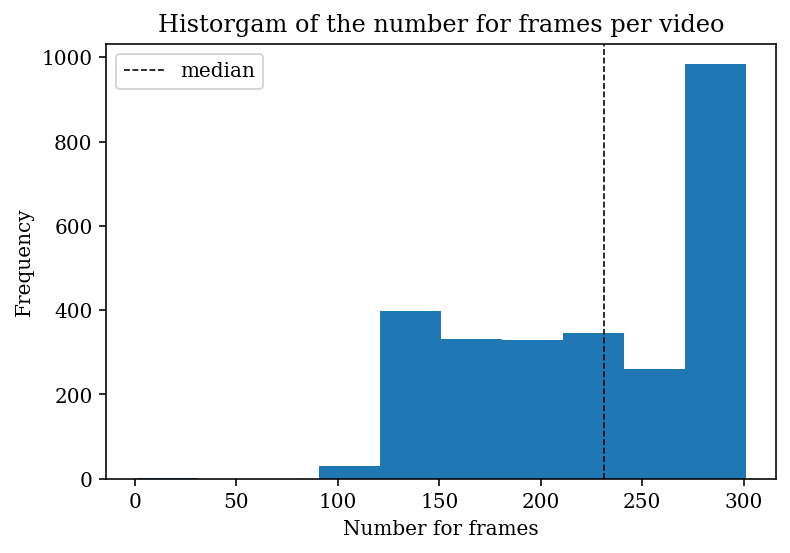

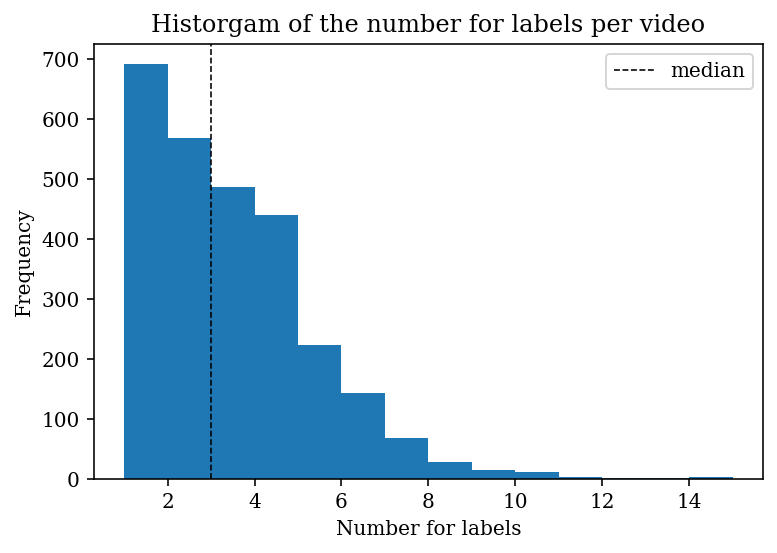

In [7]:
# plot number fo frames and number of labels per video
fig,ax = plt.subplots()
ax.hist(df.n_frames)
ax.axvline(x=df.n_frames.median(),color='k', lw=0.8, ls='--',label="median")
ax.legend()
ax.set_xlabel("Number for frames")
ax.set_ylabel("Frequency")
ax.set_title("Historgam of the number for frames per video")
fig.show()

fig,ax = plt.subplots()
ax.hist(df.n_labels,bins=np.arange(1,df.n_labels.max()+1,1))
ax.axvline(x=df.n_labels.median(),color='k', lw=0.8, ls='--',label="median")
ax.legend()
ax.set_xlabel("Number for labels")
ax.set_ylabel("Frequency")
ax.set_title("Historgam of the number for labels per video")
plt.savefig("plots/nLabelperVid.png")
fig.show()

### bar plot of label frequency in train+val compared to test data

In [8]:
# define the dictionary to map label index to actual words
label_dict = pd.read_csv("vocabulary.csv")
label_map = dict(zip(label_dict.Index, label_dict.Name))

In [33]:
def prepare_hist(df,topN ):
    # this function count how many times each label is used 
    # preapre a dataframe to plot historgram
    all_labels_merge = np.concatenate(df.labels.values)
    counter = np.bincount(all_labels_merge)
    labels = np.arange(0,np.max(all_labels_merge)+1,1)
    label_count = np.array([counter[i]for i in labels])

    # sort label by their count from top to bottom
    top_labels = labels[np.argsort(label_count)[::-1]]
    label_count_sorted = np.sort(label_count)[::-1]
    topN_labels = top_labels[:topN]
    # use label dictionary to get names
    topN_labelnames = list(map(label_map.get,topN_labels))
    topN_labelnames = [ (str(topN_labels[i])+": "+topN_labelnames[i])for i in range(topN)]
    # make dataframe 
    label_count_df = pd.DataFrame({"label":topN_labelnames,"counts":label_count_sorted[:topN]})
    label_count_df['percent_video'] = label_count_df.counts.div(len(feat_labels_all))
    # add percentage, this means the accurcay of random guess based on label proportion

    return label_count_df

3852
3826


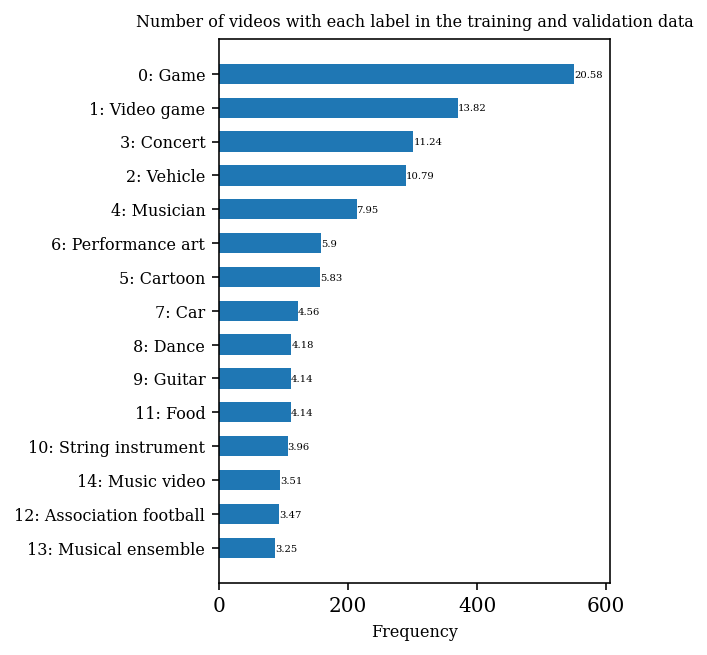

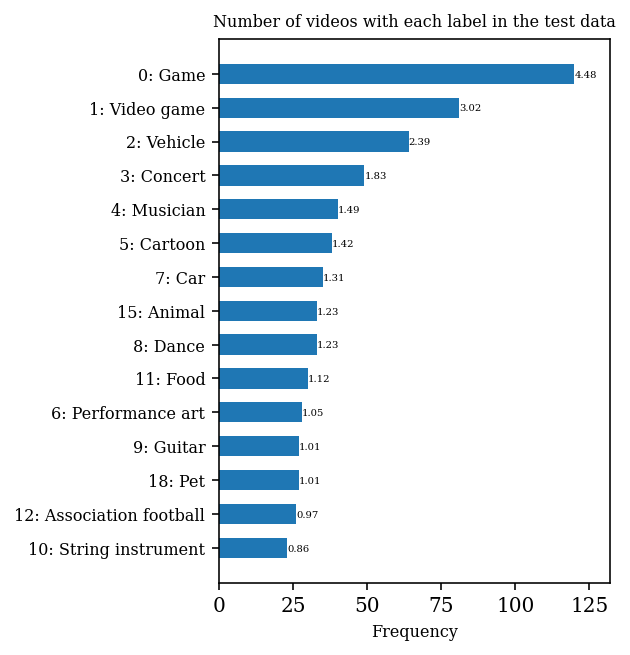

In [17]:

topN = 15
# user helper function to count label frequency in each dataset
count_df = prepare_hist(df,15)
count_df_test = prepare_hist(df_test,15)

# bar plot on frequency 
fig = plt.figure(figsize=(3.5,5))
x =  -1*np.arange(0,topN,1)
barplot = plt.barh(x,count_df.counts,height=0.6)
# annotate each label with percentage
for i in range(topN):
    plt.annotate(round(count_df.percent_video[i]*100,2),(count_df.counts[i],x[i]-0.1),fontsize=5)
plt.yticks(x,count_df.label,fontsize=8)#,rotation=90)
plt.xlabel("Frequency",fontsize=8)
plt.xlim(0,np.max(count_df.counts)*1.1)
plt.title("Number of videos with each label in the training and validation data",fontsize=8)
plt.savefig("plots/label_hist.pdf",bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(3.5,5))
x =  -1*np.arange(0,topN,1)
barplot = plt.barh(x,count_df_test.counts,height=0.6)
# annotate each label with percentage
for i in range(topN):
    plt.annotate(round(count_df_test.percent_video[i]*100,2),(count_df_test.counts[i],x[i]-0.1),fontsize=5)
plt.yticks(x,count_df_test.label,fontsize=8)#,rotation=90)
plt.xlabel("Frequency",fontsize=8)
plt.xlim(0,np.max(count_df_test.counts)*1.1)
plt.title("Number of videos with each label in the test data",fontsize=8)
plt.savefig("plots/label_hist_test.pdf",bbox_inches = 'tight')
plt.show()


find pairs of label that appear together frequently in popular videos

In [23]:
from itertools import combinations,chain
from collections import Counter
# initializing list
  
# All possible pairs in List
# # Using combinations()
def find_top_pairs(df_i,col):
    pairs = [list(combinations(df_i[col][i], 2)) for i in range(len(df_i))]
    combined = list(chain.from_iterable(pairs))
    df_i["pairs"]=pairs
    unique_pairs = set(combined)
    counter_object = Counter(combined)
    keys = list(counter_object.keys())
    count=list(counter_object.values())
    top_pairs = [keys[i] for i in np.argsort(count)[::-1][:100]]
    top_pairs_names=[]
    for pair in top_pairs:
        top_pairs_names.append((label_map[pair[0]],label_map[pair[1]]))
    return(top_pairs_names)

In [26]:
# find pairs of label that appears together frequently top 50
top_pairs_names_audio_true= find_top_pairs(df,"labels")
" ".join(list(map(str,top_pairs_names_audio_true[:50])))

"('Game', 'Video game') ('Concert', 'Musician') ('Vehicle', 'Car') ('Concert', 'Performance art') ('Musician', 'Guitar') ('Musician', 'String instrument') ('Guitar', 'String instrument') ('Musician', 'Musical ensemble') ('Game', 'Association football') ('Food', 'Recipe') ('Concert', 'Musical ensemble') ('Food', 'Cooking') ('Game', 'Cartoon') ('Recipe', 'Cooking') ('Musician', 'Performance art') ('Mobile phone', 'Smartphone') ('Video game', 'Cartoon') ('Vehicle', 'Motorcycle') ('Food', 'Dish (food)') ('Food', 'Cuisine') ('Animal', 'Pet') ('Performance art', 'Dance') ('Mobile phone', 'Gadget') ('Recipe', 'Dish (food)') ('Smartphone', 'Gadget') ('Recipe', 'Cuisine') ('Vehicle', 'Motorsport') ('Cooking', 'Dish (food)') ('Cooking', 'Cuisine') ('Cartoon', 'Animation') ('Cuisine', 'Dish (food)') ('Motorsport', 'Racing') ('Video game', 'Action-adventure game') ('Guitar', 'Electric guitar') ('Concert', 'String instrument') ('Guitar', 'Acoustic guitar') ('Game', 'Minecraft') ('Drum kit', 'Drum')

#### Looking at other information (video category, view counts) of the videos in the train+validation set

In [56]:
from get_metadata import get_video_metadata

metadata_df = list(map(get_video_metadata,df.pseudo_id.values))

col_names = ["pseudo_id","real_id",
    "title","categories",
    "tags","description",
    "is_live","view_count",
    "like_count","channel_url",
    "duration","average_rating",
    "age_limit","webpage_url",
]
metadata_df = pd.DataFrame(metadata_df, columns=col_names)


metadata_df.to_pickle("data/video_metadata.pkl")

[youtube] CXg4IMG3e7k: Downloading webpage
[youtube] koPinjfqp9w: Downloading webpage
[youtube] koPinjfqp9w: Downloading MPD manifest
[youtube] tLxlqIXkc7A: Downloading webpage
[youtube] tLxlqIXkc7A: Downloading MPD manifest
[youtube] aHEH_eDsBXo: Downloading webpage
[youtube] n2DkgwnNLCQ: Downloading webpage
[youtube] 2H9qQ3_qUTE: Downloading webpage
[youtube] Rg9Lmjm1B0c: Downloading webpage
[youtube] Rg9Lmjm1B0c: Downloading MPD manifest
[youtube] X_h8yl9mWAc: Downloading webpage
[youtube] jQHgxMOE29k: Downloading webpage
[youtube] Y6I9xzM1ilc: Downloading webpage
[youtube] Y6I9xzM1ilc: Downloading MPD manifest
[youtube] 4v1mynBg0RE: Downloading webpage
[youtube] zv5sQtq0uAw: Downloading webpage
[youtube] zv5sQtq0uAw: Downloading MPD manifest
[youtube] kdo816yKdQE: Downloading webpage
[youtube] zhLEglYtdpA: Downloading webpage
[youtube] C0aK4p0pyYY: Downloading webpage
[youtube] C0aK4p0pyYY: Downloading MPD manifest
[youtube] n0rlGsVS3fw: Downloading webpage
[youtube] OzjobawxPE4: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] npvLW7kDwsY: Downloading webpage
[youtube] npvLW7kDwsY: Downloading MPD manifest
[youtube] iLHyrbVDiDs: Downloading webpage
[youtube] c_CPEH59vTk: Downloading webpage
[youtube] fBAvU0VZzlw: Downloading webpage
[youtube] 7FKh7HWCw5k: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] _iERIt27imc: Downloading webpage
[youtube] iGi1CAmqaTw: Downloading webpage
[youtube] oe9kevdi9rc: Downloading webpage
[youtube] oe9kevdi9rc: Downloading MPD manifest
[youtube] Aey1jngMVgk: Downloading webpage
[youtube] G3bbi8Oubi0: Downloading webpage
[youtube] G3bbi8Oubi0: Downloading MPD manifest
[youtube] PG1z6QxZgE8: Downloading webpage
[youtube] PG1z6QxZgE8: Downloading MPD manifest
[youtube] _KL-iK4HjYY: Downloading webpage
[youtube] _KL-iK4HjYY: Downloading MPD manifest
[youtube] pr9Dg3nxcLY: Downloading webpage
[youtube] 9h8yqOJRYSc: Downloading webpage
[youtube] gGlQqNgfnlc: Downloading webpage
[youtube] gGlQqNgfnlc: Downloading MPD manifest
[youtube] I58H1enCMQM: Downloading webpage
[youtube] mG76AhmGbuA: Downloading webpage
[youtube] mG76AhmGbuA: Downloading MPD manifest
[youtube] L1ebFBejGdc: Downloading webpage
[youtube] TmTqH654U0I: Downloading webpage
[youtube] TmTqH654U0I: Downloading MPD manifest
[youtube] -t7LcLqleb0: Downloading webpage
[youtube] HgdjM8Isb

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] QuCXX8Y47Kg: Downloading webpage
[youtube] QuCXX8Y47Kg: Downloading MPD manifest
[youtube] qNZkwUP9ivc: Downloading webpage
[youtube] bPIrzxDhm9c: Downloading webpage
[youtube] C0Nt1Ljj_oo: Downloading webpage
[youtube] C0Nt1Ljj_oo: Downloading MPD manifest
[youtube] 7MQCDk8wlbg: Downloading webpage
[youtube] S0wGFLuFPZU: Downloading webpage
[youtube] -7_u703YfXM: Downloading webpage
[youtube] JkDXMi8KIhc: Downloading webpage
[youtube] NeeR46mYowc: Downloading webpage
[youtube] 4MGtgn9WXYM: Downloading webpage
[youtube] pmKLkYA1OzA: Downloading webpage
[youtube] pmKLkYA1OzA: Downloading MPD manifest
[youtube] _02-DE4Q3dE: Downloading webpage
[youtube] _02-DE4Q3dE: Downloading MPD manifest
[youtube] m4St3tBjVic: Downloading webpage
[youtube] m4St3tBjVic: Refetching age-gated info webpage


ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] uTtrdi4aDw4: Downloading webpage
[youtube] 8odVcOm7eGE: Downloading webpage
[youtube] 8odVcOm7eGE: Downloading MPD manifest
[youtube] NFKI6ZZXjZM: Downloading webpage
[youtube] NFKI6ZZXjZM: Downloading MPD manifest
[youtube] oietf0XwzTc: Downloading webpage
[youtube] oietf0XwzTc: Downloading MPD manifest
[youtube] vCPF74FqqTA: Downloading webpage
[youtube] vCPF74FqqTA: Downloading MPD manifest
[youtube] qO3zsou9v7A: Downloading webpage
[youtube] qO3zsou9v7A: Downloading MPD manifest
[youtube] zB8MYuxVY8M: Downloading webpage
[youtube] dhJHmvfsqdM: Downloading webpage
[youtube] dhJHmvfsqdM: Downloading MPD manifest
[youtube] o1zUwJ2naw8: Downloading webpage
[youtube] l2jig1BXPPY: Downloading webpage
[youtube] DABZJ1d64L8: Downloading webpage
[youtube] DABZJ1d64L8: Downloading MPD manifest
[youtube] 0D3xNM_Yb1s: Downloading webpage
[youtube] J3xHKZUaG2E: Downloading webpage
[youtube] J3xHKZUaG2E: Downloading MPD manifest
[youtube] IwtOde8roPE: Downloading webpage
[youtube] IwtO

ERROR: Video unavailable


[youtube] TAx7juE6AZk: Downloading webpage
[youtube] d4S7eAFSlwE: Downloading webpage
[youtube] d4S7eAFSlwE: Downloading MPD manifest
[youtube] V-T_TpGgZ14: Downloading webpage
[youtube] V-T_TpGgZ14: Downloading MPD manifest
[youtube] Cmjem5ZXPBQ: Downloading webpage
[youtube] Cmjem5ZXPBQ: Downloading MPD manifest
[youtube] wA9dtjkMM0o: Downloading webpage
[youtube] UD24nYasceY: Downloading webpage
[youtube] y438pGd9_wE: Downloading webpage
[youtube] HEz6eirJuFY: Downloading webpage
[youtube] VJ4kI4VCpgQ: Downloading webpage
[youtube] VJ4kI4VCpgQ: Downloading MPD manifest
[youtube] 3qO6rojm23I: Downloading webpage
[youtube] 3qO6rojm23I: Downloading MPD manifest
[youtube] YYV3Z8pftFY: Downloading webpage
[youtube] YYV3Z8pftFY: Downloading MPD manifest
[youtube] J1mzFZ0JSVo: Downloading webpage
[youtube] NBWOOOlOoRw: Downloading webpage
[youtube] tDOQjmNNHoc: Downloading webpage
[youtube] BhUiPC_nkxA: Downloading webpage
[youtube] 5RHJbJS1sNY: Downloading webpage
[youtube] 5RHJbJS1sNY: D

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] 0Wh2piAacYo: Downloading webpage
[youtube] 0Wh2piAacYo: Downloading MPD manifest
[youtube] Po7qQ8FpuwA: Downloading webpage
[youtube] Po7qQ8FpuwA: Downloading MPD manifest
[youtube] BObsWRGSuNY: Downloading webpage
[youtube] BObsWRGSuNY: Downloading MPD manifest
[youtube] Y3mkz3LBIiM: Downloading webpage
[youtube] Y3mkz3LBIiM: Downloading MPD manifest
[youtube] sIW3XrDfkDM: Downloading webpage
[youtube] TJsKXe2R3GY: Downloading webpage
[youtube] JLd3BBndOxU: Downloading webpage
[youtube] sfndhoCtOHQ: Downloading webpage
[youtube] jWu0nZdTha0: Downloading webpage
[youtube] jWu0nZdTha0: Downloading MPD manifest
[youtube] ZH_8EDQk0pc: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service


[youtube] ULXU3_srTrc: Downloading webpage
[youtube] ULXU3_srTrc: Downloading MPD manifest
[youtube] l_wr5yYrgCo: Downloading webpage
[youtube] KSTZlot-8o0: Downloading webpage
[youtube] rmLzFtXFkzo: Downloading webpage
[youtube] rmLzFtXFkzo: Downloading MPD manifest
[youtube] --neeVlebE4: Downloading webpage
[youtube] --neeVlebE4: Downloading MPD manifest
[youtube] _5Q3EB_ZLAU: Downloading webpage
[youtube] _5Q3EB_ZLAU: Downloading MPD manifest
[youtube] G1uUcFPHftM: Downloading webpage
[youtube] 50aAGxJ83JM: Downloading webpage
[youtube] wH6rWtc_WNs: Downloading webpage
[youtube] wH6rWtc_WNs: Downloading MPD manifest
[youtube] nQYR4aLRmqY: Downloading webpage


ERROR: Video unavailable


[youtube] 3gq8FdCu8Mo: Downloading webpage
[youtube] nRHBaaZN7uI: Downloading webpage
[youtube] YMUqlB5Zu4c: Downloading webpage
[youtube] YMUqlB5Zu4c: Downloading MPD manifest
[youtube] KFpAy-TIVeE: Downloading webpage
[youtube] KFpAy-TIVeE: Downloading MPD manifest
[youtube] 9nESP6J7iYA: Downloading webpage
[youtube] 9nESP6J7iYA: Downloading MPD manifest
[youtube] WwrVsc4XLpg: Downloading webpage
[youtube] WwrVsc4XLpg: Downloading MPD manifest
[youtube] PAS11Bcwv28: Downloading webpage
[youtube] 2iAdnT-yx1Y: Downloading webpage
[youtube] 2iAdnT-yx1Y: Downloading MPD manifest
[youtube] 8I4gQi7d-SE: Downloading webpage
[youtube] kPRe5nE-TYY: Downloading webpage
[youtube] kPRe5nE-TYY: Downloading MPD manifest
[youtube] tr5eB5PNbQU: Downloading webpage
[youtube] tZBxsNHjSHk: Downloading webpage
[youtube] s8zm6SGVUFI: Downloading webpage
[youtube] XKxOuDYk71Y: Downloading webpage
[youtube] 8q52A6e8AP4: Downloading webpage
[youtube] 8q52A6e8AP4: Downloading MPD manifest
[youtube] CCFkdQOtZ

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 9VXvV6T1SqA: Downloading webpage
[youtube] 9VXvV6T1SqA: Downloading MPD manifest
[youtube] eodEkvXpMzo: Downloading webpage
[youtube] eodEkvXpMzo: Downloading MPD manifest
[youtube] 9mHV3_EWcjk: Downloading webpage
[youtube] MZNVXnaxyh8: Downloading webpage
[youtube] MZNVXnaxyh8: Downloading MPD manifest
[youtube] qtn-OCwVHLU: Downloading webpage
[youtube] GC2d9xtpvLM: Downloading webpage
[youtube] Kwsi_2IumNE: Downloading webpage
[youtube] 29En2mM8m24: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 609GkCi-fZU: Downloading webpage
[youtube] 609GkCi-fZU: Downloading MPD manifest
[youtube] uJiIHy7Jz_0: Downloading webpage
[youtube] r6Yw6OgmTgo: Downloading webpage
[youtube] Tph41Ic-_KM: Downloading webpage
[youtube] Tph41Ic-_KM: Downloading MPD manifest
[youtube] qqO0quHvaEo: Downloading webpage
[youtube] -BjiQaIxglg: Downloading webpage
[youtube] gafA4M2rPZI: Downloading webpage
[youtube] GdqUpsCEZWQ: Downloading webpage
[youtube] GdqUpsCEZWQ: Downloading MPD manifest
[youtube] QPGt9byP7BA: Downloading webpage
[youtube] JM7CvwiojgM: Downloading webpage
[youtube] cMIR3jAtOhE: Downloading webpage
[youtube] WbmmHtimu5A: Downloading webpage
[youtube] wXaqA-OScfE: Downloading webpage
[youtube] 2C9RKVMt6Jc: Downloading webpage
[youtube] 2C9RKVMt6Jc: Downloading MPD manifest
[youtube] XVo2uuqyfck: Downloading webpage
[youtube] XVo2uuqyfck: Downloading MPD manifest
[youtube] A4lhLHUSYIU: Downloading webpage
[youtube] 9ptVn_w11_g: Downloading webpage
[youtube] 34oE6ACHMbk: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Qmfi4yv4zVo: Downloading webpage
[youtube] QfSiXvpHp9s: Downloading webpage
[youtube] TcgZ32iEBRE: Downloading webpage
[youtube] tVplYeT8wdw: Downloading webpage
[youtube] tVplYeT8wdw: Downloading MPD manifest
[youtube] r-Es0qYoLZU: Downloading webpage
[youtube] FEKRR2d55Lk: Downloading webpage
[youtube] FEKRR2d55Lk: Downloading MPD manifest
[youtube] -I2RL5YEzU8: Downloading webpage
[youtube] -I2RL5YEzU8: Downloading MPD manifest
[youtube] JTaTiwKKzig: Downloading webpage
[youtube] 4lUliSBq6YQ: Downloading webpage
[youtube] 4lUliSBq6YQ: Downloading MPD manifest
[youtube] skW8wS4ksHs: Downloading webpage
[youtube] skW8wS4ksHs: Downloading MPD manifest
[youtube] 1nxudMxO0w4: Downloading webpage
[youtube] _YlB85wxTHw: Downloading webpage
[youtube] fAA_qJQ72zI: Downloading webpage
[youtube] fAA_qJQ72zI: Downloading MPD manifest
[youtube] qOMdJFFTr9s: Downloading webpage
[youtube] i83TZK0Zsik: Downloading webpage
[youtube] i83TZK0Zsik: Downloading MPD manifest
[youtube] rjAyDBAOO

ERROR: Video unavailable
This video is no longer available due to a copyright claim by Bwana McCall


[youtube] vxg58Mydeik: Downloading webpage
[youtube] s04i3veDIs8: Downloading webpage
[youtube] kcPqZcRKS9w: Downloading webpage
[youtube] rOgSydM8VWQ: Downloading webpage
[youtube] RGosPEJmEd0: Downloading webpage
[youtube] XnvG5B0ryGE: Downloading webpage
[youtube] 7FJbZ5Wixo0: Downloading webpage
[youtube] l6roKjKfkV0: Downloading webpage
[youtube] l6roKjKfkV0: Downloading MPD manifest
[youtube] abpphmlKyoE: Downloading webpage
[youtube] SXDKV7Xd1fY: Downloading webpage
[youtube] M1jfiCvsFx8: Downloading webpage
[youtube] eTptReuYq88: Downloading webpage
[youtube] bPdgYxaecXY: Downloading webpage
[youtube] bPdgYxaecXY: Downloading MPD manifest
[youtube] mreH_QLjc7o: Downloading webpage
[youtube] mreH_QLjc7o: Downloading MPD manifest
[youtube] n4u4pbUCmsE: Downloading webpage
[youtube] GpzGm3GNG3E: Downloading webpage
[youtube] UnDtnCoDyTk: Downloading webpage
[youtube] UnDtnCoDyTk: Downloading MPD manifest
[youtube] EtnZwy4ilEY: Downloading webpage
[youtube] xslMZxwt_3I: Downloading

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] sX5CTbFfxpQ: Downloading webpage
[youtube] PZA40A6A-10: Downloading webpage
[youtube] PYCw-7pEZOQ: Downloading webpage
[youtube] rysWwctZIRc: Downloading webpage
[youtube] rysWwctZIRc: Downloading MPD manifest
[youtube] SOWUS8MkV98: Downloading webpage
[youtube] xdf77QNjO2U: Downloading webpage


ERROR: Video unavailable
This video contains content from Disney, who has blocked it in your country on copyright grounds


[youtube] Q_PreFhXOLs: Downloading webpage
[youtube] sE16u7osbU0: Downloading webpage
[youtube] sY-6D94zHug: Downloading webpage
[youtube] sY-6D94zHug: Downloading MPD manifest
[youtube] zOdxctMOwfs: Downloading webpage
[youtube] zOdxctMOwfs: Downloading MPD manifest
[youtube] Qws1iF8iJPo: Downloading webpage
[youtube] mMxKjucG_ZI: Downloading webpage
[youtube] SRrBVz_5eck: Downloading webpage
[youtube] SRrBVz_5eck: Downloading MPD manifest
[youtube] 4vr7huG3RmU: Downloading webpage
[youtube] Uw7e4l0oaUw: Downloading webpage
[youtube] IV_na4fEQ7U: Downloading webpage
[youtube] Ta_sEUsvXgE: Downloading webpage
[youtube] 4UxthkZXLVY: Downloading webpage
[youtube] hv69oQLRL6I: Downloading webpage
[youtube] YfQsDCsIAQk: Downloading webpage
[youtube] YfQsDCsIAQk: Downloading MPD manifest
[youtube] 533sW4zeXQo: Downloading webpage
[youtube] qk4XTuAOoFw: Downloading webpage
[youtube] 9l9fIoSYrO8: Downloading webpage
[youtube] 9l9fIoSYrO8: Downloading MPD manifest
[youtube] nQNbASaUXYY: Downlo

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] HRK7s8xtOmI: Downloading webpage
[youtube] 3CD6lnjPN98: Downloading webpage
[youtube] 3CD6lnjPN98: Downloading MPD manifest
[youtube] hY8JOsBSO08: Downloading webpage
[youtube] hY8JOsBSO08: Downloading MPD manifest
[youtube] DsLdUmf6g_k: Downloading webpage
[youtube] B-JtYziSr_c: Downloading webpage
[youtube] B-JtYziSr_c: Downloading MPD manifest
[youtube] iRYwJMIAWOQ: Downloading webpage
[youtube] wUYVvUK2pn4: Downloading webpage
[youtube] dxwMy0ZgokA: Downloading webpage
[youtube] dxwMy0ZgokA: Downloading MPD manifest
[youtube] JNf1gOlMOTI: Downloading webpage
[youtube] wp3CXeGek2M: Downloading webpage
[youtube] vsOI9ATCGGo: Downloading webpage
[youtube] fWwmy2a15UE: Downloading webpage
[youtube] gH_Qr8dbYhM: Downloading webpage
[youtube] n8DFexXTW8Y: Downloading webpage
[youtube] n8DFexXTW8Y: Downloading MPD manifest
[youtube] cD3Ej7K9OD0: Downloading webpage
[youtube] EBORsbGV_r8: Downloading webpage
[youtube] so_fgRRngNE: Downloading webpage
[youtube] so_fgRRngNE: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Xt8lBf-UcAE: Downloading webpage
[youtube] Xt8lBf-UcAE: Downloading MPD manifest
[youtube] Mkdb1bjpVRU: Downloading webpage
[youtube] KT2Sk9_EmHk: Downloading webpage
[youtube] KT2Sk9_EmHk: Downloading MPD manifest
[youtube] fpTmcLE5zWc: Downloading webpage
[youtube] fpTmcLE5zWc: Downloading MPD manifest
[youtube] 7Yvd8a66ff0: Downloading webpage
[youtube] 7Yvd8a66ff0: Downloading MPD manifest
[youtube] vkvyD8CGrAw: Downloading webpage
[youtube] qucaVlFdzQI: Downloading webpage
[youtube] qucaVlFdzQI: Downloading MPD manifest
[youtube] bsq464jUPSU: Downloading webpage
[youtube] OYywboYsP90: Downloading webpage
[youtube] lOpkQ8vHv_o: Downloading webpage
[youtube] dZgPZvhFZ4o: Downloading webpage
[youtube] NbnBdfE0_zc: Downloading webpage
[youtube] akvXg0SVQa4: Downloading webpage
[youtube] akvXg0SVQa4: Downloading MPD manifest
[youtube] IxbhfOptB1o: Downloading webpage
[youtube] H2BLy53JGUk: Downloading webpage
[youtube] OIpO1I5o0Og: Downloading webpage
[youtube] a5AlxLRZprw: D

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] eYYfJ_zByuw: Downloading webpage
[youtube] Ho2I_o060jw: Downloading webpage
[youtube] Q8D1auZG9tk: Downloading webpage
[youtube] Q8D1auZG9tk: Downloading MPD manifest
[youtube] 8ehv61tcMT4: Downloading webpage
[youtube] 8ehv61tcMT4: Downloading MPD manifest
[youtube] CA9abzIf3u8: Downloading webpage
[youtube] CA9abzIf3u8: Downloading MPD manifest
[youtube] t2IH0X9A0sg: Downloading webpage
[youtube] 8jrqGJG6JtU: Downloading webpage
[youtube] XuXLd_rc6MU: Downloading webpage
[youtube] MXqRtxa9fS4: Downloading webpage
[youtube] MXqRtxa9fS4: Downloading MPD manifest
[youtube] EmNbYNKlOEw: Downloading webpage
[youtube] rXb04E8mS1E: Downloading webpage
[youtube] rXb04E8mS1E: Downloading MPD manifest
[youtube] DLkUfeGswOs: Downloading webpage
[youtube] DLkUfeGswOs: Downloading MPD manifest
[youtube] RbadE4LcZB4: Downloading webpage
[youtube] RbadE4LcZB4: Downloading MPD manifest
[youtube] zU5ZIMWhfd4: Downloading webpage
[youtube] YjahAkNXcms: Downloading webpage
[youtube] r_0SeDvd5

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 4LTBZU_6bDM: Downloading webpage
[youtube] VMOsHnYH76M: Downloading webpage
[youtube] bxGC_7285x4: Downloading webpage
[youtube] bxGC_7285x4: Downloading MPD manifest
[youtube] I2MJv5YnReA: Downloading webpage
[youtube] I2MJv5YnReA: Downloading MPD manifest
[youtube] H6e2KZzZL7A: Downloading webpage
[youtube] H6e2KZzZL7A: Downloading MPD manifest
[youtube] 4T3ECCMaspI: Downloading webpage


ERROR: Video unavailable
This video is not available


[youtube] Fuxt3-VhCms: Downloading webpage
[youtube] Fuxt3-VhCms: Downloading MPD manifest
[youtube] 1bsPyohejNg: Downloading webpage
[youtube] P9aKj0rkU5g: Downloading webpage
[youtube] P9aKj0rkU5g: Downloading MPD manifest
[youtube] MVZlhX50Jho: Downloading webpage
[youtube] OvRI2NESDmg: Downloading webpage
[youtube] lvcNAsZt4_s: Downloading webpage
[youtube] -Eew0tYWLzE: Downloading webpage
[youtube] Gc38TiGFf8s: Downloading webpage
[youtube] JW9L3icDvrM: Downloading webpage
[youtube] JW9L3icDvrM: Downloading MPD manifest
[youtube] uu0hWpZqoKI: Downloading webpage
[youtube] uu0hWpZqoKI: Downloading MPD manifest
[youtube] JPPauZBT6E8: Downloading webpage
[youtube] JPPauZBT6E8: Downloading MPD manifest
[youtube] fxIRMTUnh-U: Downloading webpage
[youtube] 98Lg4iJ1iSE: Downloading webpage
[youtube] KYEz37IzScM: Downloading webpage
[youtube] vs6CQfGc0p0: Downloading webpage
[youtube] uJRSoz-iJyc: Downloading webpage
[youtube] 2sxxKZzByjQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 2aB3OXASKv4: Downloading webpage
[youtube] uCB5aI5l-Uc: Downloading webpage
[youtube] ElYMKkIVbYk: Downloading webpage
[youtube] HWW7XdCNQGI: Downloading webpage
[youtube] HWW7XdCNQGI: Downloading MPD manifest
[youtube] X7H7Y0sL7s4: Downloading webpage
[youtube] yzMybcwHnBE: Downloading webpage
[youtube] yzMybcwHnBE: Downloading MPD manifest
[youtube] Q4dqpferD_M: Downloading webpage
[youtube] Q4dqpferD_M: Downloading MPD manifest
[youtube] kp6XfB_fjQ4: Downloading webpage
[youtube] N_7nLzLw3Bs: Downloading webpage
[youtube] ooZgu9vueDY: Downloading webpage
[youtube] aWfClhFt1cg: Downloading webpage
[youtube] 4ydQ0aBiLxU: Downloading webpage
[youtube] 6S-gkQ4qdaY: Downloading webpage
[youtube] 4BYdN_vCoIo: Downloading webpage
[youtube] FuTc2ACv6V8: Downloading webpage
[youtube] FuTc2ACv6V8: Downloading MPD manifest
[youtube] 2Dloyoleyvw: Downloading webpage
[youtube] zOpFnBqyNBE: Downloading webpage
[youtube] zOpFnBqyNBE: Downloading MPD manifest
[youtube] JldCuRc2Ygg: Downlo

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] MF7wiCaJgIA: Downloading webpage
[youtube] OpChxpVIARU: Downloading webpage
[youtube] OpChxpVIARU: Downloading MPD manifest
[youtube] prlduocUGLM: Downloading webpage
[youtube] Y4QsL-9NNns: Downloading webpage
[youtube] 8OvOObsmIy0: Downloading webpage
[youtube] ri0qnfjLLAA: Downloading webpage
[youtube] ri0qnfjLLAA: Downloading MPD manifest
[youtube] Vs4hap0pnFs: Downloading webpage
[youtube] qRHg2nM7CG0: Downloading webpage
[youtube] ZkPn4IApQeg: Downloading webpage
[youtube] ZkPn4IApQeg: Downloading MPD manifest
[youtube] nIUK_W3Krls: Downloading webpage
[youtube] fvxjv7wRC00: Downloading webpage
[youtube] fvxjv7wRC00: Downloading MPD manifest
[youtube] 4hgnK7quPhc: Downloading webpage
[youtube] KFesuhxCN1k: Downloading webpage
[youtube] nBPFZIcEXR8: Downloading webpage
[youtube] eahE3iMnAKA: Downloading webpage
[youtube] eahE3iMnAKA: Downloading MPD manifest
[youtube] lDItlhYE6gk: Downloading webpage
[youtube] R2A6NQsnqms: Downloading webpage
[youtube] R2A6NQsnqms: Downlo

ERROR: Video unavailable
This video is not available


[youtube] sftP41s9aOQ: Downloading webpage
[youtube] sftP41s9aOQ: Downloading MPD manifest
[youtube] Vn-uV3a21rI: Downloading webpage
[youtube] Vn-uV3a21rI: Downloading MPD manifest
[youtube] -hnPFR-oGfc: Downloading webpage


ERROR: Video unavailable


[youtube] 8BNF5POuCNg: Downloading webpage
[youtube] DwkBc2Dnk-k: Downloading webpage
[youtube] DwkBc2Dnk-k: Downloading MPD manifest
[youtube] 3kVa1iE2cZo: Downloading webpage
[youtube] 3kVa1iE2cZo: Downloading MPD manifest
[youtube] ytH2NWwZO1c: Downloading webpage
[youtube] ytH2NWwZO1c: Downloading MPD manifest
[youtube] 5ulgdJ2lZK0: Downloading webpage
[youtube] pLf64lwWojw: Downloading webpage
[youtube] CT3gq1MA-PA: Downloading webpage
[youtube] YtdulyAOxRA: Downloading webpage
[youtube] qOLGtwcThUg: Downloading webpage
[youtube] qOLGtwcThUg: Downloading MPD manifest
[youtube] 5kb9J-lCiac: Downloading webpage
[youtube] 5kb9J-lCiac: Downloading MPD manifest
[youtube] G9gkSOU3szw: Downloading webpage
[youtube] G9gkSOU3szw: Downloading MPD manifest
[youtube] Q5Wc-B6B9_g: Downloading webpage
[youtube] N2GrWxDts90: Downloading webpage
[youtube] N2GrWxDts90: Downloading MPD manifest
[youtube] odPa24qZ4G4: Downloading webpage
[youtube] jTtMXKfylnk: Downloading webpage
[youtube] nfq4wzwsL

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] -RQRJTd_ZpQ: Downloading webpage
[youtube] -RQRJTd_ZpQ: Downloading MPD manifest
[youtube] l1VpkepOyJE: Downloading webpage
[youtube] MDFekOpmsq4: Downloading webpage
[youtube] MDFekOpmsq4: Downloading MPD manifest
[youtube] kPd7b4bfiyw: Downloading webpage
[youtube] byK_fisldgw: Downloading webpage
[youtube] tErFfuIU8RU: Downloading webpage
[youtube] tErFfuIU8RU: Downloading MPD manifest
[youtube] c2mDcXrCtS4: Downloading webpage
[youtube] YZCCw0WFfoo: Downloading webpage
[youtube] oyohPM0fgFo: Downloading webpage
[youtube] BzepQ6LUp6g: Downloading webpage
[youtube] BzepQ6LUp6g: Downloading MPD manifest
[youtube] FqU92FynTTg: Downloading webpage
[youtube] FqU92FynTTg: Downloading MPD manifest
[youtube] eSluPXA93ZQ: Downloading webpage
[youtube] eSluPXA93ZQ: Downloading MPD manifest
[youtube] mCoZxgSitZo: Downloading webpage
[youtube] mCoZxgSitZo: Downloading MPD manifest
[youtube] IItPtrSnGJk: Downloading webpage
[youtube] nXzKFwWFZrc: Downloading webpage
[youtube] nXzKFwWFZ

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] UTIc3p9Xw7M: Downloading webpage
[youtube] FqNHl3djUww: Downloading webpage
[youtube] FRjQkMXWQlI: Downloading webpage
[youtube] DqukIM3QNOs: Downloading webpage
[youtube] DqukIM3QNOs: Downloading MPD manifest
[youtube] Nl3Vza6-uFE: Downloading webpage
[youtube] -MmFPBoQnNI: Downloading webpage
[youtube] -MmFPBoQnNI: Downloading MPD manifest
[youtube] W3UzZXZyrPE: Downloading webpage
[youtube] W3UzZXZyrPE: Downloading MPD manifest
[youtube] argQLfYD8Lo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] cinNIdpCECY: Downloading webpage
[youtube] cinNIdpCECY: Downloading MPD manifest
[youtube] EAlQfE2knBw: Downloading webpage
[youtube] EAlQfE2knBw: Downloading MPD manifest
[youtube] exiZTXHbYt0: Downloading webpage
[youtube] exiZTXHbYt0: Downloading MPD manifest
[youtube] -6S4uqIUqDQ: Downloading webpage
[youtube] L6IPtNmMsAc: Downloading webpage
[youtube] L6IPtNmMsAc: Downloading MPD manifest
[youtube] 8PFR23CpyBA: Downloading webpage
[youtube] 8PFR23CpyBA: Downloading MPD manifest
[youtube] YTui4o7SoFM: Downloading webpage
[youtube] B8g7HG87Mxw: Downloading webpage
[youtube] B8g7HG87Mxw: Downloading MPD manifest
[youtube] wcmv3GthAHs: Downloading webpage
[youtube] QvNYGghsFi0: Downloading webpage
[youtube] QvNYGghsFi0: Downloading MPD manifest
[youtube] XmY5UbVxHUE: Downloading webpage
[youtube] tDlphDsmwq4: Downloading webpage
[youtube] tDlphDsmwq4: Downloading MPD manifest
[youtube] PG8TYgMs40c: Downloading webpage
[youtube] PG8TYgMs40c: Downloading MPD manifest
[youtube]

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] jXycooOdV5Q: Downloading webpage
[youtube] Hb3cRcqYvDQ: Downloading webpage
[youtube] UVKjcNf9In4: Downloading webpage
[youtube] UVKjcNf9In4: Downloading MPD manifest
[youtube] zkT-b0OglHY: Downloading webpage
[youtube] JGVwZkvr460: Downloading webpage
[youtube] jDhlJiUDlTU: Downloading webpage
[youtube] Mc0N7GwaQdc: Downloading webpage
[youtube] 7y2m2Ml4XMg: Downloading webpage
[youtube] Q2J1E6PNSrY: Downloading webpage
[youtube] Q2J1E6PNSrY: Downloading MPD manifest
[youtube] mUq89cHGVqo: Downloading webpage
[youtube] 4V9XgsYOnI0: Downloading webpage
[youtube] 4V9XgsYOnI0: Downloading MPD manifest
[youtube] RrPp4qkoyVw: Downloading webpage
[youtube] RrPp4qkoyVw: Downloading MPD manifest
[youtube] rmRD79KUBVo: Downloading webpage
[youtube] rmRD79KUBVo: Downloading MPD manifest
[youtube] vuvqwrMZD18: Downloading webpage
[youtube] vuvqwrMZD18: Downloading MPD manifest
[youtube] nhm3PmQn_bY: Downloading webpage
[youtube] nhm3PmQn_bY: Downloading MPD manifest
[youtube] R1Gr1JsGj

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] 8fh2C5BK5Zc: Downloading webpage
[youtube] 8fh2C5BK5Zc: Downloading MPD manifest
[youtube] sij0yElJ6tA: Downloading webpage
[youtube] sij0yElJ6tA: Downloading MPD manifest
[youtube] 0gAxICO0hvg: Downloading webpage
[youtube] YRKluHdOr6s: Downloading webpage
[youtube] EzDCe_X0Bl8: Downloading webpage
[youtube] EzDCe_X0Bl8: Downloading MPD manifest
[youtube] Hemc-gMnr6Q: Downloading webpage
[youtube] eMQQCo6ZiVM: Downloading webpage
[youtube] eMQQCo6ZiVM: Downloading MPD manifest
[youtube] 4dWbBbHiIvg: Downloading webpage
[youtube] 4dWbBbHiIvg: Downloading MPD manifest
[youtube] jcfpYxbjpI0: Downloading webpage
[youtube] T5HdFr4iG28: Downloading webpage
[youtube] vG3p8UfJVT0: Downloading webpage
[youtube] ZoPTAcmzprQ: Downloading webpage
[youtube] ZoPTAcmzprQ: Downloading MPD manifest
[youtube] d5J669hJbk0: Downloading webpage
[youtube] EN1JPN9JBkE: Downloading webpage
[youtube] EN1JPN9JBkE: Downloading MPD manifest
[youtube] xmuqqQUqecQ: Downloading webpage
[youtube] xmuqqQUqe

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 109dsjAj52k: Downloading webpage
[youtube] 109dsjAj52k: Downloading MPD manifest
[youtube] Mjwa_70cbDk: Downloading webpage
[youtube] tP0Lhsh4pJw: Downloading webpage
[youtube] Ipd4fq8_i7M: Downloading webpage
[youtube] Ipd4fq8_i7M: Downloading MPD manifest
[youtube] 8xzGO37pUAw: Downloading webpage
[youtube] 8xzGO37pUAw: Downloading MPD manifest
[youtube] AOblMk2Evmo: Downloading webpage
[youtube] k2oBGq-ysns: Downloading webpage
[youtube] YyHeGFu7imU: Downloading webpage
[youtube] XVa3WoMgj6c: Downloading webpage
[youtube] XVa3WoMgj6c: Downloading MPD manifest
[youtube] ZZ5-WRrDCpI: Downloading webpage
[youtube] Hxc6Q8VU4tk: Downloading webpage
[youtube] WmQRXhDvC84: Downloading webpage
[youtube] rnhUCHU4E-I: Downloading webpage
[youtube] rnhUCHU4E-I: Downloading MPD manifest
[youtube] A1PBdACu4hs: Downloading webpage
[youtube] A1PBdACu4hs: Downloading MPD manifest
[youtube] pwZghdw1K-c: Downloading webpage
[youtube] gOU2VCcIBBg: Downloading webpage
[youtube] 0mibeSTohqw: D

ERROR: Video unavailable
This video is not available


[youtube] Z-ovMXCPt2A: Downloading webpage
[youtube] Z-ovMXCPt2A: Downloading MPD manifest
[youtube] zBKD5SSjAWE: Downloading webpage
[youtube] zBKD5SSjAWE: Downloading MPD manifest
[youtube] 8Pjjc2771-w: Downloading webpage
[youtube] 8Pjjc2771-w: Downloading MPD manifest
[youtube] SzG2-5y6hH8: Downloading webpage
[youtube] SzG2-5y6hH8: Downloading MPD manifest
[youtube] vdUzMrPHYf8: Downloading webpage
[youtube] jJBkafYkXLM: Downloading webpage
[youtube] jJBkafYkXLM: Downloading MPD manifest
[youtube] QDEqKE-nT2Q: Downloading webpage
[youtube] QDEqKE-nT2Q: Downloading MPD manifest
[youtube] mK2m3sjBmMU: Downloading webpage
[youtube] mK2m3sjBmMU: Refetching age-gated info webpage


ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] Zy9_Bioetq8: Downloading webpage
[youtube] dKQtOH2p7-k: Downloading webpage
[youtube] D8bcHERb41o: Downloading webpage
[youtube] D8bcHERb41o: Downloading MPD manifest
[youtube] 37cDsEu2vjc: Downloading webpage
[youtube] shgD0NF1V5E: Downloading webpage
[youtube] oZAX6cN7erM: Downloading webpage
[youtube] oZAX6cN7erM: Downloading MPD manifest
[youtube] Tzv0tw1hJ5s: Downloading webpage
[youtube] Tzv0tw1hJ5s: Downloading MPD manifest
[youtube] 1Se_SeCmK3w: Downloading webpage
[youtube] Oo5y8LwAKgw: Downloading webpage
[youtube] Oo5y8LwAKgw: Downloading MPD manifest
[youtube] awlQKXD2FMY: Downloading webpage
[youtube] awlQKXD2FMY: Downloading MPD manifest
[youtube] NAtoGVPGcpA: Downloading webpage
[youtube] NAtoGVPGcpA: Downloading MPD manifest
[youtube] PlTPI78JFJo: Downloading webpage
[youtube] PlTPI78JFJo: Downloading MPD manifest
[youtube] RvO7SqcVJtw: Downloading webpage
[youtube] RvO7SqcVJtw: Downloading MPD manifest
[youtube] FKSTkDsaGpQ: Downloading webpage
[youtube] AGgt

ERROR: Video unavailable


[youtube] V9qC4lBKbUw: Downloading webpage
[youtube] px35_vwWnVs: Downloading webpage
[youtube] yRzhXs0zYMI: Downloading webpage
[youtube] yRzhXs0zYMI: Downloading MPD manifest
[youtube] 1SZdtbxR7nE: Downloading webpage
[youtube] b-h1qt3pJMs: Downloading webpage
[youtube] a0WSVJccGIE: Downloading webpage
[youtube] 0KbmsHcDxzE: Downloading webpage
[youtube] _TFqMuDpT5Y: Downloading webpage
[youtube] _TFqMuDpT5Y: Downloading MPD manifest
[youtube] 2YRp129Wb8U: Downloading webpage
[youtube] 2YRp129Wb8U: Downloading MPD manifest
[youtube] fghY9xQoA04: Downloading webpage
[youtube] PcHHgY6tyGk: Downloading webpage
[youtube] PcHHgY6tyGk: Downloading MPD manifest
[youtube] C8yyB_I2Af4: Downloading webpage
[youtube] C8yyB_I2Af4: Downloading MPD manifest
[youtube] GClh5SUK8z8: Downloading webpage
[youtube] g44iRIl0lY0: Downloading webpage
[youtube] 7v0iarNeJeQ: Downloading webpage
[youtube] 7v0iarNeJeQ: Downloading MPD manifest
[youtube] EHjOZcRjdzA: Downloading webpage
[youtube] CR366oS89Gg: D

ERROR: Video unavailable
This video contains content from Muyap. It is not available in your country.


[youtube] -aM8Gpdmuf8: Downloading webpage
[youtube] -aM8Gpdmuf8: Downloading MPD manifest
[youtube] fNqa7N3n0FA: Downloading webpage
[youtube] b-iaq_-fBgQ: Downloading webpage
[youtube] b-iaq_-fBgQ: Downloading MPD manifest
[youtube] 6isHj80iEg4: Downloading webpage
[youtube] 6isHj80iEg4: Downloading MPD manifest
[youtube] fPUsV2joiHU: Downloading webpage
[youtube] RFGxAhIY2s8: Downloading webpage
[youtube] RFGxAhIY2s8: Downloading MPD manifest
[youtube] FCRzI2iRP9A: Downloading webpage
[youtube] I7E7ZW1wwMg: Downloading webpage
[youtube] I7E7ZW1wwMg: Downloading MPD manifest
[youtube] Cv9Yms5Q3Gg: Downloading webpage
[youtube] K91muHg2Uc8: Downloading webpage
[youtube] K91muHg2Uc8: Downloading MPD manifest
[youtube] 2NUHknsRK8w: Downloading webpage
[youtube] 8uv81mC_Ks0: Downloading webpage
[youtube] 8uv81mC_Ks0: Downloading MPD manifest
[youtube] dxI9mAZi5jg: Downloading webpage
[youtube] dCipOFT5EEA: Downloading webpage
[youtube] dCipOFT5EEA: Downloading MPD manifest
[youtube] pRcj

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] BgVmAqgNOP4: Downloading webpage
[youtube] G4lKik8bunM: Downloading webpage
[youtube] G4lKik8bunM: Downloading MPD manifest
[youtube] 18yDlra1DtE: Downloading webpage
[youtube] 18yDlra1DtE: Downloading MPD manifest
[youtube] wbCyUCqv8XI: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] owYjX_lF-JY: Downloading webpage
[youtube] bAvyYvsbNBI: Downloading webpage
[youtube] vfv7jqHBaYE: Downloading webpage
[youtube] h0yon4DthgA: Downloading webpage
[youtube] h0yon4DthgA: Downloading MPD manifest
[youtube] PeJWkwX_SWc: Downloading webpage
[youtube] u-nMUKwc0t0: Downloading webpage
[youtube] u-nMUKwc0t0: Downloading MPD manifest
[youtube] xNqQpncyxUI: Downloading webpage
[youtube] hKiDP13R9aM: Downloading webpage
[youtube] hKiDP13R9aM: Downloading MPD manifest
[youtube] -hn4SFyBs6g: Downloading webpage
[youtube] vIz8qw7jguQ: Downloading webpage
[youtube] z9FyAluXZHs: Downloading webpage
[youtube] _RRrjRYEdVU: Downloading webpage
[youtube] 3TDo_PX94dc: Downloading webpage
[youtube] 3TDo_PX94dc: Downloading MPD manifest
[youtube] THmjHWSf36Q: Downloading webpage
[youtube] THmjHWSf36Q: Downloading MPD manifest
[youtube] 6TqGL_FXP_s: Downloading webpage
[youtube] 6TqGL_FXP_s: Downloading MPD manifest
[youtube] haVAIgIz370: Downloading webpage
[youtube] haVAIgIz370: D

ERROR: Video unavailable
This video is not available


[youtube] 2AVEsgV68zM: Downloading webpage
[youtube] cpsFiCBLeyM: Downloading webpage
[youtube] xJRDnhKpwMU: Downloading webpage
[youtube] zFaceRV_wo4: Downloading webpage
[youtube] HNiZ5RA4Bfg: Downloading webpage
[youtube] H21k2U6RPKY: Downloading webpage
[youtube] H21k2U6RPKY: Downloading MPD manifest
[youtube] LB5gh4PoyOI: Downloading webpage
[youtube] l87wj9wlsFI: Downloading webpage
[youtube] R_5LdVAgXpU: Downloading webpage
[youtube] R_5LdVAgXpU: Downloading MPD manifest
[youtube] 3jTFfD98iPU: Downloading webpage
[youtube] 3jTFfD98iPU: Downloading MPD manifest
[youtube] Fy05Mt1IZAo: Downloading webpage
[youtube] Fy05Mt1IZAo: Downloading MPD manifest
[youtube] VZ9EvgB1mhw: Downloading webpage
[youtube] VZ9EvgB1mhw: Downloading MPD manifest
[youtube] DfaVinOVUYE: Downloading webpage
[youtube] ZG7_E1yeCXU: Downloading webpage
[youtube] M4kR0Ai2PCM: Downloading webpage
[youtube] M4kR0Ai2PCM: Downloading MPD manifest
[youtube] tNl1sV1t5jQ: Downloading webpage
[youtube] tNl1sV1t5jQ: D

ERROR: Video unavailable
This video contains content from vnunet. It is not available in your country.


[youtube] ABktkx01Mp8: Downloading webpage
[youtube] ABktkx01Mp8: Downloading MPD manifest
[youtube] b-wFAP6scEM: Downloading webpage
[youtube] 0PGVo_wZylc: Downloading webpage
[youtube] 0PGVo_wZylc: Downloading MPD manifest
[youtube] kWa1LzqhFEE: Downloading webpage
[youtube] kWa1LzqhFEE: Downloading MPD manifest
[youtube] mDKNq60kLXU: Downloading webpage
[youtube] iTIj_aIk3Uc: Downloading webpage
[youtube] ElZDqSnqCfM: Downloading webpage
[youtube] ElZDqSnqCfM: Downloading MPD manifest
[youtube] tsh4L88nZzA: Downloading webpage
[youtube] tsh4L88nZzA: Downloading MPD manifest
[youtube] Kx1iBhR4FZg: Downloading webpage
[youtube] Kx1iBhR4FZg: Downloading MPD manifest
[youtube] HHZV9rr6KMI: Downloading webpage
[youtube] HHZV9rr6KMI: Downloading MPD manifest
[youtube] Gq6s8M9nU8E: Downloading webpage
[youtube] bvPLdKAxdU4: Downloading webpage
[youtube] eqFuvLVOHrU: Downloading webpage
[youtube] 2ws8AxZO6xE: Downloading webpage
[youtube] 6SWZ2aOpuAc: Downloading webpage
[youtube] 6SWZ2aOpu

ERROR: Video unavailable
This video is not available in your country


[youtube] zIlgcI8ays4: Downloading webpage
[youtube] zIlgcI8ays4: Downloading MPD manifest
[youtube] YQikFOCZ_8M: Downloading webpage
[youtube] YQikFOCZ_8M: Downloading MPD manifest
[youtube] TU9xkOe_iFc: Downloading webpage
[youtube] TU9xkOe_iFc: Downloading MPD manifest
[youtube] FIgpbZK-dFA: Downloading webpage
[youtube] FIgpbZK-dFA: Downloading MPD manifest
[youtube] BicltWHA4qo: Downloading webpage
[youtube] 6xKVqJZZIEg: Downloading webpage
[youtube] 6xKVqJZZIEg: Downloading MPD manifest
[youtube] k36ZPr4uqjY: Downloading webpage
[youtube] vVsqZQ3IYZU: Downloading webpage
[youtube] RpdJhFGLOm0: Downloading webpage
[youtube] RpdJhFGLOm0: Downloading MPD manifest
[youtube] SbBOhAgWvcE: Downloading webpage
[youtube] JSM1Ekozm8s: Downloading webpage
[youtube] JSM1Ekozm8s: Downloading MPD manifest
[youtube] XH7hrF64Cvw: Downloading webpage
[youtube] p0zmtWMntdA: Downloading webpage
[youtube] Duv9byYl4rg: Downloading webpage
[youtube] IOGgv7A58Mo: Downloading webpage
[youtube] IOGgv7A58

ERROR: Video unavailable


[youtube] YdjFmaU2Cz8: Downloading webpage
[youtube] YdjFmaU2Cz8: Downloading MPD manifest
[youtube] 3Mi-OdDPCzg: Downloading webpage
[youtube] x9OeQyjqXzw: Downloading webpage
[youtube] QwB2yFY_kyY: Downloading webpage
[youtube] QwB2yFY_kyY: Downloading MPD manifest
[youtube] k4KVXwazZNE: Downloading webpage
[youtube] k4KVXwazZNE: Downloading MPD manifest
[youtube] POIVPZsOZ_Q: Downloading webpage
[youtube] POIVPZsOZ_Q: Downloading MPD manifest
[youtube] hYxTuJQYGNY: Downloading webpage
[youtube] v7VU_JKiKpQ: Downloading webpage
[youtube] KUt0CieUL14: Downloading webpage
[youtube] KUt0CieUL14: Downloading MPD manifest
[youtube] yViMr71NbVU: Downloading webpage
[youtube] 8wwx97TVLn8: Downloading webpage
[youtube] 8wwx97TVLn8: Downloading MPD manifest
[youtube] PSTJQrfRpvE: Downloading webpage
[youtube] PSTJQrfRpvE: Downloading MPD manifest
[youtube] QuxegP7JmIk: Downloading webpage
[youtube] qzAMByIgCKg: Downloading webpage
[youtube] MNA2KUjp_3Q: Downloading webpage
[youtube] MNA2KUjp_

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] c9kIRjBaVdI: Downloading webpage
[youtube] Ye2IVRh050M: Downloading webpage
[youtube] Ye2IVRh050M: Downloading MPD manifest
[youtube] _xjjLx5rN0g: Downloading webpage
[youtube] 84bYTGGABGw: Downloading webpage
[youtube] 84bYTGGABGw: Downloading MPD manifest
[youtube] irs57uWKDnU: Downloading webpage
[youtube] irs57uWKDnU: Downloading MPD manifest
[youtube] F1nGX78j8aA: Downloading webpage
[youtube] F1nGX78j8aA: Downloading MPD manifest
[youtube] 6xZGPDp31X0: Downloading webpage
[youtube] Mo4blQ9gtOk: Downloading webpage
[youtube] HOrSwydcGZE: Downloading webpage
[youtube] ug9s90MLD0I: Downloading webpage
[youtube] ug9s90MLD0I: Downloading MPD manifest
[youtube] 70ZeCtNdUKk: Downloading webpage
[youtube] S8EU9Gb8NQQ: Downloading webpage
[youtube] S8EU9Gb8NQQ: Downloading MPD manifest
[youtube] jm8wmFCuc0w: Downloading webpage
[youtube] H6iSV7bnTto: Downloading webpage
[youtube] H6iSV7bnTto: Downloading MPD manifest
[youtube] wP7jLUxnOsY: Downloading webpage
[youtube] QTnbuh7vE

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] l7iFRN4Ce3E: Downloading webpage
[youtube] FU36CDKgiWI: Downloading webpage
[youtube] 0xeiCaBXenw: Downloading webpage
[youtube] ijDmoQHqwHE: Downloading webpage
[youtube] ijDmoQHqwHE: Downloading MPD manifest
[youtube] majPTrGVLzc: Downloading webpage
[youtube] majPTrGVLzc: Downloading MPD manifest
[youtube] xE6m6Ggnwtw: Downloading webpage
[youtube] 9buOic67dgw: Downloading webpage
[youtube] wbVpFqukGtI: Downloading webpage
[youtube] e6qvhcGENzU: Downloading webpage
[youtube] RqiAy2R_Tww: Downloading webpage
[youtube] RqiAy2R_Tww: Downloading MPD manifest
[youtube] 4Nj7NQMPbME: Downloading webpage
[youtube] vIwbeVENAfY: Downloading webpage
[youtube] vIwbeVENAfY: Downloading MPD manifest
[youtube] BmcRxNgKsFk: Downloading webpage
[youtube] VMRW6y3bfpE: Downloading webpage
[youtube] BmXK2uzzxvU: Downloading webpage
[youtube] ZBlh1guzZ34: Downloading webpage
[youtube] cG8azLIEfFY: Downloading webpage
[youtube] cG8azLIEfFY: Downloading MPD manifest
[youtube] Nh01SFtxDQY: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] NcgtLT1HXv8: Downloading webpage
[youtube] XSSyHl6KRyY: Downloading webpage
[youtube] XSSyHl6KRyY: Downloading MPD manifest
[youtube] xuDA68XHPnc: Downloading webpage
[youtube] xuDA68XHPnc: Downloading MPD manifest
[youtube] coewyLxjr4s: Downloading webpage
[youtube] lgdU7AaYjyQ: Downloading webpage
[youtube] 1IjbEulWsqU: Downloading webpage
[youtube] IQh_24lLz-A: Downloading webpage
[youtube] D_bzQMMPFTE: Downloading webpage
[youtube] cIGz1z1sJTs: Downloading webpage
[youtube] wmsActWMi8s: Downloading webpage
[youtube] wmsActWMi8s: Downloading MPD manifest
[youtube] e4508hLRFrw: Downloading webpage
[youtube] e4508hLRFrw: Refetching age-gated info webpage


ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] nLIJanmBbjI: Downloading webpage
[youtube] nLIJanmBbjI: Downloading MPD manifest
[youtube] 6HSbSVV6ifg: Downloading webpage
[youtube] fqOvGe2RN88: Downloading webpage
[youtube] IQTD45ny44E: Downloading webpage
[youtube] IQTD45ny44E: Downloading MPD manifest
[youtube] nrtEux0w9Hg: Downloading webpage
[youtube] -NDKMdBbbC8: Downloading webpage
[youtube] h6URizGIE6k: Downloading webpage
[youtube] h6URizGIE6k: Downloading MPD manifest
[youtube] 5p-Veh1MrRU: Downloading webpage
[youtube] JPopWWIl1-k: Downloading webpage
[youtube] JPopWWIl1-k: Downloading MPD manifest
[youtube] vok-Pdtp50Q: Downloading webpage
[youtube] vok-Pdtp50Q: Downloading MPD manifest
[youtube] dtvQBCgjlFg: Downloading webpage
[youtube] dtvQBCgjlFg: Downloading MPD manifest
[youtube] Z8pQKjEp-6w: Downloading webpage
[youtube] h8tieDMDxww: Downloading webpage
[youtube] 50L63kCdIxI: Downloading webpage
[youtube] IZuvwGlCH78: Downloading webpage
[youtube] IZuvwGlCH78: Downloading MPD manifest
[youtube] wbZaqrotL

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] VB2apMMfG0w: Downloading webpage
[youtube] hVijcVoZ7Ec: Downloading webpage
[youtube] eObvdP72fHs: Downloading webpage
[youtube] eObvdP72fHs: Downloading MPD manifest
[youtube] DcRFOWjKhag: Downloading webpage
[youtube] k6xvpcQwkQs: Downloading webpage
[youtube] -21ocG8edAY: Downloading webpage
[youtube] H4Q9USpfaDE: Downloading webpage
[youtube] Ow7hZ3Qvfs4: Downloading webpage
[youtube] 7qzZdlIiO8k: Downloading webpage
[youtube] 5mBGjYOz-Ns: Downloading webpage
[youtube] O_-QY9cmGGo: Downloading webpage
[youtube] O_-QY9cmGGo: Downloading MPD manifest
[youtube] I_1-lYWnYvM: Downloading webpage
[youtube] I_1-lYWnYvM: Downloading MPD manifest
[youtube] LCxIg8uMOr4: Downloading webpage
[youtube] EMhN65KGNXU: Downloading webpage
[youtube] EMhN65KGNXU: Downloading MPD manifest
[youtube] 1RvBnf-2YzQ: Downloading webpage
[youtube] SLMAhVuOIL8: Downloading webpage
[youtube] SLMAhVuOIL8: Downloading MPD manifest
[youtube] BbVtkxSkor0: Downloading webpage
[youtube] miy0U2qx0KY: Downlo

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] v5kEU3MxVow: Downloading webpage
[youtube] v5kEU3MxVow: Downloading MPD manifest
[youtube] u2M_pjK6A_A: Downloading webpage
[youtube] z-1ieIbqkYI: Downloading webpage
[youtube] wiSz_IaeN_U: Downloading webpage
[youtube] aGiw-sLumuk: Downloading webpage
[youtube] aGiw-sLumuk: Downloading MPD manifest
[youtube] o31tTQXyGVU: Downloading webpage
[youtube] o31tTQXyGVU: Downloading MPD manifest
[youtube] c-G81x_OEQk: Downloading webpage
[youtube] WovRGlWMiIs: Downloading webpage
[youtube] WovRGlWMiIs: Downloading MPD manifest
[youtube] FFPSS3sDo-0: Downloading webpage
[youtube] bbTbKTleEGs: Downloading webpage
[youtube] sQvrvVR4wgQ: Downloading webpage
[youtube] sQvrvVR4wgQ: Downloading MPD manifest
[youtube] XwQX6-CrCQs: Downloading webpage
[youtube] -NfhaAtA5aI: Downloading webpage
[youtube] pC-c2_a6xwk: Downloading webpage
[youtube] ZLxxqNtueDY: Downloading webpage
[youtube] ZLxxqNtueDY: Downloading MPD manifest
[youtube] se8DTt39Vmw: Downloading webpage
[youtube] D1_mUFA_rtw: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] rRIgPeg08HE: Downloading webpage
[youtube] rRIgPeg08HE: Downloading MPD manifest
[youtube] Qh1rDkqyj7w: Downloading webpage
[youtube] clV1YUcQqQY: Downloading webpage
[youtube] IKyWZ0_K7NY: Downloading webpage
[youtube] IKyWZ0_K7NY: Downloading MPD manifest
[youtube] -PJgwsgddPQ: Downloading webpage
[youtube] -PJgwsgddPQ: Downloading MPD manifest
[youtube] d1GHbRkKr5I: Downloading webpage
[youtube] -EInCeQA5G8: Downloading webpage
[youtube] A3jKzO-T19s: Downloading webpage
[youtube] ZTzGx6E27FA: Downloading webpage
[youtube] XfbwwvVVWYU: Downloading webpage
[youtube] bSvM1l406tk: Downloading webpage
[youtube] mtXPC9BCBMg: Downloading webpage
[youtube] xtPZssQKUNU: Downloading webpage
[youtube] uxZTPIdvr4k: Downloading webpage
[youtube] AwWjh9s3DmU: Downloading webpage
[youtube] 2JreYldA-iE: Downloading webpage
[youtube] a0DfYQfUO3A: Downloading webpage
[youtube] 22mOMV0rbAQ: Downloading webpage
[youtube] 22mOMV0rbAQ: Downloading MPD manifest
[youtube] FPNrVr5HGiA: Downloading

ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds


[youtube] hjAhS-nCJvs: Downloading webpage
[youtube] MG3n5tPXjKg: Downloading webpage
[youtube] ZeR8Fl9BDZk: Downloading webpage
[youtube] hjsRacSAEzg: Downloading webpage
[youtube] ic2UsCfNOYQ: Downloading webpage
[youtube] ic2UsCfNOYQ: Downloading MPD manifest
[youtube] kqcW9ni9q2o: Downloading webpage
[youtube] xjCCOI3nLRY: Downloading webpage
[youtube] yuwZ9O2i9Ss: Downloading webpage
[youtube] qePjO_wH4WU: Downloading webpage
[youtube] Xhge4R6Q8hI: Downloading webpage
[youtube] Xhge4R6Q8hI: Downloading MPD manifest
[youtube] CqakTFsfyLM: Downloading webpage
[youtube] dosSbniBxpg: Downloading webpage
[youtube] 5IBmbBdUfL8: Downloading webpage
[youtube] 5IBmbBdUfL8: Downloading MPD manifest
[youtube] Ev89ZPPKcMQ: Downloading webpage
[youtube] ZZz1Q5aA6Gg: Downloading webpage
[youtube] ZZz1Q5aA6Gg: Downloading MPD manifest
[youtube] QuyziuaWVOM: Downloading webpage
[youtube] QuyziuaWVOM: Downloading MPD manifest
[youtube] Ldrgevsozc4: Downloading webpage
[youtube] Ldrgevsozc4: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] vqNe034Ba5Y: Downloading webpage
[youtube] SvdZ5NX7M9o: Downloading webpage
[youtube] 4hwkaYljcSU: Downloading webpage
[youtube] u6I-vgBdQlY: Downloading webpage
[youtube] pUfsEm--qwM: Downloading webpage
[youtube] 1M7y_dZinO4: Downloading webpage
[youtube] 1M7y_dZinO4: Downloading MPD manifest
[youtube] 9YXMklbuTU4: Downloading webpage
[youtube] fUWrROak5TE: Downloading webpage
[youtube] 8fwF3Me5gpw: Downloading webpage
[youtube] czZlZLbBsxA: Downloading webpage
[youtube] 2C2NOpc3WWo: Downloading webpage
[youtube] 6Vk2j6AlZ5w: Downloading webpage
[youtube] _mrp9TuXk1w: Downloading webpage
[youtube] okZGSPJCRFA: Downloading webpage
[youtube] JZhwRo6AdEY: Downloading webpage
[youtube] znzuueYcL6s: Downloading webpage
[youtube] uMjx3zrXhN8: Downloading webpage
[youtube] uMjx3zrXhN8: Downloading MPD manifest
[youtube] EF2iL380wdA: Downloading webpage
[youtube] WS5CV_YTLek: Downloading webpage
[youtube] 8zsGymZWzuA: Downloading webpage
[youtube] 8zsGymZWzuA: Downloading MPD manif

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] yLKXDNmTPoo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] J0VUV7Gxh8s: Downloading webpage
[youtube] tRM0G79mNN8: Downloading webpage
[youtube] zGQlNOjTW7Y: Downloading webpage
[youtube] 6RCt3zHpaX4: Downloading webpage
[youtube] uWmss5dPeeE: Downloading webpage
[youtube] uWmss5dPeeE: Downloading MPD manifest
[youtube] J-F6MKSl2Sk: Downloading webpage
[youtube] qQU6xxdqR3Y: Downloading webpage
[youtube] iXSFKSl0PmY: Downloading webpage
[youtube] iXSFKSl0PmY: Downloading MPD manifest
[youtube] uk8Q7CxNilM: Downloading webpage
[youtube] rOcBnlHWs2U: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] vW52g09Hh7E: Downloading webpage
[youtube] OuNNAZu8hyw: Downloading webpage
[youtube] OuNNAZu8hyw: Downloading MPD manifest
[youtube] guXj5bFdzbw: Downloading webpage
[youtube] u6QfEOKkCMA: Downloading webpage
[youtube] O4LYeZX5knE: Downloading webpage
[youtube] O4LYeZX5knE: Downloading MPD manifest
[youtube] Sh1UD4pcR3s: Downloading webpage
[youtube] Ta65seU5G0Y: Downloading webpage
[youtube] aVbJL6aLfUc: Downloading webpage
[youtube] aVbJL6aLfUc: Downloading MPD manifest
[youtube] uy6qyo9IOik: Downloading webpage
[youtube] uy6qyo9IOik: Downloading MPD manifest
[youtube] l8fpNXThvFE: Downloading webpage
[youtube] 2vpp7S9FMKk: Downloading webpage
[youtube] CacHdyebpCo: Downloading webpage
[youtube] at1WpBw99tY: Downloading webpage
[youtube] at1WpBw99tY: Downloading MPD manifest
[youtube] gJPNG0DAiSY: Downloading webpage
[youtube] _bx_mFKisVM: Downloading webpage


ERROR: Video unavailable


[youtube] VuAhb8bJ2ck: Downloading webpage
[youtube] mLc0-hBN7dw: Downloading webpage
[youtube] mLc0-hBN7dw: Downloading MPD manifest
[youtube] pUwxvgYlnCw: Downloading webpage
[youtube] WRxZdvgRZLU: Downloading webpage
[youtube] _pGE0A72vxs: Downloading webpage
[youtube] fcYSmezmWHA: Downloading webpage
[youtube] fcYSmezmWHA: Downloading MPD manifest
[youtube] HrmcCyz0_5A: Downloading webpage
[youtube] 2XBltPGa39Q: Downloading webpage
[youtube] GEdkBK5cHWg: Downloading webpage
[youtube] GEdkBK5cHWg: Downloading MPD manifest
[youtube] F6hB37pdkLg: Downloading webpage
[youtube] LZFOQu81ywQ: Downloading webpage
[youtube] LZFOQu81ywQ: Downloading MPD manifest
[youtube] 9KVjCcDVBPw: Downloading webpage
[youtube] 2ibr2Hq6Zqc: Downloading webpage
[youtube] qZNTTotowOc: Downloading webpage
[youtube] qZNTTotowOc: Downloading MPD manifest
[youtube] GQtJwFnnlaM: Downloading webpage
[youtube] OOoF9Q4nGrc: Downloading webpage
[youtube] OOoF9Q4nGrc: Downloading MPD manifest
[youtube] fw9RGL-7kgc: D

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] 2FG4z8lVBvU: Downloading webpage
[youtube] 3hnf-ueTeaw: Downloading webpage
[youtube] THQNZ8-9Q8k: Downloading webpage
[youtube] THQNZ8-9Q8k: Downloading MPD manifest
[youtube] vk-ttEYMYyQ: Downloading webpage
[youtube] vk-ttEYMYyQ: Downloading MPD manifest
[youtube] fHzI68NzR3k: Downloading webpage
[youtube] 4RGO6HQcCWs: Downloading webpage
[youtube] 4RGO6HQcCWs: Downloading MPD manifest
[youtube] 6REdhwU-kJc: Downloading webpage
[youtube] elgTAzSrsJE: Downloading webpage
[youtube] elgTAzSrsJE: Downloading MPD manifest
[youtube] 0pW1vV2d-9c: Downloading webpage
[youtube] Pgf79sfVBFg: Downloading webpage
[youtube] Pgf79sfVBFg: Downloading MPD manifest
[youtube] kuSI9akJ9_s: Downloading webpage
[youtube] x77yJZuMavI: Downloading webpage
[youtube] x77yJZuMavI: Downloading MPD manifest
[youtube] rKh3chuCiA8: Downloading webpage
[youtube] -JeUICho3dk: Downloading webpage
[youtube] koeYeoJfIvg: Downloading webpage
[youtube] TpD4--nbWII: Downloading webpage
[youtube] 6W6n2Nhl3HU: D

ERROR: Video unavailable
This video contains content from WAG Corp., who has blocked it in your country on copyright grounds


[youtube] V4S3_OvFpuI: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] hu50f5N0Z5Y: Downloading webpage
[youtube] hu50f5N0Z5Y: Downloading MPD manifest
[youtube] VN_q4lTzFbs: Downloading webpage
[youtube] VN_q4lTzFbs: Downloading MPD manifest
[youtube] ct53x5zIw94: Downloading webpage
[youtube] 4bgFWG-KSaA: Downloading webpage
[youtube] 4bgFWG-KSaA: Downloading MPD manifest
[youtube] LrlbW7IQhoo: Downloading webpage
[youtube] LrlbW7IQhoo: Downloading MPD manifest
[youtube] 3g_jcTBzh9c: Downloading webpage
[youtube] 3g_jcTBzh9c: Downloading MPD manifest
[youtube] Xs7Oc23Lk5E: Downloading webpage
[youtube] Xs7Oc23Lk5E: Downloading MPD manifest
[youtube] vIpYynmYuRY: Downloading webpage
[youtube] MmGPiBzYPuY: Downloading webpage
[youtube] Bh5sDhO3EJE: Downloading webpage
[youtube] Bh5sDhO3EJE: Downloading MPD manifest
[youtube] mwZDHiBT1oI: Downloading webpage
[youtube] p4smovE9Djk: Downloading webpage
[youtube] vPlt5pyxWME: Downloading webpage
[youtube] vPlt5pyxWME: Downloading MPD manifest
[youtube] 3bwinadJsUg: Downloading webpage
[youtube] 3IqZ

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] TqDZQ2GhICs: Downloading webpage
[youtube] MBr-yA3qH0I: Downloading webpage
[youtube] 4kvlDCq-X2Y: Downloading webpage
[youtube] gPYtJBNCSXs: Downloading webpage
[youtube] hzgXRh2OS9Y: Downloading webpage
[youtube] _lXbeYW_gNs: Downloading webpage
[youtube] pYGocU0eZUA: Downloading webpage


ERROR: Video unavailable


[youtube] ard_FFvVSlo: Downloading webpage
[youtube] ard_FFvVSlo: Downloading MPD manifest
[youtube] 96Z-7nNANqs: Downloading webpage
[youtube] 96Z-7nNANqs: Downloading MPD manifest
[youtube] mg3qRkxWaA0: Downloading webpage
[youtube] mg3qRkxWaA0: Downloading MPD manifest
[youtube] ZZGwle80SUg: Downloading webpage
[youtube] ZZGwle80SUg: Downloading MPD manifest
[youtube] wfBAH5gm7dk: Downloading webpage
[youtube] wfBAH5gm7dk: Downloading MPD manifest
[youtube] FlSxemCavGY: Downloading webpage
[youtube] FlSxemCavGY: Downloading MPD manifest
[youtube] yMvrFLTciT8: Downloading webpage
[youtube] yMvrFLTciT8: Downloading MPD manifest
[youtube] 2sYcbZ9VGbI: Downloading webpage
[youtube] GboaDkvz3oY: Downloading webpage
[youtube] fFY2g73M1dY: Downloading webpage
[youtube] v2RCZ2DEiZs: Downloading webpage
[youtube] v2RCZ2DEiZs: Downloading MPD manifest
[youtube] n7_SxfkpqHI: Downloading webpage
[youtube] fCxPo-KpBdU: Downloading webpage
[youtube] XbYmI8a1ksE: Downloading webpage
[youtube] ttTw

ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds


[youtube] vf1lvSLbtas: Downloading webpage
[youtube] i95I9ee40Z0: Downloading webpage
[youtube] i95I9ee40Z0: Downloading MPD manifest
[youtube] Q6QBWda2Gxw: Downloading webpage
[youtube] zufVtssbNBI: Downloading webpage
[youtube] BP4nUcKJ8mw: Downloading webpage
[youtube] xvNDKOuCZ4k: Downloading webpage
[youtube] sdJY5LlWSuI: Downloading webpage
[youtube] rJ2TIn9nD08: Downloading webpage
[youtube] rJ2TIn9nD08: Downloading MPD manifest
[youtube] gaAdBPgC76c: Downloading webpage
[youtube] lpJjtZFLjNU: Downloading webpage
[youtube] lpJjtZFLjNU: Downloading MPD manifest
[youtube] 13eyPjGdxdE: Downloading webpage
[youtube] jRktcA5ZLPk: Downloading webpage
[youtube] sLdgI0umJh8: Downloading webpage
[youtube] W_Awf0q3gVA: Downloading webpage
[youtube] 5wwE9qTvMw0: Downloading webpage
[youtube] 8dbpMl72QPM: Downloading webpage
[youtube] -na_G-wPhJY: Downloading webpage
[youtube] Wq9_BJPPZPg: Downloading webpage
[youtube] Wq9_BJPPZPg: Downloading MPD manifest
[youtube] K7Mkbrc6ltg: Downloading

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] KtPZQ43W-zI: Downloading webpage
[youtube] KtPZQ43W-zI: Downloading MPD manifest
[youtube] ahcuPHVz6aM: Downloading webpage
[youtube] 3tA0Er7_wyo: Downloading webpage
[youtube] Tx89ng7ohqg: Downloading webpage
[youtube] Tx89ng7ohqg: Downloading MPD manifest
[youtube] XPrOC17Oa3M: Downloading webpage
[youtube] 7Ig1xvE1YI0: Downloading webpage
[youtube] 5v-02fdTVoY: Downloading webpage
[youtube] pvQWzkgofVg: Downloading webpage
[youtube] 7uEMjDKW3u4: Downloading webpage
[youtube] 7uEMjDKW3u4: Downloading MPD manifest
[youtube] GD3iic56jXg: Downloading webpage
[youtube] aqJYC2cWsjE: Downloading webpage
[youtube] Eg0wbUR9o4Q: Downloading webpage
[youtube] Eg0wbUR9o4Q: Downloading MPD manifest
[youtube] W3thb2e_W_o: Downloading webpage
[youtube] Vb-QeCBSvYo: Downloading webpage
[youtube] H27lqbX8blE: Downloading webpage
[youtube] unglhcwWrjE: Downloading webpage
[youtube] 7HCozP4JAPo: Downloading webpage
[youtube] 7HCozP4JAPo: Downloading MPD manifest
[youtube] 9_EdPGSsL4A: Downlo

ERROR: Video unavailable


[youtube] DlzebVmJbRw: Downloading webpage
[youtube] HRbz2KOPsq0: Downloading webpage
[youtube] tUBzemk0r_A: Downloading webpage
[youtube] tUBzemk0r_A: Downloading MPD manifest
[youtube] ezTYjfKbG6Y: Downloading webpage
[youtube] ezTYjfKbG6Y: Downloading MPD manifest
[youtube] cStkCwGWShk: Downloading webpage
[youtube] RDkmpMHzsWs: Downloading webpage
[youtube] On-1XA3C4Mw: Downloading webpage
[youtube] On-1XA3C4Mw: Downloading MPD manifest
[youtube] IZj2AKZ5H-o: Downloading webpage
[youtube] kKr-SEFwRNg: Downloading webpage
[youtube] AzLKsj4arwY: Downloading webpage
[youtube] KFUxstjwIt0: Downloading webpage


ERROR: Video unavailable


[youtube] THC3LI96GjY: Downloading webpage
[youtube] THC3LI96GjY: Downloading MPD manifest
[youtube] ADZpS3yvmbI: Downloading webpage
[youtube] ADZpS3yvmbI: Downloading MPD manifest
[youtube] f0kcwO2YXzY: Downloading webpage
[youtube] f0kcwO2YXzY: Downloading MPD manifest
[youtube] qD4o3iG6Hjc: Downloading webpage
[youtube] ADiITK6R18k: Downloading webpage
[youtube] ADiITK6R18k: Downloading MPD manifest
[youtube] OWJV_8GQHj4: Downloading webpage
[youtube] 1BtVpeYZ79s: Downloading webpage
[youtube] 1BtVpeYZ79s: Downloading MPD manifest
[youtube] ZhKXtKmYm5o: Downloading webpage
[youtube] F5u4kWzRK1Y: Downloading webpage
[youtube] qRbEIeQHynw: Downloading webpage
[youtube] qRbEIeQHynw: Downloading MPD manifest
[youtube] vu5gbuUuS3s: Downloading webpage
[youtube] vu5gbuUuS3s: Downloading MPD manifest
[youtube] rdWQQPzPPFg: Downloading webpage
[youtube] Dj0jkQpDrX0: Downloading webpage
[youtube] kJYcgMOkowY: Downloading webpage
[youtube] hF6d_cfgkK8: Downloading webpage
[youtube] skKcx1Nig

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Wvmj4L-VD_U: Downloading webpage
[youtube] Wvmj4L-VD_U: Downloading MPD manifest
[youtube] BjcJVeVU7Xc: Downloading webpage
[youtube] IBzONf3AtMA: Downloading webpage
[youtube] EyoQGGKf24g: Downloading webpage
[youtube] EyoQGGKf24g: Downloading MPD manifest
[youtube] KiIzj4M5qBM: Downloading webpage
[youtube] glrU34eMmK8: Downloading webpage
[youtube] fMPMoNchyaM: Downloading webpage
[youtube] xmqkROBWyuo: Downloading webpage
[youtube] xmqkROBWyuo: Downloading MPD manifest
[youtube] kblDzOu1dPU: Downloading webpage
[youtube] InNS-9RjdVs: Downloading webpage
[youtube] m75ChUlOAUo: Downloading webpage
[youtube] K2kKu-IfsVY: Downloading webpage
[youtube] K2kKu-IfsVY: Downloading MPD manifest
[youtube] k2GEbgTtioE: Downloading webpage
[youtube] sooLysEvcRU: Downloading webpage
[youtube] lDIWEHw2J_Q: Downloading webpage
[youtube] tqbjIer4Bq4: Downloading webpage
[youtube] 3pzKSFa1ZpA: Downloading webpage
[youtube] 3pzKSFa1ZpA: Downloading MPD manifest
[youtube] iWJmjsaW61A: Downlo

ERROR: Video unavailable
This video contains content from Beijing New Media Group (北京电视台), who has blocked it on copyright grounds


[youtube] uzVPwVRfVO4: Downloading webpage
[youtube] uzVPwVRfVO4: Downloading MPD manifest
[youtube] HVAjJHM55_Y: Downloading webpage
[youtube] HVAjJHM55_Y: Downloading MPD manifest
[youtube] ImpRmaGulkU: Downloading webpage
[youtube] 3nwQQUP7C0A: Downloading webpage
[youtube] Ujs8TxDZBdA: Downloading webpage
[youtube] U4oWdAAoQIE: Downloading webpage
[youtube] pll9cSiNkYc: Downloading webpage
[youtube] pll9cSiNkYc: Downloading MPD manifest
[youtube] dY0HQnaN7mY: Downloading webpage
[youtube] dY0HQnaN7mY: Downloading MPD manifest
[youtube] WwQB7ykutQM: Downloading webpage
[youtube] ub9MziCsH14: Downloading webpage
[youtube] ypqkv47BKMk: Downloading webpage
[youtube] ypqkv47BKMk: Downloading MPD manifest
[youtube] 4il1BhuFpjw: Downloading webpage
[youtube] Llh_JY--NyQ: Downloading webpage
[youtube] Llh_JY--NyQ: Downloading MPD manifest
[youtube] XE57Nfd6MpQ: Downloading webpage
[youtube] 72lN_q99830: Downloading webpage
[youtube] fFHDIMLIWgg: Downloading webpage
[youtube] fFHDIMLIWgg: D

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] c6EVt2Ph0jg: Downloading webpage
[youtube] MstSL6CNHrI: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] dEJRGwJHUnw: Downloading webpage
[youtube] pf0e_EAZhM0: Downloading webpage
[youtube] 1vdFSPbY2Mo: Downloading webpage
[youtube] Xsl1-mVCYSc: Downloading webpage
[youtube] Xsl1-mVCYSc: Downloading MPD manifest
[youtube] UTkdVUe5R5Q: Downloading webpage
[youtube] jw_WW6Zypc8: Downloading webpage
[youtube] jw_WW6Zypc8: Downloading MPD manifest
[youtube] kDEcCwHLz3I: Downloading webpage
[youtube] 93IkX6uAtWE: Downloading webpage
[youtube] 93IkX6uAtWE: Downloading MPD manifest
[youtube] r1yv7Pi78Og: Downloading webpage
[youtube] -tHhq65amNA: Downloading webpage
[youtube] GOTCHrwWO0k: Downloading webpage
[youtube] GOTCHrwWO0k: Downloading MPD manifest
[youtube] Fzy0JZMRq2M: Downloading webpage
[youtube] 0zpDKwrFwE0: Downloading webpage
[youtube] 0zpDKwrFwE0: Downloading MPD manifest
[youtube] 2NZPAIoHpmE: Downloading webpage
[youtube] 2NZPAIoHpmE: Downloading MPD manifest
[youtube] JuPA9QlwpDA: Downloading webpage
[youtube] 635MmKM6lfs: Downloading webpage
[youtube] FFosRF72iYI: D

ERROR: Video unavailable


[youtube] RFSUVJFWSJM: Downloading webpage


ERROR: Video unavailable
This video contains content from Viz Media, who has blocked it in your country on copyright grounds


[youtube] Yi05Nbe2Xuk: Downloading webpage
[youtube] 8mHnYGUzOPg: Downloading webpage
[youtube] 8mHnYGUzOPg: Downloading MPD manifest
[youtube] 5DZIqwdRVxo: Downloading webpage
[youtube] 5DZIqwdRVxo: Downloading MPD manifest
[youtube] pyOzVqDlz1Q: Downloading webpage
[youtube] UuBbF_rbZXA: Downloading webpage
[youtube] 07LLsYcJ_XQ: Downloading webpage
[youtube] 07LLsYcJ_XQ: Downloading MPD manifest
[youtube] -jxIT8uxhZg: Downloading webpage
[youtube] dcaC8-_GOSU: Downloading webpage
[youtube] Ypmn3LBqd5I: Downloading webpage
[youtube] 6F0s_XROGHM: Downloading webpage
[youtube] GXAIeEaMFto: Downloading webpage
[youtube] zR_F_8ZPhsQ: Downloading webpage
[youtube] zR_F_8ZPhsQ: Downloading MPD manifest
[youtube] CPSc7kj-C0c: Downloading webpage
[youtube] 2WpWGSAm5NA: Downloading webpage
[youtube] B_TiaRFBRFE: Downloading webpage
[youtube] B_TiaRFBRFE: Downloading MPD manifest
[youtube] Ow58cJo1YGc: Downloading webpage


ERROR: Video unavailable


[youtube] zEo1UKkd1w8: Downloading webpage
[youtube] HW3TRcKXyNw: Downloading webpage
[youtube] kuQZqk5s3D8: Downloading webpage
[youtube] _ijugEY2FpE: Downloading webpage
[youtube] MLEDq15cwZo: Downloading webpage
[youtube] jhqGWywRpkQ: Downloading webpage
[youtube] jhqGWywRpkQ: Downloading MPD manifest
[youtube] hdIWnQlzZlY: Downloading webpage
[youtube] YOK8GSAoHr4: Downloading webpage
[youtube] YOK8GSAoHr4: Downloading MPD manifest
[youtube] _47CwTzBuN4: Downloading webpage
[youtube] lHbvD0kBogo: Downloading webpage
[youtube] lHbvD0kBogo: Downloading MPD manifest
[youtube] H7Lfa_rQybc: Downloading webpage
[youtube] b6HSANDRs54: Downloading webpage
[youtube] jqN1Q_vnrdo: Downloading webpage
[youtube] _faYjLOpUO8: Downloading webpage
[youtube] 7b8KKlWW1rM: Downloading webpage
[youtube] 7b8KKlWW1rM: Downloading MPD manifest
[youtube] kcLYDKr6wSs: Downloading webpage
[youtube] kcLYDKr6wSs: Downloading MPD manifest
[youtube] epZfgRmIDJ8: Downloading webpage
[youtube] uyOgaMqjII0: Downlo

ERROR: Video unavailable


[youtube] 6pqx-AKhp4w: Downloading webpage
[youtube] o4645-JXBvk: Downloading webpage
[youtube] bRzX0tv198g: Downloading webpage
[youtube] OwIl4vX_-Pw: Downloading webpage
[youtube] Bu-E__7-M5Y: Downloading webpage
[youtube] 2YgJWZ2QsiM: Downloading webpage
[youtube] 2YgJWZ2QsiM: Downloading MPD manifest
[youtube] Rb5xb0wRu7o: Downloading webpage
[youtube] Rb5xb0wRu7o: Downloading MPD manifest
[youtube] 64h-ALF563w: Downloading webpage
[youtube] JFyIsRzWoww: Downloading webpage
[youtube] wEHqrFbWN7I: Downloading webpage
[youtube] wEHqrFbWN7I: Downloading MPD manifest
[youtube] BORz-CNszes: Downloading webpage
[youtube] aA2Lov2EmrU: Downloading webpage
[youtube] wd5Bgm6-xDY: Downloading webpage
[youtube] wd5Bgm6-xDY: Downloading MPD manifest
[youtube] tHBOzHByJvE: Downloading webpage
[youtube] d16P8M5XT1c: Downloading webpage
[youtube] d16P8M5XT1c: Downloading MPD manifest
[youtube] Ys1lafX98u0: Downloading webpage
[youtube] GrW316L8KUI: Downloading webpage
[youtube] Xd-oT6bdGdQ: Downlo

ERROR: Video unavailable
This video contains content from Disney, who has blocked it in your country on copyright grounds


[youtube] zViKcdIuieY: Downloading webpage
[youtube] zViKcdIuieY: Downloading MPD manifest
[youtube] dU68ba5_kQs: Downloading webpage
[youtube] sVV3PCgM5Lc: Downloading webpage
[youtube] cZyK7KdUtTA: Downloading webpage
[youtube] BDHv5BMXDqY: Downloading webpage
[youtube] aDJwiIMUJpA: Downloading webpage
[youtube] bRiNane09Jg: Downloading webpage
[youtube] 7aWjAjUhMjI: Downloading webpage
[youtube] 5FMs09wU6RM: Downloading webpage
[youtube] 5FMs09wU6RM: Downloading MPD manifest
[youtube] bMkQON4_woE: Downloading webpage
[youtube] k67WaELNuMY: Downloading webpage
[youtube] jwaR6ux4PNw: Downloading webpage
[youtube] jwaR6ux4PNw: Downloading MPD manifest
[youtube] H20_Fy1U7AU: Downloading webpage
[youtube] H20_Fy1U7AU: Downloading MPD manifest
[youtube] D-mtJsGMlkk: Downloading webpage
[youtube] oFAD63jPOOQ: Downloading webpage
[youtube] RNJI5G6DJJM: Downloading webpage
[youtube] r83DncuwrJo: Downloading webpage
[youtube] r83DncuwrJo: Downloading MPD manifest
[youtube] lHzNWSp5E4g: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] kZlkKopQl2M: Downloading webpage
[youtube] kZlkKopQl2M: Downloading MPD manifest
[youtube] ZSJPObJWi4U: Downloading webpage
[youtube] ZSJPObJWi4U: Downloading MPD manifest
[youtube] jWLTzUZh09E: Downloading webpage
[youtube] jWLTzUZh09E: Downloading MPD manifest
[youtube] Ly5_FH2rBrw: Downloading webpage
[youtube] Ly5_FH2rBrw: Downloading MPD manifest
[youtube] mmkIxI3nzTs: Downloading webpage
[youtube] 2BEy6jBFtXU: Downloading webpage
[youtube] jVz8ngm4Stg: Downloading webpage
[youtube] z128L50OeU0: Downloading webpage
[youtube] GdoivFy3pxU: Downloading webpage
[youtube] GdoivFy3pxU: Downloading MPD manifest
[youtube] Mwb9P61wcT8: Downloading webpage
[youtube] Mwb9P61wcT8: Downloading MPD manifest
[youtube] t1MEPc4PUQI: Downloading webpage
[youtube] fL44_LcICAI: Downloading webpage
[youtube] VmeiI76gBF4: Downloading webpage
[youtube] pFWRbWTBDaU: Downloading webpage
[youtube] suwmXibCZJ8: Downloading webpage
[youtube] suwmXibCZJ8: Downloading MPD manifest
[youtube] HgFR4Bkyt

ERROR: Video unavailable
This video contains content from Avex Inc., who has blocked it in your country on copyright grounds


[youtube] EhIUl6cd1Q0: Downloading webpage
[youtube] rNH2WI9yqiw: Downloading webpage
[youtube] wHYCDttlXjw: Downloading webpage
[youtube] QQQpUM8Q20s: Downloading webpage
[youtube] hH3opBWb6gk: Downloading webpage
[youtube] ORq6JlS7CKQ: Downloading webpage
[youtube] 9YcVo6ft6L0: Downloading webpage
[youtube] 9YcVo6ft6L0: Downloading MPD manifest
[youtube] fotMpS-xmbE: Downloading webpage
[youtube] fotMpS-xmbE: Downloading MPD manifest
[youtube] nhGiFzdE0Eg: Downloading webpage
[youtube] nhGiFzdE0Eg: Downloading MPD manifest
[youtube] nvavYwIY7KE: Downloading webpage
[youtube] Ya_vadZOF8w: Downloading webpage
[youtube] Evp8dktu9fY: Downloading webpage
[youtube] 9mF5s6_dTlk: Downloading webpage
[youtube] cuQy3LzGLZ8: Downloading webpage
[youtube] cuQy3LzGLZ8: Downloading MPD manifest
[youtube] caTB6AsPLG0: Downloading webpage
[youtube] caTB6AsPLG0: Downloading MPD manifest
[youtube] vFuewIPaatM: Downloading webpage
[youtube] YMFIvVwFDLo: Downloading webpage
[youtube] InxBCOMY7Qc: Downlo

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] l_CQRNZsofU: Downloading webpage
[youtube] l_CQRNZsofU: Downloading MPD manifest
[youtube] ksacyD9CWGk: Downloading webpage
[youtube] oICJi4azI6Q: Downloading webpage
[youtube] QEhSEQaf2bU: Downloading webpage
[youtube] QEhSEQaf2bU: Downloading MPD manifest
[youtube] 4ruEOLW0hus: Downloading webpage
[youtube] 4ruEOLW0hus: Downloading MPD manifest
[youtube] n6AwvaS7Y94: Downloading webpage
[youtube] 9OwSVHO2wfs: Downloading webpage
[youtube] 9OwSVHO2wfs: Downloading MPD manifest
[youtube] MtacOXQdLYk: Downloading webpage
[youtube] XAUERXccAsc: Downloading webpage
[youtube] EtdOP9xTUEg: Downloading webpage
[youtube] U4Obum9rq7c: Downloading webpage
[youtube] ACFPdRrNMUQ: Downloading webpage
[youtube] HqhjOFfmcps: Downloading webpage
[youtube] XSuEq8RHums: Downloading webpage
[youtube] jSzlgke156I: Downloading webpage
[youtube] jSzlgke156I: Downloading MPD manifest
[youtube] gptclvr5-DE: Downloading webpage
[youtube] qD-SkCZ2lr8: Downloading webpage
[youtube] qD-SkCZ2lr8: Downlo

ERROR: Video unavailable
This video contains content from Disney, who has blocked it in your country on copyright grounds


[youtube] iLRyqEeRZVM: Downloading webpage
[youtube] uWaefy2pB68: Downloading webpage
[youtube] uWaefy2pB68: Downloading MPD manifest
[youtube] 28IBXXj_-iY: Downloading webpage
[youtube] 28IBXXj_-iY: Downloading MPD manifest
[youtube] lhKN207BwyM: Downloading webpage
[youtube] orTf9sglqcM: Downloading webpage
[youtube] orTf9sglqcM: Downloading MPD manifest
[youtube] 3KObcPMlbyU: Downloading webpage
[youtube] 3KObcPMlbyU: Downloading MPD manifest
[youtube] IQ9PEXRAeWg: Downloading webpage
[youtube] IQ9PEXRAeWg: Downloading MPD manifest
[youtube] lBwPmM5qiWw: Downloading webpage
[youtube] lBwPmM5qiWw: Downloading MPD manifest
[youtube] G13iMISaqnI: Downloading webpage
[youtube] 3APQiR5_wj4: Downloading webpage
[youtube] 3APQiR5_wj4: Downloading MPD manifest
[youtube] Wboi7rfWIAY: Downloading webpage
[youtube] Wboi7rfWIAY: Downloading MPD manifest
[youtube] _7Xr0Ujj8Kw: Downloading webpage
[youtube] MSSr2NOniDM: Downloading webpage
[youtube] gNYviLNH-TM: Downloading webpage
[youtube] gNYv

ERROR: Video unavailable


[youtube] Il1VXHNYpJY: Downloading webpage
[youtube] Q8plDvI637Q: Downloading webpage
[youtube] Q8plDvI637Q: Downloading MPD manifest
[youtube] v0E6Lwx47hY: Downloading webpage
[youtube] v0E6Lwx47hY: Downloading MPD manifest
[youtube] 2tMCGrZHN-Q: Downloading webpage
[youtube] DV7puyZSXao: Downloading webpage
[youtube] DV7puyZSXao: Downloading MPD manifest
[youtube] 5jDMma5R3ao: Downloading webpage
[youtube] IT6v408OiU8: Downloading webpage
[youtube] 7JEYVjIpyJA: Downloading webpage
[youtube] Ow46B9atfzQ: Downloading webpage
[youtube] DHA0d93ik-8: Downloading webpage
[youtube] svOGxVMBmdI: Downloading webpage
[youtube] 86zEm7HyLqM: Downloading webpage
[youtube] Xns8HHmQMHA: Downloading webpage
[youtube] ox2hNpnqF9o: Downloading webpage
[youtube] pkMikTiNQXE: Downloading webpage
[youtube] pkMikTiNQXE: Downloading MPD manifest
[youtube] pgAQBQdM4rQ: Downloading webpage
[youtube] pgAQBQdM4rQ: Downloading MPD manifest
[youtube] pwTBrlfPKTs: Downloading webpage
[youtube] CEFTZm25mTQ: Downlo

ERROR: Video unavailable
This video is not available


[youtube] Fv_GUrCDf6M: Downloading webpage
[youtube] Fv_GUrCDf6M: Downloading MPD manifest
[youtube] qWpwtKCWceU: Downloading webpage
[youtube] qWpwtKCWceU: Downloading MPD manifest
[youtube] 8g_gGvpTCAM: Downloading webpage
[youtube] J8MOHgbo4Yk: Downloading webpage
[youtube] J8MOHgbo4Yk: Downloading MPD manifest
[youtube] 7Ik9t5eNI3w: Downloading webpage
[youtube] 7Ik9t5eNI3w: Downloading MPD manifest
[youtube] wa1RJKy-3Mo: Downloading webpage
[youtube] wa1RJKy-3Mo: Downloading MPD manifest
[youtube] vrmtqKVqwuQ: Downloading webpage
[youtube] vrmtqKVqwuQ: Downloading MPD manifest
[youtube] QXTKVoo8pBQ: Downloading webpage
[youtube] QXTKVoo8pBQ: Downloading MPD manifest
[youtube] jUy8Asa24hY: Downloading webpage
[youtube] jUy8Asa24hY: Downloading MPD manifest
[youtube] tsOywgPOeco: Downloading webpage
[youtube] tsOywgPOeco: Downloading MPD manifest
[youtube] gJBswm1jjPs: Downloading webpage
[youtube] zPgi8H2LFuk: Downloading webpage
[youtube] i8brcg_h00g: Downloading webpage
[youtube]

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] rr0xI4hT03Q: Downloading webpage
[youtube] rr0xI4hT03Q: Downloading MPD manifest
[youtube] g6vbearTWa8: Downloading webpage
[youtube] g6vbearTWa8: Downloading MPD manifest
[youtube] hp53QR-UwfM: Downloading webpage
[youtube] hp53QR-UwfM: Downloading MPD manifest
[youtube] KR7erTNqcA0: Downloading webpage
[youtube] 5TVsXxsFJps: Downloading webpage
[youtube] _lOv8F66Wl4: Downloading webpage
[youtube] rNsmCddJhcI: Downloading webpage
[youtube] hh7aOBzFCjk: Downloading webpage
[youtube] 15hltbovLDs: Downloading webpage
[youtube] 15hltbovLDs: Downloading MPD manifest
[youtube] blhJk-09on4: Downloading webpage
[youtube] BKfnWXxPyPE: Downloading webpage
[youtube] BKfnWXxPyPE: Downloading MPD manifest
[youtube] 8yXQVGDS014: Downloading webpage
[youtube] pZ6FULcwz60: Downloading webpage
[youtube] pZ6FULcwz60: Downloading MPD manifest
[youtube] 4d157QV2RFo: Downloading webpage
[youtube] uNwEDaKnyGY: Downloading webpage
[youtube] 8jGXJiEFQT0: Downloading webpage
[youtube] 8jGXJiEFQT0: D

ERROR: Video unavailable


[youtube] LkvRFNMzxx8: Downloading webpage
[youtube] wUGcr65mXrY: Downloading webpage
[youtube] wUGcr65mXrY: Downloading MPD manifest
[youtube] A8NENeLTkGY: Downloading webpage
[youtube] zz23FTu-6Yk: Downloading webpage
[youtube] dOto_EGapkA: Downloading webpage
[youtube] LtcCGKrykgM: Downloading webpage
[youtube] LtcCGKrykgM: Downloading MPD manifest
[youtube] QMIaVgrCc7Y: Downloading webpage
[youtube] QMIaVgrCc7Y: Downloading MPD manifest
[youtube] VOzExfzRau0: Downloading webpage
[youtube] VOzExfzRau0: Downloading MPD manifest
[youtube] ld8MIIEqa1A: Downloading webpage
[youtube] ld8MIIEqa1A: Downloading MPD manifest
[youtube] e3CxLpcmKjE: Downloading webpage
[youtube] HfUMRWlKOvE: Downloading webpage
[youtube] wgjfdq3_Ffc: Downloading webpage
[youtube] uwIX8mMYXls: Downloading webpage
[youtube] uwIX8mMYXls: Downloading MPD manifest
[youtube] 3YuLYGaL_00: Downloading webpage
[youtube] s4IId9mcoeo: Downloading webpage
[youtube] s393RKvaLSk: Downloading webpage
[youtube] GG51BpluGWM: D

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] -3tcHFVn9JM: Downloading webpage
[youtube] JZPyH0GzJ9Q: Downloading webpage
[youtube] JZPyH0GzJ9Q: Downloading MPD manifest
[youtube] Y9LA3wq8fW4: Downloading webpage
[youtube] Y9LA3wq8fW4: Downloading MPD manifest
[youtube] P6kMT8Bd5yE: Downloading webpage
[youtube] ATv7FjVb6tE: Downloading webpage
[youtube] ATv7FjVb6tE: Downloading MPD manifest
[youtube] BB3xZsu6QUE: Downloading webpage
[youtube] oIwwLyBqwfU: Downloading webpage
[youtube] oIwwLyBqwfU: Downloading MPD manifest
[youtube] cSHOovMrBb0: Downloading webpage
[youtube] cSHOovMrBb0: Downloading MPD manifest
[youtube] pUr5YG6zRcs: Downloading webpage
[youtube] JQHEjG9jNRQ: Downloading webpage
[youtube] n81x0jWnnM8: Downloading webpage
[youtube] n81x0jWnnM8: Downloading MPD manifest
[youtube] dGMNPXcxZV4: Downloading webpage
[youtube] 4HKFnhyjgeo: Downloading webpage
[youtube] 4HKFnhyjgeo: Downloading MPD manifest
[youtube] zkwfcDUqcpo: Downloading webpage
[youtube] vB2C3u65GvA: Downloading webpage
[youtube] hWkhzvjM4

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] X6m5598lMSs: Downloading webpage
[youtube] RAkFDHQHuwk: Downloading webpage
[youtube] ktsBxZ4Ayw0: Downloading webpage
[youtube] ZFgLc5LgD4c: Downloading webpage
[youtube] QLdH72aB-8A: Downloading webpage
[youtube] _FVLeRNMq64: Downloading webpage
[youtube] 9C7Pdsfhekk: Downloading webpage
[youtube] PzOyEu_vB7k: Downloading webpage
[youtube] PzOyEu_vB7k: Downloading MPD manifest
[youtube] RxUs58iJ-w4: Downloading webpage
[youtube] OA_pQvg5Bsw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] bl5AkAoJElY: Downloading webpage
[youtube] 7dj1hC4Lv00: Downloading webpage
[youtube] 5c__bH9M6yw: Downloading webpage
[youtube] 3chzY1LeVcE: Downloading webpage
[youtube] 3chzY1LeVcE: Downloading MPD manifest
[youtube] vHmgNfS5aeo: Downloading webpage
[youtube] vHmgNfS5aeo: Downloading MPD manifest
[youtube] dKzWIDECJd8: Downloading webpage
[youtube] hSBP7ccu_6I: Downloading webpage
[youtube] hZ1vtJGOqDs: Downloading webpage
[youtube] NuOx_1W2QF4: Downloading webpage
[youtube] NuOx_1W2QF4: Downloading MPD manifest
[youtube] nPqhiH6l328: Downloading webpage
[youtube] nPqhiH6l328: Downloading MPD manifest
[youtube] 4H0qXnJvOD8: Downloading webpage
[youtube] Cx0UiOF-EqA: Downloading webpage
[youtube] 2mId9j-ioPA: Downloading webpage
[youtube] slKLB_AJjnk: Downloading webpage
[youtube] 0MWz_W25Aro: Downloading webpage
[youtube] fc4pNy-6x6o: Downloading webpage
[youtube] PPJd0Si9khs: Downloading webpage
[youtube] kXtuoTG2ubY: Downloading webpage
[youtube] kXtuoTG2ubY: Downloading

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] QbZsIer1sUE: Downloading webpage
[youtube] YfVoELKqdX0: Downloading webpage
[youtube] rMEergRxR28: Downloading webpage
[youtube] rMEergRxR28: Downloading MPD manifest
[youtube] AZTDafdLyG8: Downloading webpage
[youtube] JVgQXd6Ahb8: Downloading webpage
[youtube] dVGXKbc8seY: Downloading webpage
[youtube] FW-0CxvpEZs: Downloading webpage
[youtube] cX-T3FFXYkM: Downloading webpage
[youtube] cX-T3FFXYkM: Downloading MPD manifest
[youtube] cjr-S0IPmWs: Downloading webpage
[youtube] BCEKOZih-nE: Downloading webpage
[youtube] STW91Pxyq-8: Downloading webpage
[youtube] otgRpIKbPk0: Downloading webpage
[youtube] vqPRLe3IaNc: Downloading webpage
[youtube] vqPRLe3IaNc: Downloading MPD manifest
[youtube] r6oR0xvTHVQ: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] SL3RFocVzjk: Downloading webpage
[youtube] SL3RFocVzjk: Downloading MPD manifest
[youtube] WWF1ls3Y6A8: Downloading webpage
[youtube] WWF1ls3Y6A8: Downloading MPD manifest
[youtube] q7iLt0rJ7n8: Downloading webpage
[youtube] tIDB_ixJNTM: Downloading webpage
[youtube] psVWk1Evo5w: Downloading webpage
[youtube] glzA7qT51oA: Downloading webpage
[youtube] glzA7qT51oA: Refetching age-gated info webpage


ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] x50YP_bQMzc: Downloading webpage
[youtube] x50YP_bQMzc: Downloading MPD manifest
[youtube] AAIxI_rg68M: Downloading webpage
[youtube] I1P3OSkKwLo: Downloading webpage
[youtube] ePe_IOmyjzg: Downloading webpage
[youtube] KP_98DPwSWM: Downloading webpage
[youtube] 8Seht1UZ41w: Downloading webpage
[youtube] QNxXO__46-c: Downloading webpage
[youtube] dUjwyovZ_5I: Downloading webpage
[youtube] dUjwyovZ_5I: Downloading MPD manifest
[youtube] wDQSFZpcQQY: Downloading webpage
[youtube] wDQSFZpcQQY: Downloading MPD manifest
[youtube] ybWq5FjQQ9U: Downloading webpage
[youtube] ybWq5FjQQ9U: Downloading MPD manifest
[youtube] nvhO1E4QK-E: Downloading webpage
[youtube] nvhO1E4QK-E: Downloading MPD manifest
[youtube] wYsR0WmMoj8: Downloading webpage
[youtube] wYsR0WmMoj8: Downloading MPD manifest
[youtube] DfbWKoyqmrE: Downloading webpage
[youtube] DfbWKoyqmrE: Downloading MPD manifest
[youtube] Faq2Z7kCSH4: Downloading webpage
[youtube] Wg4wQzSG5iA: Downloading webpage
[youtube] Wg4wQzSG5

ERROR: Video unavailable
This video contains content from WillowTV, who has blocked it in your country on copyright grounds


[youtube] NKvOQmiLSXQ: Downloading webpage
[youtube] pCwIT02xWp4: Downloading webpage
[youtube] pCwIT02xWp4: Downloading MPD manifest
[youtube] BJjRBxlJJ_0: Downloading webpage
[youtube] BJjRBxlJJ_0: Downloading MPD manifest
[youtube] 9nMDR_mjnPY: Downloading webpage
[youtube] 9nMDR_mjnPY: Downloading MPD manifest
[youtube] -QYPORMEAWg: Downloading webpage
[youtube] Sq4_rbaPQTU: Downloading webpage
[youtube] Sq4_rbaPQTU: Downloading MPD manifest
[youtube] lgnVwLsjDAk: Downloading webpage
[youtube] P3CHrgzkfRM: Downloading webpage
[youtube] 5nGHWDv8WHQ: Downloading webpage
[youtube] 5nGHWDv8WHQ: Downloading MPD manifest
[youtube] AsGZbw29x6s: Downloading webpage
[youtube] AsGZbw29x6s: Downloading MPD manifest
[youtube] Hu9L0UjPvFU: Downloading webpage
[youtube] Hu9L0UjPvFU: Downloading MPD manifest
[youtube] vfCC4tBL-jA: Downloading webpage
[youtube] vfCC4tBL-jA: Downloading MPD manifest
[youtube] VIfgYiZggpc: Downloading webpage
[youtube] VIfgYiZggpc: Downloading MPD manifest
[youtube]

ERROR: Video unavailable


[youtube] 7KI2WldkuyY: Downloading webpage
[youtube] 6k_tCgRJeEM: Downloading webpage
[youtube] LrVXDkRmMfo: Downloading webpage
[youtube] 3DsUuH13XGc: Downloading webpage
[youtube] 1onVVYg_-Cw: Downloading webpage
[youtube] 1onVVYg_-Cw: Downloading MPD manifest
[youtube] pjjUpIr1DUI: Downloading webpage
[youtube] Q85PcaQjfo8: Downloading webpage
[youtube] -YJTX3nYEWs: Downloading webpage
[youtube] -YJTX3nYEWs: Downloading MPD manifest
[youtube] NTgRKLMTBRo: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] DcJh4cXZy4E: Downloading webpage
[youtube] 8cZCBpP6CzQ: Downloading webpage
[youtube] XFDENFx1Esc: Downloading webpage
[youtube] XFDENFx1Esc: Downloading MPD manifest
[youtube] ht6id8GuZBk: Downloading webpage
[youtube] ht6id8GuZBk: Downloading MPD manifest
[youtube] ShnyLTonSz4: Downloading webpage
[youtube] ShnyLTonSz4: Downloading MPD manifest
[youtube] ZQRmGOjvVH8: Downloading webpage
[youtube] dPReaAhFJQU: Downloading webpage
[youtube] dPReaAhFJQU: Downloading MPD manifest
[youtube] 9DLesY79KOc: Downloading webpage
[youtube] 9DLesY79KOc: Downloading MPD manifest
[youtube] G1dCO4Jvwok: Downloading webpage
[youtube] PEt6IZo1QjE: Downloading webpage
[youtube] PEt6IZo1QjE: Downloading MPD manifest
[youtube] ok6TFolqME0: Downloading webpage
[youtube] e01x7TDUn0M: Downloading webpage
[youtube] e01x7TDUn0M: Downloading MPD manifest
[youtube] uj7zccZ-obU: Downloading webpage
[youtube] EAaOEo-wsyA: Downloading webpage
[youtube] EAaOEo-wsyA: Downloading MPD manifest
[youtube] Olsb

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] XsLZuEyrMs4: Downloading webpage
[youtube] Y1XeJphxce8: Downloading webpage
[youtube] i4Y4ORhE8wY: Downloading webpage


ERROR: Video unavailable
This video contains content from SME and TV TOKYO Corporation, one or more of whom have blocked it on copyright grounds


[youtube] ZpzpBQsKpms: Downloading webpage
[youtube] ZpzpBQsKpms: Downloading MPD manifest
[youtube] cc_DcJoKxbM: Downloading webpage
[youtube] cc_DcJoKxbM: Downloading MPD manifest
[youtube] FJCXzZWTCRU: Downloading webpage
[youtube] NE-stdOAsj0: Downloading webpage
[youtube] NE-stdOAsj0: Downloading MPD manifest
[youtube] zyatSjXxbJg: Downloading webpage
[youtube] D6AZIRAZC9g: Downloading webpage
[youtube] D6AZIRAZC9g: Downloading MPD manifest
[youtube] 6i5t_mr6VNo: Downloading webpage
[youtube] I3g8uEbiFoI: Downloading webpage
[youtube] I3g8uEbiFoI: Downloading MPD manifest
[youtube] qallHUU7vaA: Downloading webpage
[youtube] Xb5isTx3AQA: Downloading webpage
[youtube] Qj6o0tKxckU: Downloading webpage
[youtube] Qj6o0tKxckU: Downloading MPD manifest
[youtube] iDoG1Eo6AQI: Downloading webpage
[youtube] ywe0MIP-f9w: Downloading webpage
[youtube] BOQY4wUUAs8: Downloading webpage
[youtube] sbtwg6tA0lA: Downloading webpage
[youtube] sbtwg6tA0lA: Downloading MPD manifest
[youtube] YBcZBV_0h

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] JklnSgQl-_I: Downloading webpage
[youtube] JklnSgQl-_I: Downloading MPD manifest
[youtube] 4R9e3XrFpG8: Downloading webpage
[youtube] EMHEs8dEQiM: Downloading webpage
[youtube] asReDQqkGXg: Downloading webpage
[youtube] asReDQqkGXg: Downloading MPD manifest
[youtube] hbKnaTxExJw: Downloading webpage
[youtube] 51vJNUR8IZ0: Downloading webpage
[youtube] RQ1kjf8uYT4: Downloading webpage
[youtube] jVLkbUQpg68: Downloading webpage
[youtube] nZSEndsIxZA: Downloading webpage
[youtube] EnmknVlQYDg: Downloading webpage
[youtube] -GgAYP5icfU: Downloading webpage
[youtube] GJXhzcXYSZM: Downloading webpage
[youtube] GJXhzcXYSZM: Downloading MPD manifest
[youtube] 0BQJQckjCPI: Downloading webpage
[youtube] lN3o49wB2O0: Downloading webpage
[youtube] 2hMKHjTs9So: Downloading webpage
[youtube] aYsC2fGBeLc: Downloading webpage
[youtube] aYsC2fGBeLc: Downloading MPD manifest
[youtube] wqY4AGuULuw: Downloading webpage
[youtube] jRbBKs3z8jY: Downloading webpage
[youtube] jRbBKs3z8jY: Downloading

ERROR: Video unavailable


[youtube] 1ERoU3NCKSY: Downloading webpage
[youtube] 1ERoU3NCKSY: Downloading MPD manifest
[youtube] HvJmEJf1ON4: Downloading webpage
[youtube] 9g6gr2vSA98: Downloading webpage
[youtube] 9g6gr2vSA98: Downloading MPD manifest
[youtube] wFZYUackLjg: Downloading webpage
[youtube] wFZYUackLjg: Downloading MPD manifest
[youtube] dbX_6jPTb5Y: Downloading webpage
[youtube] 8p8EY_5A9fg: Downloading webpage
[youtube] pK2Y_bdNo9M: Downloading webpage
[youtube] x3HYnbNDy7M: Downloading webpage
[youtube] x3HYnbNDy7M: Downloading MPD manifest
[youtube] wyIGWnvbAbw: Downloading webpage
[youtube] D7Q-BF_cFMU: Downloading webpage
[youtube] BjHJWTYZ6fo: Downloading webpage
[youtube] vwFOaKNRjN8: Downloading webpage
[youtube] vwFOaKNRjN8: Downloading MPD manifest
[youtube] hadqIj90FHQ: Downloading webpage
[youtube] SIP1SpR-6CE: Downloading webpage
[youtube] SIP1SpR-6CE: Downloading MPD manifest
[youtube] 6MsM1YoDM8k: Downloading webpage
[youtube] 6MsM1YoDM8k: Downloading MPD manifest
[youtube] MnfcOs0FK

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 7R5VIz2U_MI: Downloading webpage
[youtube] yUHk1AsWqj4: Downloading webpage
[youtube] rv3PHxd7QtA: Downloading webpage


ERROR: Video unavailable
This video contains content from Avex Inc., who has blocked it in your country on copyright grounds


[youtube] Z-c5E2dtk0Q: Downloading webpage
[youtube] ZDke_h_H96Q: Downloading webpage
[youtube] ZDke_h_H96Q: Downloading MPD manifest
[youtube] Amfyw5uPyNk: Downloading webpage
[youtube] EFtaF6_rRi4: Downloading webpage
[youtube] fPQgrbSLtoA: Downloading webpage
[youtube] -09GmE7EUlY: Downloading webpage
[youtube] -09GmE7EUlY: Downloading MPD manifest
[youtube] Pk40HwxJuiU: Downloading webpage
[youtube] qXy3ADCY62g: Downloading webpage
[youtube] uSlWKxoDL_Y: Downloading webpage
[youtube] CEEUiuYiPcw: Downloading webpage
[youtube] hOTP8Sgpykk: Downloading webpage
[youtube] 1xGXhgqpKMI: Downloading webpage
[youtube] 1xGXhgqpKMI: Downloading MPD manifest
[youtube] yUTJ_rSADps: Downloading webpage
[youtube] G17dHbRBGss: Downloading webpage
[youtube] G17dHbRBGss: Downloading MPD manifest
[youtube] 2S8O_htsX18: Downloading webpage
[youtube] Egj9Zcbn_w8: Downloading webpage
[youtube] eim84PbbjgM: Downloading webpage
[youtube] eim84PbbjgM: Downloading MPD manifest
[youtube] LrTrFvee_Ak: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] a1_ThxQdBXI: Downloading webpage
[youtube] a1_ThxQdBXI: Downloading MPD manifest
[youtube] KnuwYGRjg1U: Downloading webpage
[youtube] FL-9oyhkB88: Downloading webpage
[youtube] MAo7aA_-GwY: Downloading webpage
[youtube] MAo7aA_-GwY: Downloading MPD manifest
[youtube] yp-JhDjaLhM: Downloading webpage
[youtube] t7enNfnMKhE: Downloading webpage
[youtube] 0ZlSpd_CPZs: Downloading webpage
[youtube] 054Fck1OPHQ: Downloading webpage
[youtube] 054Fck1OPHQ: Downloading MPD manifest
[youtube] hVEkKigqcSk: Downloading webpage
[youtube] 9VS04T4Z8SE: Downloading webpage
[youtube] jNf7W2dumFw: Downloading webpage
[youtube] jNf7W2dumFw: Downloading MPD manifest
[youtube] oVD8Ky6cgOw: Downloading webpage
[youtube] oVD8Ky6cgOw: Downloading MPD manifest
[youtube] TWfZ7_R7fI4: Downloading webpage
[youtube] TWfZ7_R7fI4: Downloading MPD manifest
[youtube] 3hnSURHaQbQ: Downloading webpage
[youtube] x6508HcPyHs: Downloading webpage
[youtube] ttj0uKCh5_g: Downloading webpage
[youtube] ttj0uKCh5_g: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Z2RFIrFjiys: Downloading webpage
[youtube] NuPpXSaKQ1Y: Downloading webpage
[youtube] NuPpXSaKQ1Y: Downloading MPD manifest
[youtube] GiXSnDcZmQQ: Downloading webpage
[youtube] WGJMjdsi58g: Downloading webpage
[youtube] WGJMjdsi58g: Downloading MPD manifest
[youtube] XUwedD3G2Y4: Downloading webpage
[youtube] jcD8T6IwGV8: Downloading webpage
[youtube] yN_xdlvU2fg: Downloading webpage
[youtube] yN_xdlvU2fg: Downloading MPD manifest
[youtube] II1HkKJ99AY: Downloading webpage
[youtube] 0P6mHCdQ-CA: Downloading webpage
[youtube] 0P6mHCdQ-CA: Downloading MPD manifest
[youtube] GVsZytebDbE: Downloading webpage
[youtube] NkMpMcTqydw: Downloading webpage
[youtube] NkMpMcTqydw: Downloading MPD manifest
[youtube] gNqVdaXdrQM: Downloading webpage
[youtube] PwTLcCw8nVs: Downloading webpage
[youtube] JKER_uuCy2M: Downloading webpage
[youtube] AQDZKkO1hbg: Downloading webpage
[youtube] l69WUPaj_Dc: Downloading webpage
[youtube] l69WUPaj_Dc: Downloading MPD manifest
[youtube] HF-5f43pTHM: D

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 0HdjbdJkhn0: Downloading webpage
[youtube] Ds91a3uFeao: Downloading webpage
[youtube] VcspJS5Kf0U: Downloading webpage
[youtube] GUh7jIGQuUo: Downloading webpage
[youtube] GUh7jIGQuUo: Downloading MPD manifest
[youtube] MaS4D0oZX3k: Downloading webpage
[youtube] MaS4D0oZX3k: Downloading MPD manifest
[youtube] DlzNlhqQDgQ: Downloading webpage
[youtube] QXq9aeXaKAw: Downloading webpage
[youtube] u94Hx_Kw4QY: Downloading webpage
[youtube] u94Hx_Kw4QY: Downloading MPD manifest
[youtube] Sj-vs9gBrtM: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] tZIyeKPyMoM: Downloading webpage
[youtube] ijezJx8eRZs: Downloading webpage
[youtube] CCPVoGLs5V4: Downloading webpage
[youtube] CCPVoGLs5V4: Downloading MPD manifest
[youtube] wnu9amhG76k: Downloading webpage
[youtube] wnu9amhG76k: Downloading MPD manifest
[youtube] zLEXwg4rXJQ: Downloading webpage
[youtube] T3pjFePR2PI: Downloading webpage
[youtube] E62TdQsNYtg: Downloading webpage
[youtube] 2cmb5i_j3Do: Downloading webpage
[youtube] 2cmb5i_j3Do: Downloading MPD manifest
[youtube] tZrmTr05AyQ: Downloading webpage
[youtube] tZrmTr05AyQ: Downloading MPD manifest
[youtube] EiPDMJ4QPos: Downloading webpage
[youtube] tp4p86ShAEw: Downloading webpage


ERROR: Video unavailable


[youtube] MUbIras4K6Q: Downloading webpage
[youtube] AAjKA4og35Q: Downloading webpage
[youtube] HDV84qMLVqE: Downloading webpage
[youtube] AJNy2WK6isI: Downloading webpage
[youtube] AJNy2WK6isI: Downloading MPD manifest
[youtube] e8lzaf1Jcjs: Downloading webpage
[youtube] e8lzaf1Jcjs: Downloading MPD manifest
[youtube] Lrp7owZ71xM: Downloading webpage
[youtube] Lrp7owZ71xM: Downloading MPD manifest
[youtube] XRjB7amQJ3c: Downloading webpage
[youtube] XRjB7amQJ3c: Downloading MPD manifest
[youtube] CABLkjuB1NY: Downloading webpage
[youtube] CABLkjuB1NY: Downloading MPD manifest
[youtube] VGYGL1_a_k0: Downloading webpage
[youtube] VGYGL1_a_k0: Downloading MPD manifest
[youtube] TcXg8DCgi7U: Downloading webpage
[youtube] -Pnji1-okds: Downloading webpage
[youtube] pRRQ8xyD3P8: Downloading webpage
[youtube] fRdLKISzTnw: Downloading webpage
[youtube] zTXbbTYNLzY: Downloading webpage
[youtube] zTXbbTYNLzY: Downloading MPD manifest
[youtube] 5vRGf051nuk: Downloading webpage
[youtube] NPGKYmy1G

ERROR: Video unavailable
This video is no longer available due to a copyright claim by Nelly Janeth


[youtube] uGGGwCChnmI: Downloading webpage
[youtube] LbG9OswlDAw: Downloading webpage
[youtube] LbG9OswlDAw: Downloading MPD manifest
[youtube] SMNScMuTa6Q: Downloading webpage
[youtube] SMNScMuTa6Q: Downloading MPD manifest
[youtube] pIr9ovYpcCA: Downloading webpage
[youtube] pIr9ovYpcCA: Downloading MPD manifest
[youtube] CFkfk0Bpc3Q: Downloading webpage
[youtube] TxcHcRg_R7w: Downloading webpage
[youtube] TxcHcRg_R7w: Downloading MPD manifest
[youtube] mV8xhaWGz-I: Downloading webpage
[youtube] mV8xhaWGz-I: Downloading MPD manifest
[youtube] y1prfFsuW9A: Downloading webpage
[youtube] -YQfilNnzrU: Downloading webpage
[youtube] fl3r-4AL3nY: Downloading webpage
[youtube] fl3r-4AL3nY: Downloading MPD manifest
[youtube] uto_Zlx8AEE: Downloading webpage
[youtube] _ZfnKdtc8-Q: Downloading webpage
[youtube] JdKZ8nmUvRM: Downloading webpage
[youtube] JdKZ8nmUvRM: Downloading MPD manifest
[youtube] 2RRmx5ATo9g: Downloading webpage
[youtube] dAERsIHig5A: Downloading webpage
[youtube] oP643V0MX

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] qOzF4D6EdiY: Downloading webpage
[youtube] Pcutc59KXU4: Downloading webpage
[youtube] l29QEKs5_JI: Downloading webpage
[youtube] l29QEKs5_JI: Downloading MPD manifest
[youtube] sOGx_8KkY7Q: Downloading webpage
[youtube] UITNB6iN-LU: Downloading webpage
[youtube] BSPI8r67sq8: Downloading webpage
[youtube] I44G5cC5ICw: Downloading webpage
[youtube] I44G5cC5ICw: Downloading MPD manifest
[youtube] J5Upop06Y1M: Downloading webpage
[youtube] nFtd2jOVjHo: Downloading webpage
[youtube] 3d_8Mgxx7j8: Downloading webpage
[youtube] 3d_8Mgxx7j8: Downloading MPD manifest
[youtube] AR5xgx8uf3w: Downloading webpage
[youtube] AR5xgx8uf3w: Downloading MPD manifest
[youtube] VIs2BiEpPS0: Downloading webpage
[youtube] VIs2BiEpPS0: Downloading MPD manifest
[youtube] HNiqHyzWleI: Downloading webpage
[youtube] HNiqHyzWleI: Downloading MPD manifest
[youtube] CAi03SdAaDo: Downloading webpage
[youtube] 4-UYh2dDMbQ: Downloading webpage
[youtube] OA6EKXtftz0: Downloading webpage
[youtube] Tlt9hq5elNY: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] BZzpfzipQnw: Downloading webpage
[youtube] BZzpfzipQnw: Downloading MPD manifest
[youtube] 7uzDoYfvUOw: Downloading webpage
[youtube] QUb8_U_G1YM: Downloading webpage
[youtube] QUb8_U_G1YM: Downloading MPD manifest
[youtube] jNBAynA65eo: Downloading webpage
[youtube] jNBAynA65eo: Downloading MPD manifest
[youtube] 9n8jKMcBAV0: Downloading webpage
[youtube] 9n8jKMcBAV0: Downloading MPD manifest
[youtube] otlzZR1Xevk: Downloading webpage
[youtube] otlzZR1Xevk: Downloading MPD manifest
[youtube] HtiByJpmXfU: Downloading webpage
[youtube] 4SC3iif84F8: Downloading webpage
[youtube] LsbCqdnuHQQ: Downloading webpage
[youtube] 0fTeyaDM0pk: Downloading webpage
[youtube] vGScSOjC2IE: Downloading webpage
[youtube] HsLhXVJ8n_g: Downloading webpage
[youtube] Wm78wYR8lks: Downloading webpage
[youtube] LejHAVGVDB4: Downloading webpage
[youtube] 4BWrT7viEMM: Downloading webpage
[youtube] 1iMWHBva2aQ: Downloading webpage
[youtube] 6WQARngO7J0: Downloading webpage
[youtube] 6WQARngO7J0: Downlo

ERROR: Video unavailable
This video contains content from ViacomCBS, who has blocked it in your country on copyright grounds


[youtube] ldNYJ_-v5pU: Downloading webpage
[youtube] zwaVhi-rQC4: Downloading webpage
[youtube] zwaVhi-rQC4: Downloading MPD manifest
[youtube] KwYC2VFqkaQ: Downloading webpage
[youtube] KwYC2VFqkaQ: Downloading MPD manifest
[youtube] L7gLbxkc9M0: Downloading webpage
[youtube] X8-WEaD0D48: Downloading webpage
[youtube] X8-WEaD0D48: Downloading MPD manifest
[youtube] do6fl4QtF44: Downloading webpage
[youtube] do6fl4QtF44: Downloading MPD manifest
[youtube] owi0QXHhenY: Downloading webpage
[youtube] soiveuEQ2RM: Downloading webpage
[youtube] 2IQTJjdML4U: Downloading webpage
[youtube] -2yVlBXFbT4: Downloading webpage
[youtube] 8qCqyzfegJA: Downloading webpage
[youtube] 4d6s6BNsxGg: Downloading webpage
[youtube] 4d6s6BNsxGg: Downloading MPD manifest
[youtube] xaBGJtv0UvE: Downloading webpage
[youtube] 9mxlGXYCc5s: Downloading webpage
[youtube] 9mxlGXYCc5s: Downloading MPD manifest
[youtube] 0gRSEwgR8vU: Downloading webpage
[youtube] 0gRSEwgR8vU: Downloading MPD manifest
[youtube] Cgg4iVP72

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] u5Rd_qh1UPA: Downloading webpage
[youtube] u5Rd_qh1UPA: Downloading MPD manifest
[youtube] Iz8YcU3yyVs: Downloading webpage
[youtube] tiV93szYwOE: Downloading webpage
[youtube] tiV93szYwOE: Downloading MPD manifest
[youtube] oFCwsAYqmuI: Downloading webpage
[youtube] 1Grbf8LOipM: Downloading webpage
[youtube] PN9rfwy7CKU: Downloading webpage
[youtube] PN9rfwy7CKU: Downloading MPD manifest
[youtube] XzDSdigiOpQ: Downloading webpage
[youtube] AVKS32voSP4: Downloading webpage
[youtube] AVKS32voSP4: Downloading MPD manifest
[youtube] i0eLDCaVvGo: Downloading webpage
[youtube] 4fgX8UgE14I: Downloading webpage
[youtube] 4fgX8UgE14I: Downloading MPD manifest
[youtube] n2-MCr89wqU: Downloading webpage
[youtube] n2-MCr89wqU: Downloading MPD manifest
[youtube] _K-eST2jqqA: Downloading webpage
[youtube] _K-eST2jqqA: Downloading MPD manifest
[youtube] oLnEtNQhpXk: Downloading webpage
[youtube] oLnEtNQhpXk: Downloading MPD manifest
[youtube] PSAXCPG-o3g: Downloading webpage
[youtube] PSAX

ERROR: Video unavailable


[youtube] ZYLJ4eW04xY: Downloading webpage
[youtube] 0MPYtpH8IqE: Downloading webpage
[youtube] 0MPYtpH8IqE: Downloading MPD manifest
[youtube] SBxer0XbFQI: Downloading webpage
[youtube] SBxer0XbFQI: Downloading MPD manifest
[youtube] ydA_dbY0Ppo: Downloading webpage
[youtube] v3aviJlxLUQ: Downloading webpage
[youtube] _IFgFnh6wbg: Downloading webpage
[youtube] HBfHrNKmolY: Downloading webpage
[youtube] HBfHrNKmolY: Downloading MPD manifest
[youtube] PMknsJFk-SE: Downloading webpage
[youtube] x5gBcU8QquI: Downloading webpage
[youtube] x5gBcU8QquI: Downloading MPD manifest
[youtube] jpvrL5JVkUQ: Downloading webpage
[youtube] jpvrL5JVkUQ: Downloading MPD manifest
[youtube] U8TyhzMIuvY: Downloading webpage
[youtube] Lp8SNYyUj0c: Downloading webpage
[youtube] 9L2STERcl8E: Downloading webpage
[youtube] Q6LpGAro8o8: Downloading webpage
[youtube] LndZ1B5UK3U: Downloading webpage
[youtube] DN-kQgCOgzk: Downloading webpage
[youtube] DN-kQgCOgzk: Downloading MPD manifest
[youtube] 3yjZjxBwzpo: D

ERROR: Video unavailable
This video contains content from Toei Animation Co., Ltd., who has blocked it on copyright grounds


[youtube] ANJxI6GRbgc: Downloading webpage
[youtube] ANJxI6GRbgc: Downloading MPD manifest
[youtube] GMTgxblbHYE: Downloading webpage
[youtube] 7lPnblv1ilg: Downloading webpage
[youtube] 5_C_DKVLLAA: Downloading webpage
[youtube] 37Acg4KH7jY: Downloading webpage
[youtube] h83Mx3tBUeg: Downloading webpage


ERROR: Video unavailable
This video is not available


[youtube] Ra2jcTOj62I: Downloading webpage
[youtube] 3SG6_FEfo14: Downloading webpage
[youtube] MgZjlW6jNJY: Downloading webpage
[youtube] RFNdyQTvUyc: Downloading webpage
[youtube] RFNdyQTvUyc: Downloading MPD manifest
[youtube] puSSewpvfIc: Downloading webpage
[youtube] puSSewpvfIc: Downloading MPD manifest
[youtube] N4l360YqAco: Downloading webpage
[youtube] N4l360YqAco: Downloading MPD manifest
[youtube] h7GFd7hXFF8: Downloading webpage
[youtube] xemeyCvpQ5s: Downloading webpage
[youtube] ET_98IcvoTI: Downloading webpage
[youtube] wurbGqKoNCM: Downloading webpage
[youtube] ZGD_SZ1m2VQ: Downloading webpage
[youtube] ZGD_SZ1m2VQ: Downloading MPD manifest
[youtube] uFmvkTxlnPg: Downloading webpage
[youtube] ivP34hkOlHM: Downloading webpage
[youtube] 00S2giRBaQ4: Downloading webpage
[youtube] tbNsNci9Ifs: Downloading webpage
[youtube] tbNsNci9Ifs: Downloading MPD manifest
[youtube] PSr524PZSnk: Downloading webpage
[youtube] PSr524PZSnk: Downloading MPD manifest
[youtube] rT1UlgvsuvY: D

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] OY144OSXgUQ: Downloading webpage
[youtube] OY144OSXgUQ: Downloading MPD manifest
[youtube] 9YFlGwQ3fIs: Downloading webpage
[youtube] 9YFlGwQ3fIs: Downloading MPD manifest
[youtube] Z7Yh-wTbdl4: Downloading webpage
[youtube] 0TOfnN5iFEM: Downloading webpage
[youtube] 0TOfnN5iFEM: Downloading MPD manifest
[youtube] at3suHIPp9w: Downloading webpage
[youtube] 1t_GCwIfiug: Downloading webpage
[youtube] bwgZEVwCJWQ: Downloading webpage
[youtube] qfPAsxvc4yo: Downloading webpage
[youtube] qfPAsxvc4yo: Downloading MPD manifest
[youtube] lzNabi8RfGY: Downloading webpage
[youtube] lzNabi8RfGY: Downloading MPD manifest
[youtube] Um6Fjpd5g8c: Downloading webpage
[youtube] Lsky9IBkC24: Downloading webpage
[youtube] Lsky9IBkC24: Downloading MPD manifest
[youtube] oJqbaAP3d3A: Downloading webpage
[youtube] oJqbaAP3d3A: Downloading MPD manifest
[youtube] tODmZ3zUf0k: Downloading webpage
[youtube] 56qnWxH1frY: Downloading webpage
[youtube] 20IeSOvXuHc: Downloading webpage
[youtube] aQzlD3A78

ERROR: Video unavailable


[youtube] 0mLntATf7DA: Downloading webpage
[youtube] 0mLntATf7DA: Downloading MPD manifest
[youtube] LCfz78QnG8M: Downloading webpage
[youtube] _kl9eQDkt7c: Downloading webpage
[youtube] GuLxE8K_v3o: Downloading webpage
[youtube] GuLxE8K_v3o: Downloading MPD manifest
[youtube] vo_VcAYqEn8: Downloading webpage
[youtube] Vee4a2QKg80: Downloading webpage
[youtube] Vee4a2QKg80: Downloading MPD manifest
[youtube] 1lVNagNAu_s: Downloading webpage
[youtube] 1lVNagNAu_s: Downloading MPD manifest
[youtube] ZyophdZspwE: Downloading webpage
[youtube] R7gClCBVMEc: Downloading webpage
[youtube] -ZyCzZkjeyc: Downloading webpage
[youtube] -ZyCzZkjeyc: Downloading MPD manifest
[youtube] p293plm_3yU: Downloading webpage
[youtube] Gw9VSMe3Sb8: Downloading webpage
[youtube] h_Yvcwn3cbA: Downloading webpage
[youtube] h_Yvcwn3cbA: Downloading MPD manifest
[youtube] qMl6A_tqo3U: Downloading webpage
[youtube] SCvuC7x_41o: Downloading webpage
[youtube] SCvuC7x_41o: Downloading MPD manifest
[youtube] tf3k8OXlT

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] aGsq_eOyACQ: Downloading webpage
[youtube] aGsq_eOyACQ: Downloading MPD manifest
[youtube] V_e4Ju2Ryeg: Downloading webpage
[youtube] 3LcFgeWwrwg: Downloading webpage
[youtube] 3LcFgeWwrwg: Downloading MPD manifest
[youtube] 87hNpak9xcg: Downloading webpage
[youtube] 87hNpak9xcg: Downloading MPD manifest
[youtube] qYOivEfmfnc: Downloading webpage
[youtube] qYOivEfmfnc: Downloading MPD manifest
[youtube] _ScA813j3OI: Downloading webpage
[youtube] 6GoDFcuXVIo: Downloading webpage
[youtube] 6GoDFcuXVIo: Downloading MPD manifest
[youtube] UncUf9P6ums: Downloading webpage
[youtube] UncUf9P6ums: Downloading MPD manifest
[youtube] hWSz4r_OVMA: Downloading webpage
[youtube] hWSz4r_OVMA: Downloading MPD manifest
[youtube] 1v-HUyQdXOI: Downloading webpage
[youtube] JeWmShN2fwc: Downloading webpage
[youtube] O_56VYTUuIE: Downloading webpage
[youtube] ebQOy2w-0es: Downloading webpage
[youtube] A0883TzS880: Downloading webpage
[youtube] x7HXxEwoLU0: Downloading webpage
[youtube] 7aZgUTYZ2

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Renuydf9zRQ: Downloading webpage
[youtube] c0kH2qIyG7E: Downloading webpage
[youtube] c0kH2qIyG7E: Downloading MPD manifest
[youtube] 9lu_GRDsdzc: Downloading webpage
[youtube] 9lu_GRDsdzc: Downloading MPD manifest
[youtube] cMG-r3_GyC0: Downloading webpage
[youtube] 5U3O3BstB2M: Downloading webpage
[youtube] 5oi6aThifCE: Downloading webpage
[youtube] m7qP4xwgynI: Downloading webpage
[youtube] 9lTL54kGpLE: Downloading webpage
[youtube] DX7VCYLySZs: Downloading webpage
[youtube] 1zpjWCVwMDA: Downloading webpage
[youtube] gsFa7SB9fsk: Downloading webpage
[youtube] gsFa7SB9fsk: Downloading MPD manifest
[youtube] AJByrmTSF38: Downloading webpage
[youtube] gnsJXT5Yb7g: Downloading webpage
[youtube] HZx4D-W1sq4: Downloading webpage
[youtube] HZx4D-W1sq4: Downloading MPD manifest
[youtube] KGjRm49hGqQ: Downloading webpage
[youtube] R4GqP7kOtQA: Downloading webpage
[youtube] R4GqP7kOtQA: Downloading MPD manifest
[youtube] hEoTZ3FfEXA: Downloading webpage
[youtube] smk5adGLb6Q: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 5sxtR-9EvUU: Downloading webpage
[youtube] 5sxtR-9EvUU: Downloading MPD manifest
[youtube] M8SuJUq4XDc: Downloading webpage
[youtube] M8SuJUq4XDc: Downloading MPD manifest
[youtube] grLFEWkkr9U: Downloading webpage
[youtube] X8wI5dw33cI: Downloading webpage
[youtube] bhZPlaHf358: Downloading webpage
[youtube] bhZPlaHf358: Downloading MPD manifest
[youtube] IrZ2PwGlnc4: Downloading webpage
[youtube] BKqoJj0ARIc: Downloading webpage
[youtube] fq35EyLFK4k: Downloading webpage
[youtube] W4xxGs71kGY: Downloading webpage
[youtube] W4xxGs71kGY: Downloading MPD manifest
[youtube] 5APk-zqlutg: Downloading webpage
[youtube] _x7NBxkQeYU: Downloading webpage
[youtube] _x7NBxkQeYU: Downloading MPD manifest
[youtube] DYTZ53gVmxo: Downloading webpage
[youtube] nRo9XPfyAzA: Downloading webpage
[youtube] nRo9XPfyAzA: Downloading MPD manifest
[youtube] pELljs7fbJc: Downloading webpage
[youtube] pELljs7fbJc: Downloading MPD manifest
[youtube] -rSwESWZQAo: Downloading webpage
[youtube] -c4wFOEiH

ERROR: Video unavailable


[youtube] 40KaM3fKkcA: Downloading webpage
[youtube] 40KaM3fKkcA: Downloading MPD manifest
[youtube] IEtPJx5kbSY: Downloading webpage
[youtube] 960dsvhhmSk: Downloading webpage
[youtube] K0wnKKJn6Q8: Downloading webpage
[youtube] b__Q_9GY79k: Downloading webpage
[youtube] Y8vaP7AjOP4: Downloading webpage
[youtube] Y8vaP7AjOP4: Downloading MPD manifest
[youtube] aDeFKl0lFbM: Downloading webpage
[youtube] p7yxwxnlSLQ: Downloading webpage
[youtube] p7yxwxnlSLQ: Downloading MPD manifest
[youtube] uYAI4A_eLdU: Downloading webpage
[youtube] Ev-o-QLVftg: Downloading webpage
[youtube] -Ppjnp3rwzQ: Downloading webpage
[youtube] -Ppjnp3rwzQ: Downloading MPD manifest
[youtube] 6xNijTmimyM: Downloading webpage
[youtube] Zbit2bLF7YE: Downloading webpage
[youtube] B3bf_oQ0SNw: Downloading webpage
[youtube] B3bf_oQ0SNw: Downloading MPD manifest
[youtube] 0SlbIUO5-KY: Downloading webpage
[youtube] XuTWxW0jK6M: Downloading webpage
[youtube] XuTWxW0jK6M: Downloading MPD manifest
[youtube] isuzk-mZ7_c: D

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] Uchqexcgl4k: Downloading webpage
[youtube] Qq9W90NlDCI: Downloading webpage
[youtube] RbpG4URyGJM: Downloading webpage
[youtube] gmiQd4GY0ks: Downloading webpage
[youtube] gmiQd4GY0ks: Downloading MPD manifest
[youtube] axH4xoDqn8k: Downloading webpage
[youtube] Qrhag0-aa48: Downloading webpage
[youtube] xo-xpxoS3yI: Downloading webpage
[youtube] xo-xpxoS3yI: Downloading MPD manifest
[youtube] 1pSn1GS-lj0: Downloading webpage
[youtube] 1pSn1GS-lj0: Downloading MPD manifest
[youtube] C0OguYKQpPY: Downloading webpage
[youtube] YE3lSTUsFdU: Downloading webpage
[youtube] JSrs4UmxeBs: Downloading webpage
[youtube] 4yLwrNaje7A: Downloading webpage
[youtube] mp6mtC-e9P4: Downloading webpage
[youtube] vXv-XRxm5GM: Downloading webpage
[youtube] vXv-XRxm5GM: Downloading MPD manifest
[youtube] 6w-_k3pmKQk: Downloading webpage
[youtube] x0j0ykRi28Q: Downloading webpage
[youtube] FqJ8g5Bq36k: Downloading webpage
[youtube] d0BzpHAcCMM: Downloading webpage
[youtube] pM9rAKD8cow: Downloading

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] PTLgnF0x0rg: Downloading webpage
[youtube] wJbYRTOyHXc: Downloading webpage
[youtube] HTd2MQdRSf4: Downloading webpage
[youtube] HTd2MQdRSf4: Downloading MPD manifest
[youtube] kbrtJ1p-EVY: Downloading webpage
[youtube] LRAYYNzMnMg: Downloading webpage
[youtube] 6xx79b3DLpc: Downloading webpage
[youtube] 6xx79b3DLpc: Downloading MPD manifest
[youtube] sB2uCJ2zLt4: Downloading webpage
[youtube] 6QrC_o4b8dE: Downloading webpage
[youtube] jJLq-Dtv5og: Downloading webpage
[youtube] jJLq-Dtv5og: Downloading MPD manifest
[youtube] fu-OEK8EnIM: Downloading webpage
[youtube] 4TWVQj3UiRI: Downloading webpage
[youtube] 4TWVQj3UiRI: Downloading MPD manifest
[youtube] 2TSrbEtev6k: Downloading webpage
[youtube] 2TSrbEtev6k: Downloading MPD manifest
[youtube] Cb70cvj1UEM: Downloading webpage
[youtube] KzsAh71u4kM: Downloading webpage
[youtube] KzsAh71u4kM: Downloading MPD manifest
[youtube] P-ErwUnZQrA: Downloading webpage
[youtube] H4_csaOOL7Q: Downloading webpage
[youtube] H4_csaOOL7Q: D

ERROR: Video unavailable


[youtube] 7AuEHsWdQqw: Downloading webpage
[youtube] Xlc3mmmG0bY: Downloading webpage
[youtube] Xlc3mmmG0bY: Downloading MPD manifest
[youtube] nlP03dpUxzU: Downloading webpage
[youtube] nlP03dpUxzU: Downloading MPD manifest
[youtube] Akez1re6Rvw: Downloading webpage
[youtube] Akez1re6Rvw: Downloading MPD manifest
[youtube] ZjcZteo-L48: Downloading webpage
[youtube] iyAsIPGz6Y0: Downloading webpage
[youtube] CWFur-j9848: Downloading webpage
[youtube] CWFur-j9848: Downloading MPD manifest
[youtube] xK5MqMVWRTs: Downloading webpage
[youtube] xK5MqMVWRTs: Downloading MPD manifest
[youtube] -pACVe33pbw: Downloading webpage
[youtube] -pACVe33pbw: Downloading MPD manifest
[youtube] 6c0I8gWL8lQ: Downloading webpage
[youtube] 4VTlF8S0uVs: Downloading webpage
[youtube] V1t5it_EHWc: Downloading webpage
[youtube] -d_ZBC5JdvY: Downloading webpage
[youtube] -d_ZBC5JdvY: Downloading MPD manifest
[youtube] lR9ur--6Qpw: Downloading webpage
[youtube] gciNt2-jL_Y: Downloading webpage
[youtube] yz3sBGWK4

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] DPQC7VdLBR0: Downloading webpage
[youtube] e616uSXxbzQ: Downloading webpage
[youtube] ucGdDM4g87A: Downloading webpage
[youtube] 9iK5c3L1wTo: Downloading webpage
[youtube] PlXRjh64Hvw: Downloading webpage
[youtube] N2FCv9eF3uA: Downloading webpage
[youtube] N2FCv9eF3uA: Downloading MPD manifest
[youtube] fDqXUdAqihU: Downloading webpage
[youtube] fDqXUdAqihU: Downloading MPD manifest
[youtube] GmholRxtEuw: Downloading webpage
[youtube] iuK50ZL4OnE: Downloading webpage
[youtube] CJ6MeofC48Q: Downloading webpage
[youtube] CJ6MeofC48Q: Downloading MPD manifest
[youtube] zCUxiH78gEM: Downloading webpage
[youtube] zCUxiH78gEM: Downloading MPD manifest
[youtube] o4MIT1K0ZHg: Downloading webpage
[youtube] iwQ89Lef6fk: Downloading webpage
[youtube] OhDI3ovR4cw: Downloading webpage


ERROR: Video unavailable


[youtube] Q0gO7QEfaxs: Downloading webpage
[youtube] 8slsb-qKSoo: Downloading webpage
[youtube] zCkLBgolOpo: Downloading webpage
[youtube] zCkLBgolOpo: Downloading MPD manifest
[youtube] 8Q0zGCBN7sQ: Downloading webpage
[youtube] 8Q0zGCBN7sQ: Downloading MPD manifest
[youtube] SOdrxW_53Ds: Downloading webpage
[youtube] QvUeBa2oHpg: Downloading webpage
[youtube] QvUeBa2oHpg: Downloading MPD manifest
[youtube] DfNY-WnHHgQ: Downloading webpage
[youtube] Lf2sQmC7y5A: Downloading webpage
[youtube] mL97Q8f5IHk: Downloading webpage
[youtube] 19WTVYKDxuI: Downloading webpage
[youtube] 19WTVYKDxuI: Downloading MPD manifest
[youtube] gR-zgKzqQVQ: Downloading webpage
[youtube] 3SuZLlZY9js: Downloading webpage
[youtube] 3SuZLlZY9js: Downloading MPD manifest
[youtube] Z-kqpu6vwy4: Downloading webpage
[youtube] CoPJGrKltFY: Downloading webpage
[youtube] 2cVSJ6-VSec: Downloading webpage
[youtube] i4cfavv8Lqk: Downloading webpage
[youtube] XkY_OA054ek: Downloading webpage
[youtube] XkY_OA054ek: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 2EO99z9Oq9g: Downloading webpage
[youtube] 2EO99z9Oq9g: Downloading MPD manifest
[youtube] rUe9ZloB800: Downloading webpage
[youtube] rUe9ZloB800: Downloading MPD manifest
[youtube] YxI43y2JU14: Downloading webpage
[youtube] XhfidKDMsUo: Downloading webpage
[youtube] XhfidKDMsUo: Downloading MPD manifest
[youtube] wp8GiM623cU: Downloading webpage
[youtube] wp8GiM623cU: Downloading MPD manifest
[youtube] 81qBbq_dq3c: Downloading webpage
[youtube] amxx6yPHSnI: Downloading webpage
[youtube] MCJVe9-DpS0: Downloading webpage
[youtube] MCJVe9-DpS0: Downloading MPD manifest
[youtube] SR52YI_5Ej0: Downloading webpage
[youtube] JmRgXGerPFc: Downloading webpage
[youtube] tCoglt5xtT0: Downloading webpage
[youtube] X042ehXc8ME: Downloading webpage
[youtube] xw9HjXQF7eg: Downloading webpage
[youtube] TZNvOGpJ67w: Downloading webpage
[youtube] TZNvOGpJ67w: Downloading MPD manifest
[youtube] NTmihUcGZ8U: Downloading webpage
[youtube] NTmihUcGZ8U: Downloading MPD manifest
[youtube] 23cS-yENG

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ULcKvH2cOO8: Downloading webpage
[youtube] OnjJu2oGeDc: Downloading webpage
[youtube] OnjJu2oGeDc: Downloading MPD manifest
[youtube] VHJREnWas8k: Downloading webpage
[youtube] VHJREnWas8k: Downloading MPD manifest
[youtube] OxAipC1A5Io: Downloading webpage
[youtube] nIWQgsj0bZU: Downloading webpage
[youtube] pwjBIYCwaVs: Downloading webpage
[youtube] pwjBIYCwaVs: Downloading MPD manifest
[youtube] yrOKnDZFlNA: Downloading webpage
[youtube] yrOKnDZFlNA: Downloading MPD manifest
[youtube] OFEdkyHYvq8: Downloading webpage
[youtube] dRQ867Qt3Fs: Downloading webpage
[youtube] dRQ867Qt3Fs: Downloading MPD manifest
[youtube] oZiMNa8fbpE: Downloading webpage
[youtube] 6YDzkEcLSJA: Downloading webpage
[youtube] 6YDzkEcLSJA: Downloading MPD manifest
[youtube] GNgnhW85Drs: Downloading webpage
[youtube] GNgnhW85Drs: Downloading MPD manifest
[youtube] iLPGH-vSKR4: Downloading webpage
[youtube] mCvSErTWT10: Downloading webpage
[youtube] mCvSErTWT10: Downloading MPD manifest
[youtube] b-ZG

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] 6OVPYZ-HF3o: Downloading webpage
[youtube] 7e7f_1OvKNc: Downloading webpage
[youtube] 7e7f_1OvKNc: Downloading MPD manifest
[youtube] oWfEMElgW3Y: Downloading webpage
[youtube] oWfEMElgW3Y: Downloading MPD manifest
[youtube] Zgvdvac1IQA: Downloading webpage
[youtube] Zgvdvac1IQA: Downloading MPD manifest
[youtube] jWF1vbNEFvo: Downloading webpage
[youtube] e4_SzA-j5FU: Downloading webpage
[youtube] _HvmhY-1kKQ: Downloading webpage
[youtube] olF1xMRR-d4: Downloading webpage
[youtube] olF1xMRR-d4: Downloading MPD manifest
[youtube] SdDV8FcrDIE: Downloading webpage
[youtube] -odqZJOpd4o: Downloading webpage
[youtube] uYDidfxaqjE: Downloading webpage
[youtube] v8nNHb7741s: Downloading webpage
[youtube] mETV63resF0: Downloading webpage
[youtube] t0jfIIyjhNQ: Downloading webpage
[youtube] asCxThEage4: Downloading webpage
[youtube] asCxThEage4: Downloading MPD manifest
[youtube] 2PSx7NkobC8: Downloading webpage
[youtube] Epv_QGQtW4Q: Downloading webpage
[youtube] Ua2DBsm_bRg: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] TspZx1SuuAQ: Downloading webpage
[youtube] TspZx1SuuAQ: Downloading MPD manifest
[youtube] c74SwmMUdBw: Downloading webpage
[youtube] c74SwmMUdBw: Downloading MPD manifest
[youtube] ZS51yHqseas: Downloading webpage
[youtube] ZS51yHqseas: Downloading MPD manifest
[youtube] FsI1P_OJMxg: Downloading webpage
[youtube] FsI1P_OJMxg: Downloading MPD manifest
[youtube] Jr-B5bg6vjQ: Downloading webpage
[youtube] aF8y2zOv7iw: Downloading webpage
[youtube] kWKqsdraByY: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] wc8Z3z0urpI: Downloading webpage
[youtube] m42CJ29OZn8: Downloading webpage
[youtube] RjMy4oUjoE8: Downloading webpage
[youtube] RjMy4oUjoE8: Downloading MPD manifest
[youtube] 87jg_aVoNp8: Downloading webpage
[youtube] 4vwUqNVt5hM: Downloading webpage
[youtube] IrmJjrMtLk4: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ag5omUnlRBA: Downloading webpage
[youtube] D-YTIPZMDJY: Downloading webpage
[youtube] D-YTIPZMDJY: Downloading MPD manifest
[youtube] 1mn0N0_vOHg: Downloading webpage
[youtube] rALDAOXazgM: Downloading webpage
[youtube] rALDAOXazgM: Downloading MPD manifest
[youtube] tzDcynp_Lp0: Downloading webpage
[youtube] zn232ORK6LU: Downloading webpage
[youtube] NDDV7gkeJ7s: Downloading webpage
[youtube] NDDV7gkeJ7s: Downloading MPD manifest
[youtube] VlgwBMH-sCc: Downloading webpage
[youtube] VlgwBMH-sCc: Downloading MPD manifest
[youtube] aPTTK8cFzqc: Downloading webpage
[youtube] GnZyg3sKlUg: Downloading webpage
[youtube] GnZyg3sKlUg: Downloading MPD manifest
[youtube] nmBcOco3qOs: Downloading webpage
[youtube] GyHDfWg3YS4: Downloading webpage
[youtube] dc0MhmRovuA: Downloading webpage
[youtube] jDrxSzRh4gw: Downloading webpage
[youtube] gmwiBNXW3UI: Downloading webpage
[youtube] -DU0AgIevv4: Downloading webpage
[youtube] EL4eY5GgN2E: Downloading webpage
[youtube] EL4eY5GgN2E: Downlo

ERROR: Video unavailable


[youtube] femdipI54rs: Downloading webpage
[youtube] femdipI54rs: Downloading MPD manifest
[youtube] 0jVj5_kOM6E: Downloading webpage
[youtube] tNyqAbbSXps: Downloading webpage
[youtube] 7u6T1c-U6xE: Downloading webpage
[youtube] cEBSjAiV8Sw: Downloading webpage
[youtube] SblaVb0ZLRA: Downloading webpage
[youtube] y_ujY-i31uA: Downloading webpage
[youtube] uQ-_ZEjVPnU: Downloading webpage
[youtube] 6sFw2Y5OpcE: Downloading webpage
[youtube] QLaWYrR2hjw: Downloading webpage
[youtube] QLaWYrR2hjw: Downloading MPD manifest
[youtube] AIQy4cJR_no: Downloading webpage
[youtube] AIQy4cJR_no: Downloading MPD manifest
[youtube] MzfUZorBayw: Downloading webpage
[youtube] -19Vr8yg8BE: Downloading webpage
[youtube] jaJdbU6GRmM: Downloading webpage
[youtube] m5TfGncRLcY: Downloading webpage
[youtube] I6dpWYTV3Wc: Downloading webpage
[youtube] 1A97dqf5QgU: Downloading webpage


ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds


[youtube] DA3KPUJ7ooQ: Downloading webpage
[youtube] DA3KPUJ7ooQ: Downloading MPD manifest
[youtube] jSJPFenjHQM: Downloading webpage
[youtube] hO091CeqSHs: Downloading webpage
[youtube] ah4W50p8Joc: Downloading webpage
[youtube] ah4W50p8Joc: Downloading MPD manifest
[youtube] qgzDwNKKRY0: Downloading webpage
[youtube] n55h0QQXxtE: Downloading webpage
[youtube] JL3LtAWDfs4: Downloading webpage
[youtube] hjWUBdrYzEU: Downloading webpage
[youtube] hjWUBdrYzEU: Downloading MPD manifest
[youtube] x7w-Y5qvxv8: Downloading webpage
[youtube] cps_9PTbHQY: Downloading webpage
[youtube] SK4L2qZ1MrE: Downloading webpage
[youtube] CrZ2v6Wo_9s: Downloading webpage
[youtube] CrZ2v6Wo_9s: Downloading MPD manifest
[youtube] Ig30aIIwE7Q: Downloading webpage
[youtube] cKzhPfZzNRg: Downloading webpage
[youtube] aHRBoLKsj8c: Downloading webpage
[youtube] 42JFTogBm-Q: Downloading webpage
[youtube] p53q7J0Snzg: Downloading webpage
[youtube] p53q7J0Snzg: Downloading MPD manifest
[youtube] kCmoYvROY2Q: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 3Cov11Msdag: Downloading webpage
[youtube] cY7Jw3KpxcM: Downloading webpage
[youtube] UFWfsrf5Bvo: Downloading webpage
[youtube] Bh7CyjTMtBw: Downloading webpage
[youtube] iSsde7Tx70U: Downloading webpage


ERROR: Video unavailable


[youtube] TDijxa9TUPk: Downloading webpage
[youtube] TDijxa9TUPk: Downloading MPD manifest
[youtube] wmfow1GghcA: Downloading webpage
[youtube] 4ZITda8Il0s: Downloading webpage
[youtube] cF1Sx78cwzc: Downloading webpage
[youtube] qWJ2ETVW1Ng: Downloading webpage
[youtube] aKRdIlgldsY: Downloading webpage
[youtube] aKRdIlgldsY: Downloading MPD manifest
[youtube] KzSK9k3foKE: Downloading webpage
[youtube] KzSK9k3foKE: Downloading MPD manifest
[youtube] 4vDcktBrGHA: Downloading webpage
[youtube] ehD7pjU9i30: Downloading webpage
[youtube] pIa29pcpoO4: Downloading webpage
[youtube] pIa29pcpoO4: Downloading MPD manifest
[youtube] HiF-CYgxpdI: Downloading webpage
[youtube] HiF-CYgxpdI: Downloading MPD manifest
[youtube] H5T5IkITW7o: Downloading webpage
[youtube] H5T5IkITW7o: Downloading MPD manifest
[youtube] ufGxCgZaGJY: Downloading webpage
[youtube] C7sFVfpe5rM: Downloading webpage
[youtube] By67ArNE9Pg: Downloading webpage
[youtube] DpY2CdUN9rU: Downloading webpage
[youtube] U5AyYdxm0bk: D

ERROR: Video unavailable
This video contains content from kou6629. It is not available in your country.


[youtube] y48f4r1GZns: Downloading webpage
[youtube] 5jSNb7biUgA: Downloading webpage
[youtube] ApljphnSL30: Downloading webpage
[youtube] YKq9hUQGeic: Downloading webpage
[youtube] MXAzBe7PZOQ: Downloading webpage
[youtube] MXAzBe7PZOQ: Downloading MPD manifest
[youtube] mREO8XcKX18: Downloading webpage
[youtube] P-WiTzIBU_o: Downloading webpage
[youtube] P-WiTzIBU_o: Downloading MPD manifest
[youtube] DcBhPUhM29E: Downloading webpage
[youtube] EGrXCFeCbWg: Downloading webpage
[youtube] I9OiKHhqKtY: Downloading webpage
[youtube] -Vc88DKbPOE: Downloading webpage
[youtube] kSw1TEfpzeQ: Downloading webpage
[youtube] XSBK1PGt1BU: Downloading webpage
[youtube] yCGX2cvlEPE: Downloading webpage
[youtube] LGb70VmPogw: Downloading webpage
[youtube] 82ZOJhh9z_E: Downloading webpage
[youtube] 82ZOJhh9z_E: Downloading MPD manifest
[youtube] 7yjJ3trupO8: Downloading webpage
[youtube] VxNG61S4wx0: Downloading webpage
[youtube] VxNG61S4wx0: Downloading MPD manifest
[youtube] XlaiODFyv7U: Downloading

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] DQe2KjfPjDM: Downloading webpage
[youtube] Rdv9yhFXFnQ: Downloading webpage
[youtube] Rdv9yhFXFnQ: Downloading MPD manifest
[youtube] ftGtgkQnDFU: Downloading webpage
[youtube] IqCNP65Bt4s: Downloading webpage
[youtube] _DS6Clm2Vo0: Downloading webpage
[youtube] khzHIBGYC_w: Downloading webpage
[youtube] khzHIBGYC_w: Downloading MPD manifest
[youtube] _pHErU-C0XY: Downloading webpage
[youtube] _pHErU-C0XY: Downloading MPD manifest
[youtube] 9t4wIh_Jix4: Downloading webpage
[youtube] 9t4wIh_Jix4: Downloading MPD manifest
[youtube] 1OgM0PwwMbM: Downloading webpage
[youtube] g9OvQ8ONbfo: Downloading webpage
[youtube] g9OvQ8ONbfo: Downloading MPD manifest
[youtube] xoIc_YgKOHY: Downloading webpage
[youtube] xoIc_YgKOHY: Downloading MPD manifest
[youtube] TyvPkFI9Y2s: Downloading webpage
[youtube] TyvPkFI9Y2s: Downloading MPD manifest
[youtube] X-doc-omfYk: Downloading webpage
[youtube] X-doc-omfYk: Downloading MPD manifest
[youtube] ojhN8gik7bc: Downloading webpage
[youtube] 5B1K

ERROR: Video unavailable
This video is not available


[youtube] OeCcRpPc4Q0: Downloading webpage
[youtube] OeCcRpPc4Q0: Downloading MPD manifest
[youtube] bpdUvbb7-JY: Downloading webpage
[youtube] pUjH0gaMeK4: Downloading webpage
[youtube] 9FKVzAS_Nr8: Downloading webpage
[youtube] 9FKVzAS_Nr8: Downloading MPD manifest
[youtube] 6hJIrUmrnKM: Downloading webpage
[youtube] PI4VDZFk7Ug: Downloading webpage
[youtube] GvZOkt7Ym_E: Downloading webpage
[youtube] GvZOkt7Ym_E: Downloading MPD manifest
[youtube] 4-5MluxV_fY: Downloading webpage
[youtube] QEFw9CGgu4s: Downloading webpage
[youtube] 31lFyYQm4_o: Downloading webpage
[youtube] HFeFlp78hbM: Downloading webpage
[youtube] 0G3EItK1GbU: Downloading webpage
[youtube] d3c5W9YHtsY: Downloading webpage
[youtube] 2vO04VDf3Q8: Downloading webpage
[youtube] 2vO04VDf3Q8: Downloading MPD manifest
[youtube] Q7dYgSDpQ1g: Downloading webpage
[youtube] Q7dYgSDpQ1g: Downloading MPD manifest
[youtube] YkCW16aYPmM: Downloading webpage
[youtube] KssiRES0TE4: Downloading webpage
[youtube] RJ3fS6JkG2A: Downlo

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 14rTLiY7__g: Downloading webpage
[youtube] 14rTLiY7__g: Downloading MPD manifest
[youtube] 3lKCZyddQxo: Downloading webpage
[youtube] bGM0D2CDxhI: Downloading webpage
[youtube] TidVO_gNIkI: Downloading webpage
[youtube] T8iyly9nYOM: Downloading webpage
[youtube] 4-3Lw8tlB8w: Downloading webpage
[youtube] JdwLDYlhPZA: Downloading webpage
[youtube] NGdqckRTMjU: Downloading webpage
[youtube] NGdqckRTMjU: Downloading MPD manifest
[youtube] PcN70uMD6iw: Downloading webpage
[youtube] Hn4NxYwtGDU: Downloading webpage
[youtube] QNv_3GaSbgw: Downloading webpage
[youtube] t-x7H_-Mi5Q: Downloading webpage
[youtube] t-x7H_-Mi5Q: Downloading MPD manifest
[youtube] mRGcrUF50ZI: Downloading webpage
[youtube] mRGcrUF50ZI: Downloading MPD manifest
[youtube] jqojf-h-NAw: Downloading webpage
[youtube] jqojf-h-NAw: Downloading MPD manifest
[youtube] o10Ptj27B1g: Downloading webpage
[youtube] o10Ptj27B1g: Downloading MPD manifest
[youtube] w1gEOzOBbuw: Downloading webpage
[youtube] w1gEOzOBbuw: D

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] lYUIRU2WUuA: Downloading webpage
[youtube] lYUIRU2WUuA: Downloading MPD manifest
[youtube] 5un7bInKxLw: Downloading webpage
[youtube] Lw2mB1gW4Bo: Downloading webpage
[youtube] Lw2mB1gW4Bo: Downloading MPD manifest
[youtube] 5R8F9CNQGMc: Downloading webpage
[youtube] 5R8F9CNQGMc: Downloading MPD manifest
[youtube] 3Cu1kxikVlI: Downloading webpage
[youtube] 3Cu1kxikVlI: Downloading MPD manifest
[youtube] NRosdhR3sXI: Downloading webpage
[youtube] 2fJ6Y-L4g0I: Downloading webpage
[youtube] Nrfnvn2hygE: Downloading webpage
[youtube] Gh9MMYVoD0E: Downloading webpage
[youtube] GgXKkiIJ5a8: Downloading webpage
[youtube] GgXKkiIJ5a8: Downloading MPD manifest
[youtube] JpyZIsjbqVY: Downloading webpage
[youtube] JpyZIsjbqVY: Downloading MPD manifest
[youtube] JGsnNngMhSA: Downloading webpage
[youtube] o7gB5J15vM8: Downloading webpage
[youtube] tO1vCRqN-QI: Downloading webpage
[youtube] RCgBe9vBWTE: Downloading webpage
[youtube] RCgBe9vBWTE: Downloading MPD manifest
[youtube] jvmCVM0Ig

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] c1iyi9jIQHo: Downloading webpage
[youtube] c1iyi9jIQHo: Downloading MPD manifest
[youtube] ZzR7Gy6Oujs: Downloading webpage
[youtube] IkELDaUDJA8: Downloading webpage
[youtube] nQ7XZPiuiBA: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] PIDC1VxuqAg: Downloading webpage
[youtube] TuOxqa5Sj0M: Downloading webpage
[youtube] Oic9sY2ESH8: Downloading webpage
[youtube] Oic9sY2ESH8: Downloading MPD manifest
[youtube] byArG0JH2Jw: Downloading webpage
[youtube] 1EaVh6v6OAE: Downloading webpage
[youtube] kpLynPszvX4: Downloading webpage
[youtube] InzAWTJZRsU: Downloading webpage
[youtube] InzAWTJZRsU: Downloading MPD manifest
[youtube] nOF-5WQ5cW4: Downloading webpage
[youtube] 9G5jRfJnALc: Downloading webpage
[youtube] 9G5jRfJnALc: Downloading MPD manifest
[youtube] WKpG5mnj7R8: Downloading webpage
[youtube] BQZMrwbehuQ: Downloading webpage
[youtube] ByRCuyu2jKI: Downloading webpage
[youtube] ByRCuyu2jKI: Downloading MPD manifest
[youtube] uGyBPzhN4g4: Downloading webpage
[youtube] O_bn77AVBRo: Downloading webpage
[youtube] O_bn77AVBRo: Downloading MPD manifest
[youtube] qsx2aObO0A8: Downloading webpage
[youtube] BnFnKW84080: Downloading webpage
[youtube] hmzLUEHVYzU: Downloading webpage
[youtube] hmzLUEHVYzU: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] zVNF6uSTdWU: Downloading webpage
[youtube] BEQHpT65Tdw: Downloading webpage
[youtube] BEQHpT65Tdw: Downloading MPD manifest
[youtube] H0i3mVci2uw: Downloading webpage
[youtube] H0i3mVci2uw: Downloading MPD manifest
[youtube] z-WJYEdXRfw: Downloading webpage
[youtube] z-WJYEdXRfw: Downloading MPD manifest
[youtube] nLaIqpqa_5A: Downloading webpage
[youtube] nLaIqpqa_5A: Downloading MPD manifest
[youtube] OyoaIwIbA5k: Downloading webpage
[youtube] NnIOSpbOgc4: Downloading webpage
[youtube] PrmmjlKCswc: Downloading webpage
[youtube] PrmmjlKCswc: Downloading MPD manifest
[youtube] XwuC8Odjnik: Downloading webpage
[youtube] XwuC8Odjnik: Downloading MPD manifest
[youtube] 9MHy1HHKDJo: Downloading webpage
[youtube] D_jimmoZclA: Downloading webpage
[youtube] D_jimmoZclA: Downloading MPD manifest
[youtube] x1GypWOhN_c: Downloading webpage
[youtube] x1GypWOhN_c: Downloading MPD manifest
[youtube] FVujKf0bBLI: Downloading webpage
[youtube] yx_GG3z7LdM: Downloading webpage
[youtube] yx_G

ERROR: Video unavailable
This video contains content from Starz Media LLC, who has blocked it in your country on copyright grounds


[youtube] G7NpXncs1_I: Downloading webpage
[youtube] G7NpXncs1_I: Downloading MPD manifest
[youtube] bwVj5TiOPQw: Downloading webpage
[youtube] bwVj5TiOPQw: Downloading MPD manifest
[youtube] aLwS3pxPjN0: Downloading webpage
[youtube] aLwS3pxPjN0: Downloading MPD manifest
[youtube] JIf6bniRQlk: Downloading webpage
[youtube] JIf6bniRQlk: Downloading MPD manifest
[youtube] ue8DEgG6-AA: Downloading webpage
[youtube] ue8DEgG6-AA: Downloading MPD manifest
[youtube] H2CwxTVPV_I: Downloading webpage
[youtube] H2CwxTVPV_I: Downloading MPD manifest
[youtube] fXi96-Cal3M: Downloading webpage
[youtube] fXi96-Cal3M: Downloading MPD manifest
[youtube] Ojnpp7ian-8: Downloading webpage
[youtube] Ojnpp7ian-8: Downloading MPD manifest
[youtube] PEtQRlpjFY0: Downloading webpage
[youtube] nxtZpt1vH34: Downloading webpage
[youtube] nxtZpt1vH34: Downloading MPD manifest
[youtube] k90oYpw4n10: Downloading webpage
[youtube] k90oYpw4n10: Downloading MPD manifest
[youtube] cbH-Oi5bgCY: Downloading webpage
[you

ERROR: Video unavailable


[youtube] fH_LRlR5psQ: Downloading webpage
[youtube] LqKJrn9EZi4: Downloading webpage
[youtube] bbl1f0l365M: Downloading webpage
[youtube] bbl1f0l365M: Downloading MPD manifest
[youtube] 5EIKhEIVgZM: Downloading webpage
[youtube] IErqZVujnrc: Downloading webpage
[youtube] LHhCnVYLM-Q: Downloading webpage
[youtube] IDCwLzpcVBU: Downloading webpage
[youtube] p1B6Cw7scwM: Downloading webpage
[youtube] z39jYNO1kVQ: Downloading webpage
[youtube] 7_pLGC8hIPY: Downloading webpage
[youtube] 7_pLGC8hIPY: Downloading MPD manifest
[youtube] DaLMT6uibEA: Downloading webpage
[youtube] S2wjjqg2bfM: Downloading webpage
[youtube] lOOXBzp_0Eo: Downloading webpage
[youtube] dJ5vtCiwjLw: Downloading webpage
[youtube] dJ5vtCiwjLw: Downloading MPD manifest
[youtube] K2hRbpDgMAA: Downloading webpage
[youtube] K2hRbpDgMAA: Downloading MPD manifest
[youtube] yvGHxm26ZsY: Downloading webpage
[youtube] yvGHxm26ZsY: Downloading MPD manifest
[youtube] nRQ7NWGfS2A: Downloading webpage
[youtube] nRQ7NWGfS2A: Downlo

ERROR: Video unavailable


[youtube] bvKFNHUR0kE: Downloading webpage
[youtube] bvKFNHUR0kE: Downloading MPD manifest
[youtube] C7w8xxSMWMI: Downloading webpage
[youtube] C7w8xxSMWMI: Downloading MPD manifest
[youtube] QqRJh1Eav4E: Downloading webpage
[youtube] QqRJh1Eav4E: Downloading MPD manifest
[youtube] tGS6kj72CUc: Downloading webpage
[youtube] tGS6kj72CUc: Downloading MPD manifest
[youtube] 7foAFyAi7Tc: Downloading webpage
[youtube] 6YfU1ruuKQs: Downloading webpage
[youtube] _8NUa6ulTQA: Downloading webpage
[youtube] _8NUa6ulTQA: Downloading MPD manifest
[youtube] hxZLuiQ0c_Q: Downloading webpage
[youtube] kJ08F1nIIeg: Downloading webpage
[youtube] kJ08F1nIIeg: Downloading MPD manifest
[youtube] CJCg33pxUDQ: Downloading webpage
[youtube] EDFLXZ2Yn2A: Downloading webpage
[youtube] EDFLXZ2Yn2A: Downloading MPD manifest
[youtube] I2TXY-zyHr0: Downloading webpage
[youtube] nV3d1DXFSpM: Downloading webpage
[youtube] s66nrrOq5lI: Downloading webpage
[youtube] s66nrrOq5lI: Downloading MPD manifest
[youtube] sFpr

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ziY3jVVR4VE: Downloading webpage
[youtube] GGrZ31MxyuY: Downloading webpage
[youtube] GGrZ31MxyuY: Downloading MPD manifest
[youtube] hfbYg57-puk: Downloading webpage
[youtube] hfbYg57-puk: Downloading MPD manifest
[youtube] LPezwFkJgZQ: Downloading webpage
[youtube] LPezwFkJgZQ: Downloading MPD manifest
[youtube] POaK1FRksgc: Downloading webpage
[youtube] wYAA1FHzxNo: Downloading webpage
[youtube] By1grlLquw0: Downloading webpage
[youtube] Ar9UloHygT0: Downloading webpage
[youtube] 3TnerAU27IM: Downloading webpage
[youtube] Jz1_N2MKq_g: Downloading webpage
[youtube] AXj5XZ4HZLc: Downloading webpage
[youtube] AXj5XZ4HZLc: Downloading MPD manifest
[youtube] tfuGyebO3do: Downloading webpage
[youtube] tfuGyebO3do: Downloading MPD manifest
[youtube] LQWByQMWzt8: Downloading webpage
[youtube] _pJT5r0x7r8: Downloading webpage
[youtube] Lb_mYb2DD4c: Downloading webpage
[youtube] sv6pPSd3V6U: Downloading webpage
[youtube] OStyw0NECWM: Downloading webpage
[youtube] OStyw0NECWM: Downlo

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] CmanJmx7VjA: Downloading webpage
[youtube] sGE0uJJizrc: Downloading webpage
[youtube] 7JqhQuDbjT0: Downloading webpage
[youtube] a8HYNibyC_U: Downloading webpage
[youtube] a8HYNibyC_U: Downloading MPD manifest
[youtube] AFku2Nsjg04: Downloading webpage
[youtube] AruYb-UweTo: Downloading webpage
[youtube] GkZW0BdgoXs: Downloading webpage


ERROR: Video unavailable


[youtube] SJSjXKoR060: Downloading webpage
[youtube] V6ypQhqFsoU: Downloading webpage
[youtube] e_wZf5W-bEg: Downloading webpage
[youtube] e_wZf5W-bEg: Downloading MPD manifest
[youtube] r-kKItj-MsI: Downloading webpage
[youtube] r-kKItj-MsI: Downloading MPD manifest
[youtube] Mf_IEfLFgB4: Downloading webpage
[youtube] 7ilicFmnBBg: Downloading webpage
[youtube] 7ilicFmnBBg: Downloading MPD manifest
[youtube] 9KK1yOnojlU: Downloading webpage
[youtube] 9KK1yOnojlU: Downloading MPD manifest
[youtube] WtdLDj6M_o0: Downloading webpage
[youtube] WtdLDj6M_o0: Downloading MPD manifest
[youtube] UvaK1PIheYM: Downloading webpage
[youtube] OffZuAZvY-g: Downloading webpage
[youtube] OffZuAZvY-g: Downloading MPD manifest
[youtube] GnwI_-e6Pqg: Downloading webpage
[youtube] GnwI_-e6Pqg: Downloading MPD manifest
[youtube] Tqo1UOK1I44: Downloading webpage
[youtube] Tqo1UOK1I44: Downloading MPD manifest
[youtube] imSPADAteOE: Downloading webpage


ERROR: Video unavailable


[youtube] rQQWIJAhQNs: Downloading webpage
[youtube] rQQWIJAhQNs: Downloading MPD manifest
[youtube] JmsY7t4bQYk: Downloading webpage
[youtube] QFYKRjgLKHA: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] bFYxZv5B5bk: Downloading webpage
[youtube] -4VUiWOXkgs: Downloading webpage
[youtube] -4VUiWOXkgs: Downloading MPD manifest
[youtube] 0NG2JZc4Aks: Downloading webpage
[youtube] qi7VLhqma1c: Downloading webpage
[youtube] cmXBdhqHFos: Downloading webpage
[youtube] sTdSvYxbRds: Downloading webpage
[youtube] sTdSvYxbRds: Downloading MPD manifest
[youtube] 8FikCqFufLQ: Downloading webpage
[youtube] YaIHB65l6YI: Downloading webpage
[youtube] hv3C9aH_hiE: Downloading webpage
[youtube] hv3C9aH_hiE: Downloading MPD manifest
[youtube] qRGf8ZUtF4E: Downloading webpage
[youtube] MItgKMgw4qk: Downloading webpage
[youtube] oeAhrJKLv2E: Downloading webpage
[youtube] DREbYXFSXdc: Downloading webpage
[youtube] DREbYXFSXdc: Downloading MPD manifest
[youtube] kUnN0eraYrA: Downloading webpage
[youtube] kUnN0eraYrA: Downloading MPD manifest
[youtube] ffZ15x7RgPw: Downloading webpage
[youtube] O8OUi7-TCB0: Downloading webpage
[youtube] EftIAMsVKgk: Downloading webpage


ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] MLQ4RFMYdd4: Downloading webpage
[youtube] 1O6GFDSbU_I: Downloading webpage
[youtube] FT2SvcdYGzI: Downloading webpage
[youtube] SiAr2CeXczs: Downloading webpage
[youtube] IBKuNt6rf68: Downloading webpage
[youtube] IBKuNt6rf68: Downloading MPD manifest
[youtube] RtGirghXcKc: Downloading webpage
[youtube] RtGirghXcKc: Downloading MPD manifest
[youtube] ZkKikUjLdv8: Downloading webpage
[youtube] v6y3FPOve7g: Downloading webpage
[youtube] v6y3FPOve7g: Downloading MPD manifest
[youtube] xDyCdmp_Wdg: Downloading webpage
[youtube] nl_gVZCLEbw: Downloading webpage
[youtube] nl_gVZCLEbw: Downloading MPD manifest
[youtube] 9e0T0aBmUgg: Downloading webpage
[youtube] r4n4KGZeHpE: Downloading webpage
[youtube] r4n4KGZeHpE: Downloading MPD manifest
[youtube] Aac_fOPP60c: Downloading webpage
[youtube] Aac_fOPP60c: Downloading MPD manifest
[youtube] ka5etY0SLos: Downloading webpage
[youtube] AlERgd62m1E: Downloading webpage
[youtube] AlERgd62m1E: Downloading MPD manifest
[youtube] 7AX9TuIoL

ERROR: Video unavailable


[youtube] qHLGRtinPXg: Downloading webpage
[youtube] qHLGRtinPXg: Downloading MPD manifest
[youtube] BR18Z_yhddI: Downloading webpage
[youtube] 3sy4XEjJ6vw: Downloading webpage
[youtube] SvWZ-nwFSsg: Downloading webpage
[youtube] 5f5iNS4RcDQ: Downloading webpage
[youtube] paXLQdA5IR8: Downloading webpage
[youtube] 3LDBuCIFqC4: Downloading webpage
[youtube] 3LDBuCIFqC4: Downloading MPD manifest
[youtube] PQIoHOltoxs: Downloading webpage
[youtube] PQIoHOltoxs: Downloading MPD manifest
[youtube] gzicpLh4QOM: Downloading webpage


ERROR: Video unavailable


[youtube] 7k5gbRk0RpY: Downloading webpage
[youtube] 7k5gbRk0RpY: Downloading MPD manifest
[youtube] KwXRdED4TRI: Downloading webpage
[youtube] CTpXOYiJkGI: Downloading webpage
[youtube] NkGTlZMqW3Y: Downloading webpage
[youtube] YCa90IqQnLs: Downloading webpage
[youtube] nzar6SxYHu0: Downloading webpage
[youtube] jDlo83-2_vI: Downloading webpage
[youtube] KGdBrfOS9KI: Downloading webpage
[youtube] KGdBrfOS9KI: Downloading MPD manifest
[youtube] NQpWyl2lR8o: Downloading webpage
[youtube] NQpWyl2lR8o: Downloading MPD manifest
[youtube] 3hN030Fzmg4: Downloading webpage
[youtube] 638c-njh-JY: Downloading webpage
[youtube] 638c-njh-JY: Downloading MPD manifest
[youtube] UP0jVo4IuBw: Downloading webpage
[youtube] UP0jVo4IuBw: Downloading MPD manifest
[youtube] NZidV42aW4c: Downloading webpage
[youtube] NZidV42aW4c: Downloading MPD manifest
[youtube] x-fSsEEyX6Y: Downloading webpage
[youtube] KPWz70tN3fM: Downloading webpage
[youtube] KPWz70tN3fM: Downloading MPD manifest
[youtube] I4kGQecOl

ERROR: Video unavailable
This video contains content from ViacomCBS, who has blocked it in your country on copyright grounds


[youtube] CG7C2RWH-vw: Downloading webpage
[youtube] CG7C2RWH-vw: Downloading MPD manifest
[youtube] p8yrtu_VgOU: Downloading webpage
[youtube] p8yrtu_VgOU: Downloading MPD manifest
[youtube] LUqOP_gh5Zw: Downloading webpage
[youtube] VQtaXdc2Rq8: Downloading webpage
[youtube] VQtaXdc2Rq8: Downloading MPD manifest
[youtube] HM1vUBg-neA: Downloading webpage
[youtube] HM1vUBg-neA: Downloading MPD manifest
[youtube] LCmrefOI7II: Downloading webpage


ERROR: Video unavailable
This video contains content from TV TOKYO Corporation, who has blocked it on copyright grounds


[youtube] 5iRfkRoOlwU: Downloading webpage


ERROR: Video unavailable
This video contains content from WMG, who has blocked it on copyright grounds


[youtube] jPy43PiiD5E: Downloading webpage
[youtube] jPy43PiiD5E: Downloading MPD manifest
[youtube] xbrvK79A75Y: Downloading webpage
[youtube] UEye1JqgL3U: Downloading webpage
[youtube] 8At3H6UcIX4: Downloading webpage
[youtube] 8At3H6UcIX4: Downloading MPD manifest
[youtube] px0nKEm5648: Downloading webpage
[youtube] px0nKEm5648: Downloading MPD manifest
[youtube] FAlVpFzV3i4: Downloading webpage
[youtube] GXJiYsuUiE0: Downloading webpage
[youtube] 6apPQHtxRo0: Downloading webpage
[youtube] 7S86UBUosA8: Downloading webpage
[youtube] cV9mzdrmRxw: Downloading webpage
[youtube] aAT1QkwwcMI: Downloading webpage
[youtube] pvX018UXujQ: Downloading webpage
[youtube] pvX018UXujQ: Downloading MPD manifest
[youtube] sbkw8cgyzqc: Downloading webpage
[youtube] 5Y-q5P2J0xc: Downloading webpage
[youtube] 5Y-q5P2J0xc: Downloading MPD manifest
[youtube] uhu7lXScwbY: Downloading webpage
[youtube] b27Q0W5qyao: Downloading webpage
[youtube] b27Q0W5qyao: Downloading MPD manifest
[youtube] TJ3KgA6nhXQ: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 2v6kdyh-3wM: Downloading webpage
[youtube] UFZCiiqxdG8: Downloading webpage
[youtube] UFZCiiqxdG8: Downloading MPD manifest
[youtube] 232qTdl01Sw: Downloading webpage
[youtube] 6cakcXoqTOA: Downloading webpage
[youtube] 6jWC_uwRx3c: Downloading webpage
[youtube] 6jWC_uwRx3c: Downloading MPD manifest
[youtube] S3jJKb9689c: Downloading webpage
[youtube] Z3bs4moSOuM: Downloading webpage
[youtube] yLRmAbSs0QQ: Downloading webpage
[youtube] v6l8I5dTBPE: Downloading webpage
[youtube] v6l8I5dTBPE: Downloading MPD manifest
[youtube] XvGg_GVVz2o: Downloading webpage
[youtube] XvGg_GVVz2o: Downloading MPD manifest
[youtube] g_MuRJR9wdM: Downloading webpage
[youtube] 5ThY2JvNnZY: Downloading webpage
[youtube] OGYyGwwN4IE: Downloading webpage
[youtube] OGYyGwwN4IE: Downloading MPD manifest
[youtube] zrM3e-6TVbI: Downloading webpage
[youtube] zrM3e-6TVbI: Downloading MPD manifest
[youtube] yTSCq2O3BIs: Downloading webpage
[youtube] yTSCq2O3BIs: Downloading MPD manifest
[youtube] wKYBvYfCG

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] MaPYIuvkNZo: Downloading webpage
[youtube] _GG3vM_jJwo: Downloading webpage
[youtube] 41LMwzJ8ew8: Downloading webpage
[youtube] Lx1q-6V1iko: Downloading webpage
[youtube] aWBb5gYNyMo: Downloading webpage
[youtube] vi4qGEnOFVc: Downloading webpage
[youtube] vi4qGEnOFVc: Downloading MPD manifest
[youtube] WyIoFUp57CE: Downloading webpage
[youtube] WyIoFUp57CE: Downloading MPD manifest
[youtube] scKA4VA9HO0: Downloading webpage
[youtube] QwG-EmUeUrY: Downloading webpage
[youtube] ZoPkXI8LSUw: Downloading webpage
[youtube] AaDakCAaF5c: Downloading webpage
[youtube] ePDj35yTkD0: Downloading webpage
[youtube] wbheQapUDzU: Downloading webpage
[youtube] J4U1Ii_iyKo: Downloading webpage
[youtube] 21Khz73scig: Downloading webpage
[youtube] Yo2nIaQTCxY: Downloading webpage
[youtube] Yo2nIaQTCxY: Downloading MPD manifest
[youtube] 9rpt7cMQHcc: Downloading webpage
[youtube] BdPWo-KqeJ8: Downloading webpage


ERROR: Video unavailable
This video contains content from Disney, who has blocked it in your country on copyright grounds


[youtube] stACfEkfLSQ: Downloading webpage
[youtube] 4Yy0HWtrOzo: Downloading webpage
[youtube] HzgpujR03TA: Downloading webpage
[youtube] FAw-40uboGw: Downloading webpage
[youtube] v5Q5Z4gBQTo: Downloading webpage
[youtube] ryrONN8dAWQ: Downloading webpage
[youtube] _b_nbF_n3ag: Downloading webpage
[youtube] YPi20eCbEF4: Downloading webpage
[youtube] YPi20eCbEF4: Downloading MPD manifest
[youtube] NNH8sUCoQao: Downloading webpage
[youtube] e5I9vwQFkTI: Downloading webpage
[youtube] e5I9vwQFkTI: Downloading MPD manifest
[youtube] T4lbvVEQ5m0: Downloading webpage
[youtube] T4lbvVEQ5m0: Downloading MPD manifest
[youtube] T58VKArNhZA: Downloading webpage
[youtube] 77HSAv8xLdE: Downloading webpage
[youtube] X2dHLLhiNFE: Downloading webpage
[youtube] EsHrU-y1Go8: Downloading webpage
[youtube] EsHrU-y1Go8: Downloading MPD manifest
[youtube] 0Fveo6Rzsls: Downloading webpage
[youtube] XZNQzMVe914: Downloading webpage
[youtube] XZNQzMVe914: Downloading MPD manifest
[youtube] W20sNI7ng_0: Downlo

ERROR: Video unavailable
This video contains content from Nikkei Inc.. It is not available in your country.


[youtube] vRU9G6oT0fQ: Downloading webpage
[youtube] r-oARl_DmSw: Downloading webpage
[youtube] tledG0zigHw: Downloading webpage
[youtube] bZDj9EG2gdA: Downloading webpage
[youtube] H-aKUEwQbWI: Downloading webpage
[youtube] Mn-PcShE3L0: Downloading webpage
[youtube] Mn-PcShE3L0: Downloading MPD manifest
[youtube] RJwOryxyILg: Downloading webpage
[youtube] RJwOryxyILg: Downloading MPD manifest
[youtube] VYgwJHwEZH0: Downloading webpage
[youtube] VYgwJHwEZH0: Downloading MPD manifest
[youtube] T3fOz1SE80k: Downloading webpage
[youtube] HHEikMRM4t4: Downloading webpage
[youtube] HHEikMRM4t4: Downloading MPD manifest
[youtube] gckGb3d5PXM: Downloading webpage
[youtube] gckGb3d5PXM: Downloading MPD manifest
[youtube] kX_OfypXeik: Downloading webpage
[youtube] 4Oc2Z2SZW0o: Downloading webpage
[youtube] lulS4GBUc7w: Downloading webpage
[youtube] iN7uDy43sGU: Downloading webpage
[youtube] iN7uDy43sGU: Downloading MPD manifest
[youtube] Dm3NSG41IDw: Downloading webpage
[youtube] ZHm0C0syPKg: D

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] qNANZD74Y8c: Downloading webpage
[youtube] qNANZD74Y8c: Downloading MPD manifest
[youtube] fbo0xXaQdao: Downloading webpage
[youtube] fbo0xXaQdao: Downloading MPD manifest
[youtube] WApU-tsb3Xs: Downloading webpage
[youtube] WApU-tsb3Xs: Downloading MPD manifest
[youtube] hjhKh6lzPVk: Downloading webpage
[youtube] 7rpA7ZRsMc0: Downloading webpage
[youtube] -LYszaHieR8: Downloading webpage
[youtube] -LYszaHieR8: Downloading MPD manifest
[youtube] 6Jcrl8WpYF4: Downloading webpage
[youtube] x2EZHFmq_5o: Downloading webpage
[youtube] x2EZHFmq_5o: Downloading MPD manifest
[youtube] WJNvvmhBXmA: Downloading webpage
[youtube] CHOw_Vrz53g: Downloading webpage
[youtube] 3opW5LY6x_s: Downloading webpage
[youtube] 3opW5LY6x_s: Downloading MPD manifest
[youtube] xMfLhDFT8Uk: Downloading webpage
[youtube] xo7m2Eldez4: Downloading webpage
[youtube] xo7m2Eldez4: Downloading MPD manifest
[youtube] 0cZT1anfQy8: Downloading webpage
[youtube] 5X0vd1yRc9k: Downloading webpage
[youtube] JpOO19Oo8

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] i7tQuyYTa4E: Downloading webpage
[youtube] 4Dd7pCItr5w: Downloading webpage
[youtube] P51wcIi7hzs: Downloading webpage
[youtube] XwZjMW3Aqkc: Downloading webpage
[youtube] alQCgXkQyHg: Downloading webpage
[youtube] 31dJH7xHkec: Downloading webpage
[youtube] 31dJH7xHkec: Downloading MPD manifest
[youtube] Eqcd23W6ExY: Downloading webpage
[youtube] QgNZy73wI9Q: Downloading webpage
[youtube] -ROCBQ35FR8: Downloading webpage
[youtube] RpxJFHcVbfc: Downloading webpage
[youtube] D9CTFUkSOvs: Downloading webpage
[youtube] aKEYH9xJZBU: Downloading webpage
[youtube] BWwYiDrL0jo: Downloading webpage
[youtube] wBCKf24pC6I: Downloading webpage
[youtube] BJhFtVQWTgE: Downloading webpage
[youtube] uIdc1yAhjOI: Downloading webpage
[youtube] ROG4hSAKGNY: Downloading webpage
[youtube] _16fdrTj5lY: Downloading webpage
[youtube] _16fdrTj5lY: Downloading MPD manifest
[youtube] ULHW2GBXOYw: Downloading webpage
[youtube] 8Go0zSojIEM: Downloading webpage
[youtube] flcWeqYnAsU: Downloading webpage
[

ERROR: Video unavailable


[youtube] q9pdu6wBPxc: Downloading webpage
[youtube] RovBVEO4Rn0: Downloading webpage
[youtube] RovBVEO4Rn0: Downloading MPD manifest
[youtube] UDc3bElI91c: Downloading webpage
[youtube] UDc3bElI91c: Downloading MPD manifest
[youtube] AfV2cD2sfyw: Downloading webpage
[youtube] AfV2cD2sfyw: Downloading MPD manifest
[youtube] oMdO2kxoeNk: Downloading webpage
[youtube] XpWZVZEXPZI: Downloading webpage
[youtube] EL8n_EJ5674: Downloading webpage
[youtube] MwwWj8djsR8: Downloading webpage
[youtube] hyAh-oJRHqY: Downloading webpage
[youtube] hyAh-oJRHqY: Downloading MPD manifest
[youtube] bmOY6uarCyo: Downloading webpage
[youtube] 9yAf04RS9vM: Downloading webpage
[youtube] 9yAf04RS9vM: Downloading MPD manifest
[youtube] lj8qVxw5Iy0: Downloading webpage
[youtube] lj8qVxw5Iy0: Downloading MPD manifest
[youtube] ccVf9NOYiU4: Downloading webpage
[youtube] fnxFuKUg-vw: Downloading webpage
[youtube] kkQW1dPL92M: Downloading webpage
[youtube] d3m6fCmoCuU: Downloading webpage
[youtube] ELSu4xlEWcw: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] mNhngHFxjc0: Downloading webpage
[youtube] EDAJYzKJ_pg: Downloading webpage
[youtube] EDAJYzKJ_pg: Downloading MPD manifest
[youtube] luz8hx25Sbo: Downloading webpage
[youtube] luz8hx25Sbo: Downloading MPD manifest
[youtube] Tzyx9-vV_aM: Downloading webpage
[youtube] Tzyx9-vV_aM: Downloading MPD manifest
[youtube] J4jpaynuFz8: Downloading webpage
[youtube] hIaMqm0nQ1Y: Downloading webpage
[youtube] hIaMqm0nQ1Y: Downloading MPD manifest
[youtube] l76RMunWp_o: Downloading webpage
[youtube] l76RMunWp_o: Downloading MPD manifest
[youtube] aFRPB-0aVJI: Downloading webpage
[youtube] aFRPB-0aVJI: Downloading MPD manifest
[youtube] bYLrSjQdbLw: Downloading webpage
[youtube] bYLrSjQdbLw: Downloading MPD manifest
[youtube] Xacc0L8Yfd0: Downloading webpage
[youtube] laNRgMECc0o: Downloading webpage
[youtube] PTMjzkFNTxI: Downloading webpage
[youtube] iJznuD3-zZw: Downloading webpage
[youtube] D4t5b440XUg: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] wbLKrsS2xfI: Downloading webpage
[youtube] wbLKrsS2xfI: Downloading MPD manifest
[youtube] Sgft8hdy2sg: Downloading webpage
[youtube] jnbgx-YYj8o: Downloading webpage
[youtube] jnbgx-YYj8o: Downloading MPD manifest
[youtube] B5yjKd43dB4: Downloading webpage
[youtube] Nc1PMqZrc8o: Downloading webpage
[youtube] Nc1PMqZrc8o: Downloading MPD manifest
[youtube] QHVpw-JUgJM: Downloading webpage
[youtube] QHVpw-JUgJM: Downloading MPD manifest
[youtube] XNjVjdn21jQ: Downloading webpage
[youtube] tAliHJCZodg: Downloading webpage
[youtube] tAliHJCZodg: Downloading MPD manifest
[youtube] aF72abc_Rzk: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] 8BO3bMRbduY: Downloading webpage
[youtube] 8BO3bMRbduY: Downloading MPD manifest
[youtube] 4ERYAdd11R8: Downloading webpage
[youtube] dH9M7RWzv0k: Downloading webpage
[youtube] dH9M7RWzv0k: Downloading MPD manifest
[youtube] zJz_DPVLDYI: Downloading webpage
[youtube] TxeOmSdYu3k: Downloading webpage
[youtube] Z2mXKe-8sgs: Downloading webpage
[youtube] s9dvx7R2Go8: Downloading webpage
[youtube] 3ZR-fQdrh7Q: Downloading webpage
[youtube] 3ZR-fQdrh7Q: Downloading MPD manifest
[youtube] 7BbyfIRRCfU: Downloading webpage
[youtube] r-8Bsx2CoM4: Downloading webpage
[youtube] 6EIYJbn0_S0: Downloading webpage
[youtube] 6EIYJbn0_S0: Downloading MPD manifest
[youtube] 2O_52U3lLbc: Downloading webpage
[youtube] 2O_52U3lLbc: Downloading MPD manifest
[youtube] 3D-t27-d0Ns: Downloading webpage
[youtube] 3D-t27-d0Ns: Downloading MPD manifest
[youtube] UrPQZw255Gw: Downloading webpage
[youtube] UrPQZw255Gw: Downloading MPD manifest
[youtube] iAyO728YtJk: Downloading webpage
[youtube] iAyO728Yt

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] dPmE1shjP3w: Downloading webpage
[youtube] hhkSSknmNb0: Downloading webpage
[youtube] U8tnQEK7Mpc: Downloading webpage
[youtube] xqvzUpWjKPc: Downloading webpage
[youtube] 1EotQKzrnQo: Downloading webpage
[youtube] S-IHz69NlIo: Downloading webpage
[youtube] NtTCgt7_Oyo: Downloading webpage
[youtube] EM-oUVt642g: Downloading webpage
[youtube] EM-oUVt642g: Downloading MPD manifest
[youtube] O5z0m7XpJlE: Downloading webpage
[youtube] O5z0m7XpJlE: Downloading MPD manifest
[youtube] kKN-lptSxfo: Downloading webpage
[youtube] kKN-lptSxfo: Downloading MPD manifest
[youtube] PAUxXJAKxQQ: Downloading webpage
[youtube] PAUxXJAKxQQ: Downloading MPD manifest
[youtube] Zchvb1ZCDSA: Downloading webpage
[youtube] TWEeyfu6yeA: Downloading webpage


ERROR: Video unavailable
This video contains content from ViacomCBS, who has blocked it in your country on copyright grounds


[youtube] Vleldj0SVmc: Downloading webpage
[youtube] 3kRxozJ41sg: Downloading webpage
[youtube] efJTtE8F1UI: Downloading webpage
[youtube] t-Cv-zkglq4: Downloading webpage
[youtube] V_8gxHqCQqc: Downloading webpage
[youtube] OlK1JWsvj8A: Downloading webpage
[youtube] OlK1JWsvj8A: Downloading MPD manifest
[youtube] 6l6RNjCMLoU: Downloading webpage
[youtube] 3W363FHkZzY: Downloading webpage
[youtube] T_vgCEs4JEc: Downloading webpage
[youtube] T_vgCEs4JEc: Downloading MPD manifest
[youtube] LamT2C1kJlU: Downloading webpage
[youtube] LamT2C1kJlU: Downloading MPD manifest
[youtube] IGPEuQcMyHw: Downloading webpage
[youtube] WOu3-UJqMbs: Downloading webpage
[youtube] p4AD3zrLliU: Downloading webpage
[youtube] 2DTtFFdIiFU: Downloading webpage
[youtube] iRSmUu43FB4: Downloading webpage
[youtube] iRSmUu43FB4: Downloading MPD manifest
[youtube] 3f-hw1jBsQc: Downloading webpage
[youtube] a2XNlDrSe50: Downloading webpage
[youtube] a2XNlDrSe50: Downloading MPD manifest
[youtube] wCcsnLmglXY: Downlo

ERROR: Video unavailable


[youtube] uTZNdNWAKjw: Downloading webpage
[youtube] G6ODwuaSIrg: Downloading webpage
[youtube] G6ODwuaSIrg: Downloading MPD manifest
[youtube] 4CM7my8pCls: Downloading webpage
[youtube] OUYLv-TlxLs: Downloading webpage
[youtube] OUYLv-TlxLs: Downloading MPD manifest
[youtube] kGw2ENkUVMk: Downloading webpage
[youtube] YePR_s4Mhgk: Downloading webpage
[youtube] bCHv1iw9lbE: Downloading webpage
[youtube] bCHv1iw9lbE: Downloading MPD manifest
[youtube] sJ-ZQTEs-98: Downloading webpage
[youtube] h7M7wLGz4TE: Downloading webpage
[youtube] sFRHkr1RCpQ: Downloading webpage
[youtube] sFRHkr1RCpQ: Downloading MPD manifest
[youtube] r72fUVApLBk: Downloading webpage
[youtube] r72fUVApLBk: Downloading MPD manifest
[youtube] rIOA4gDWX6E: Downloading webpage
[youtube] rIOA4gDWX6E: Downloading MPD manifest
[youtube] 1QVqhdkZ9IM: Downloading webpage
[youtube] 8HXy3cncbp8: Downloading webpage
[youtube] OU-Iu3hdxHw: Downloading webpage
[youtube] OU-Iu3hdxHw: Downloading MPD manifest
[youtube] iIG3HMK7Z

ERROR: Video unavailable


[youtube] nSYeYe6bYYg: Downloading webpage
[youtube] dvsH4nfOrFQ: Downloading webpage
[youtube] E0zE6o3ak2c: Downloading webpage
[youtube] QrXq7XHi554: Downloading webpage
[youtube] Oe4Fcl09cqk: Downloading webpage
[youtube] dllYVHOHFzo: Downloading webpage
[youtube] qOTlS_bicXk: Downloading webpage
[youtube] qOTlS_bicXk: Downloading MPD manifest
[youtube] Ez5rsKuNs1g: Downloading webpage
[youtube] dsONBwWtAts: Downloading webpage
[youtube] 06WhSfHSsq8: Downloading webpage
[youtube] yqETYJT9lPQ: Downloading webpage
[youtube] yqETYJT9lPQ: Downloading MPD manifest
[youtube] 6Fjn2NCZAfM: Downloading webpage
[youtube] rixMRFpuD10: Downloading webpage
[youtube] DXj6lSFSdes: Downloading webpage
[youtube] -cFNcb19SHQ: Downloading webpage
[youtube] u6X0M3vFmoM: Downloading webpage
[youtube] u6X0M3vFmoM: Downloading MPD manifest
[youtube] q0hEbNhr9iE: Downloading webpage
[youtube] 2z2pgflSSIM: Downloading webpage
[youtube] 2z2pgflSSIM: Downloading MPD manifest
[youtube] qS-Qm8Sh6s8: Downloading

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] qHOW1nHfxEs: Downloading webpage
[youtube] qHOW1nHfxEs: Downloading MPD manifest
[youtube] 9kcDV7TTCoI: Downloading webpage
[youtube] hsKHPFx5cmQ: Downloading webpage
[youtube] 08adSCRWSgM: Downloading webpage
[youtube] 08adSCRWSgM: Downloading MPD manifest
[youtube] scHi4ECnECQ: Downloading webpage
[youtube] scHi4ECnECQ: Downloading MPD manifest
[youtube] 4Qr7-f9ojRA: Downloading webpage
[youtube] 4Qr7-f9ojRA: Downloading MPD manifest
[youtube] erE0fOg-fqQ: Downloading webpage
[youtube] hkWcQgZZ8R0: Downloading webpage
[youtube] 7ivCgpQlvkI: Downloading webpage
[youtube] 7ivCgpQlvkI: Downloading MPD manifest
[youtube] fSRK2mH6XYo: Downloading webpage
[youtube] jvxfquXIoZw: Downloading webpage
[youtube] jvxfquXIoZw: Downloading MPD manifest
[youtube] OOUoyC1Q2mE: Downloading webpage
[youtube] OOUoyC1Q2mE: Downloading MPD manifest
[youtube] eBR3H-SbhLY: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] k52pz8kZ95c: Downloading webpage
[youtube] 5Yh2_1mEB1A: Downloading webpage
[youtube] LdYB1iBXkoo: Downloading webpage


ERROR: Video unavailable
This video is no longer available due to a copyright claim by MEHMET BAKIRAY


[youtube] dogk8ZamyDw: Downloading webpage
[youtube] dogk8ZamyDw: Downloading MPD manifest
[youtube] fT_urGHODNA: Downloading webpage
[youtube] fT_urGHODNA: Downloading MPD manifest
[youtube] -mWNB-eMZ8I: Downloading webpage
[youtube] x3usMwB6Q4I: Downloading webpage
[youtube] dCd7odg_MZQ: Downloading webpage
[youtube] n7bHRdlc8sI: Downloading webpage
[youtube] n7bHRdlc8sI: Downloading MPD manifest
[youtube] eVSvqXnRYIs: Downloading webpage
[youtube] eVSvqXnRYIs: Downloading MPD manifest
[youtube] unJjBxOFtyk: Downloading webpage
[youtube] 5r553yT8IQY: Downloading webpage
[youtube] 5r553yT8IQY: Downloading MPD manifest
[youtube] I9-4EtLQDf4: Downloading webpage
[youtube] I9-4EtLQDf4: Downloading MPD manifest
[youtube] 8Ogudx2pSNs: Downloading webpage
[youtube] slC7dg-cnIY: Downloading webpage
[youtube] MshatPlAwCw: Downloading webpage
[youtube] hghmQBxKDFY: Downloading webpage
[youtube] FVO4wkxdE40: Downloading webpage
[youtube] LEVrn8Z5kGU: Downloading webpage
[youtube] 9tAwizYZL-w: D

ERROR: Video unavailable
This video contains content from Avex Inc., who has blocked it in your country on copyright grounds


[youtube] 36bt_MKRENY: Downloading webpage
[youtube] 36bt_MKRENY: Downloading MPD manifest
[youtube] JJ-IlW8Vcrw: Downloading webpage
[youtube] JJ-IlW8Vcrw: Downloading MPD manifest
[youtube] cfXG8xt2_lw: Downloading webpage
[youtube] cfXG8xt2_lw: Downloading MPD manifest
[youtube] GBk5kYVt1O8: Downloading webpage
[youtube] GBk5kYVt1O8: Downloading MPD manifest
[youtube] zQX17KMZaPE: Downloading webpage
[youtube] LQzO2Eidc4U: Downloading webpage
[youtube] qE-CpUc-cHc: Downloading webpage
[youtube] qE-CpUc-cHc: Downloading MPD manifest
[youtube] AWlj2216b_c: Downloading webpage
[youtube] 3rCzSxPjPzg: Downloading webpage
[youtube] YCtwDSWkXPU: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] JXZP-oalofw: Downloading webpage
[youtube] EPxwZ9x1KFU: Downloading webpage
[youtube] EPxwZ9x1KFU: Downloading MPD manifest
[youtube] sBPOfIv7fcM: Downloading webpage
[youtube] f8BUxW2mGB8: Downloading webpage
[youtube] I8uZ33axXpo: Downloading webpage
[youtube] GUyPK3CeW7Y: Downloading webpage
[youtube] Ew_hF7JEjdc: Downloading webpage
[youtube] Ew_hF7JEjdc: Downloading MPD manifest
[youtube] lO6xvbfxDVU: Downloading webpage
[youtube] lO6xvbfxDVU: Downloading MPD manifest
[youtube] q-0Se0gyMhA: Downloading webpage
[youtube] sutu1ku50H8: Downloading webpage
[youtube] uJUT1Y-wWqY: Downloading webpage
[youtube] 2p1z6HNGssg: Downloading webpage
[youtube] 2p1z6HNGssg: Downloading MPD manifest
[youtube] 0K9HDxsc3Mw: Downloading webpage
[youtube] YTttL2ZE-c4: Downloading webpage
[youtube] 1P_RjRZ5I1k: Downloading webpage
[youtube] RP1rj6MLeyQ: Downloading webpage
[youtube] 7Ukcbk-m274: Downloading webpage
[youtube] 7Ukcbk-m274: Downloading MPD manifest
[youtube] HNfJ2S_-kbY: Downlo

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] Ij3oJA0rnV0: Downloading webpage
[youtube] Ij3oJA0rnV0: Downloading MPD manifest
[youtube] eZvuASLoRZ4: Downloading webpage
[youtube] eZvuASLoRZ4: Downloading MPD manifest
[youtube] ozicpSPPmr0: Downloading webpage
[youtube] ozicpSPPmr0: Downloading MPD manifest
[youtube] WEvmv-dJolE: Downloading webpage
[youtube] nHeKf35CSn0: Downloading webpage
[youtube] nHeKf35CSn0: Downloading MPD manifest
[youtube] iPwHrCUsHnc: Downloading webpage
[youtube] pKNU8iSS158: Downloading webpage
[youtube] J_o_yoHUOSo: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] rPr689XtzWE: Downloading webpage
[youtube] EpuT_taKMxE: Downloading webpage
[youtube] EpuT_taKMxE: Downloading MPD manifest
[youtube] GpjJvvPtrNo: Downloading webpage
[youtube] EHD-fAj2ZtA: Downloading webpage
[youtube] EHD-fAj2ZtA: Downloading MPD manifest
[youtube] Qrf6heXepu4: Downloading webpage
[youtube] Qrf6heXepu4: Downloading MPD manifest
[youtube] MAPcopMGNl4: Downloading webpage
[youtube] KPJC_1lCtdM: Downloading webpage
[youtube] hg2PmGPOEts: Downloading webpage
[youtube] UarmRXe1Y8E: Downloading webpage
[youtube] x1zQ9wE_R_o: Downloading webpage
[youtube] x1zQ9wE_R_o: Downloading MPD manifest
[youtube] Bp8zz2vi0OI: Downloading webpage
[youtube] ClcQkwa-aSI: Downloading webpage
[youtube] f6HT26uDr6Y: Downloading webpage
[youtube] f6HT26uDr6Y: Downloading MPD manifest
[youtube] mE23wqKS09M: Downloading webpage
[youtube] mE23wqKS09M: Downloading MPD manifest
[youtube] gfWdo6vYbW0: Downloading webpage
[youtube] 8JpedTRpIuA: Downloading webpage
[youtube] Ak_TN5vxozs: D

ERROR: Video unavailable


[youtube] DdkhHahRfao: Downloading webpage
[youtube] DdkhHahRfao: Downloading MPD manifest
[youtube] G-oKUG28Zc4: Downloading webpage
[youtube] zl84x2_CZh0: Downloading webpage
[youtube] zl84x2_CZh0: Downloading MPD manifest
[youtube] nVbXGzaJI4w: Downloading webpage
[youtube] spqsGMh1jF4: Downloading webpage
[youtube] spqsGMh1jF4: Downloading MPD manifest
[youtube] RuvY_o02KGA: Downloading webpage
[youtube] aztPQ3AfLfE: Downloading webpage
[youtube] ebpNDwUBYBA: Downloading webpage
[youtube] lfq5SvVRjG8: Downloading webpage
[youtube] lfq5SvVRjG8: Downloading MPD manifest
[youtube] W4CUCBLZi8E: Downloading webpage
[youtube] W4CUCBLZi8E: Downloading MPD manifest
[youtube] -u4xfduhrrA: Downloading webpage
[youtube] R984GUeU4cU: Downloading webpage
[youtube] R984GUeU4cU: Downloading MPD manifest
[youtube] Ej4ehybJlrc: Downloading webpage
[youtube] 0JJyWdRf4q4: Downloading webpage
[youtube] ZXBUkU37fl4: Downloading webpage
[youtube] ZXBUkU37fl4: Downloading MPD manifest
[youtube] vTwNdfIV3

ERROR: Video unavailable


[youtube] dkUVIdz6OCM: Downloading webpage
[youtube] dkUVIdz6OCM: Downloading MPD manifest
[youtube] M0EOHNFOv8A: Downloading webpage
[youtube] M0EOHNFOv8A: Downloading MPD manifest
[youtube] HvwA0nBJSX0: Downloading webpage
[youtube] xEKvi8Z9Pxk: Downloading webpage
[youtube] PvPbfP2TjCM: Downloading webpage
[youtube] PvPbfP2TjCM: Downloading MPD manifest
[youtube] l_DPnn1hzqw: Downloading webpage
[youtube] l_DPnn1hzqw: Downloading MPD manifest
[youtube] 5WrolvPYJm0: Downloading webpage
[youtube] 0hSPablBoHs: Downloading webpage
[youtube] 0hSPablBoHs: Downloading MPD manifest
[youtube] Vi_r-R0qCUU: Downloading webpage
[youtube] rJG0TVuaZFU: Downloading webpage
[youtube] B-h8E-p2vm4: Downloading webpage
[youtube] B-h8E-p2vm4: Downloading MPD manifest
[youtube] kJiQw9nc9MI: Downloading webpage
[youtube] fWUmwsyiE4M: Downloading webpage
[youtube] 2oq-Kv4URoc: Downloading webpage
[youtube] 2oq-Kv4URoc: Downloading MPD manifest
[youtube] js5_r8BYpHo: Downloading webpage
[youtube] js5_r8BYp

ERROR: Video unavailable


[youtube] jEVnBTVGo1M: Downloading webpage
[youtube] ObHGLqLeMTM: Downloading webpage
[youtube] nIrB9Dq6rlo: Downloading webpage
[youtube] nIrB9Dq6rlo: Downloading MPD manifest
[youtube] OR4T0d2n1F4: Downloading webpage
[youtube] px7V6H8F5Ew: Downloading webpage
[youtube] px7V6H8F5Ew: Downloading MPD manifest
[youtube] bQ4Wdm4--es: Downloading webpage
[youtube] S6GEWGhe-BY: Downloading webpage
[youtube] S6GEWGhe-BY: Downloading MPD manifest
[youtube] WtBc2iNvwwQ: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] K-SL69Y65ZA: Downloading webpage
[youtube] hz5ouWcoYZg: Downloading webpage
[youtube] 1sayynfYa7Y: Downloading webpage
[youtube] 1sayynfYa7Y: Downloading MPD manifest
[youtube] rDfg2w2GIHg: Downloading webpage
[youtube] rDfg2w2GIHg: Downloading MPD manifest
[youtube] oY2veYLS1z0: Downloading webpage
[youtube] oY2veYLS1z0: Downloading MPD manifest
[youtube] F7VfgpoU20s: Downloading webpage
[youtube] 5omRQ6ML9gw: Downloading webpage
[youtube] gCdKYpkXCKo: Downloading webpage
[youtube] gCdKYpkXCKo: Downloading MPD manifest
[youtube] 2e8-nsY65LA: Downloading webpage
[youtube] 2e8-nsY65LA: Downloading MPD manifest
[youtube] fzOv1CwuEDI: Downloading webpage
[youtube] fzOv1CwuEDI: Downloading MPD manifest
[youtube] MJ-fARjSNtQ: Downloading webpage
[youtube] 0pQo8BddLjc: Downloading webpage
[youtube] JQ0C23g7Xzk: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 9XJy9VB865w: Downloading webpage
[youtube] 9XJy9VB865w: Downloading MPD manifest
[youtube] 4T5nsNEyNFc: Downloading webpage
[youtube] C5MHb_D2jCU: Downloading webpage
[youtube] C5MHb_D2jCU: Downloading MPD manifest
[youtube] 4ZDOeaMt7p0: Downloading webpage
[youtube] UOw7Crrds-c: Downloading webpage
[youtube] JV4K3YL8FZU: Downloading webpage
[youtube] BW3psqYTjic: Downloading webpage
[youtube] RvbYUXsFQ9I: Downloading webpage
[youtube] RvbYUXsFQ9I: Downloading MPD manifest
[youtube] 378UZAB_7tA: Downloading webpage
[youtube] DOZZM1-xt38: Downloading webpage
[youtube] DOZZM1-xt38: Downloading MPD manifest
[youtube] Tw0TG1bOsYk: Downloading webpage
[youtube] K5-mnjlWKjQ: Downloading webpage
[youtube] K5-mnjlWKjQ: Downloading MPD manifest
[youtube] slGQskIukcI: Downloading webpage
[youtube] ktB2fqR-Yv4: Downloading webpage
[youtube] ktB2fqR-Yv4: Downloading MPD manifest
[youtube] n3akUgK2Ta8: Downloading webpage
[youtube] _btYiZoimpg: Downloading webpage
[youtube] vPVJWt0iHYw: D

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] XzOlUnwuR88: Downloading webpage
[youtube] XzOlUnwuR88: Downloading MPD manifest
[youtube] BQtYpoDTILQ: Downloading webpage
[youtube] zIQ_1k8V5sY: Downloading webpage
[youtube] H1AGdF_4Kz8: Downloading webpage
[youtube] H1AGdF_4Kz8: Downloading MPD manifest
[youtube] 3aKSz0_jXDE: Downloading webpage
[youtube] 3aKSz0_jXDE: Downloading MPD manifest
[youtube] nFNaYYZWCA8: Downloading webpage
[youtube] j8NMoZWfKLg: Downloading webpage
[youtube] TIxv3JBvRV4: Downloading webpage
[youtube] TIxv3JBvRV4: Downloading MPD manifest
[youtube] 1ZouM0N0Mi0: Downloading webpage
[youtube] yuaJ1VSxcNU: Downloading webpage
[youtube] pi_b9mCrBAY: Downloading webpage
[youtube] pi_b9mCrBAY: Downloading MPD manifest
[youtube] BCQ8JNnzWdg: Downloading webpage
[youtube] MWsKQxeIeyE: Downloading webpage
[youtube] MWsKQxeIeyE: Downloading MPD manifest
[youtube] 6YAJdeieQvM: Downloading webpage
[youtube] 6YAJdeieQvM: Downloading MPD manifest
[youtube] LisLYZHht4A: Downloading webpage
[youtube] EkE_F2nEf

ERROR: Video unavailable


[youtube] yOgZeMj3ai0: Downloading webpage
[youtube] yOgZeMj3ai0: Downloading MPD manifest
[youtube] saRR1APax1s: Downloading webpage
[youtube] MCSrjWlgais: Downloading webpage
[youtube] MCSrjWlgais: Downloading MPD manifest
[youtube] GmDKG4Saw4E: Downloading webpage
[youtube] GmDKG4Saw4E: Downloading MPD manifest
[youtube] XBt32OCqB9M: Downloading webpage
[youtube] XBt32OCqB9M: Downloading MPD manifest
[youtube] Y0OH2SmpA-k: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] k-7Bho5Hah4: Downloading webpage
[youtube] k-7Bho5Hah4: Downloading MPD manifest
[youtube] 9rZIQB-wVYs: Downloading webpage
[youtube] IrLaUmrUbTU: Downloading webpage
[youtube] 4y56HI9-CTU: Downloading webpage
[youtube] 4y56HI9-CTU: Downloading MPD manifest
[youtube] pD1Dgqz8sLw: Downloading webpage
[youtube] qlOr21i_1Vw: Downloading webpage
[youtube] k93VjjSg0jU: Downloading webpage
[youtube] k93VjjSg0jU: Downloading MPD manifest
[youtube] z53wXZJNNoU: Downloading webpage
[youtube] A0TGr4eIx94: Downloading webpage
[youtube] 20v7zGQ9-GM: Downloading webpage
[youtube] Obc78NAlNPw: Downloading webpage
[youtube] XnUtXrghjSs: Downloading webpage
[youtube] Z3N39bCcLzI: Downloading webpage
[youtube] Z3N39bCcLzI: Downloading MPD manifest
[youtube] aHN3p0QloBE: Downloading webpage
[youtube] aHN3p0QloBE: Downloading MPD manifest
[youtube] 01bOHYUI0kI: Downloading webpage
[youtube] Gnu4VumzrfM: Downloading webpage
[youtube] Gnu4VumzrfM: Downloading MPD manifest
[youtube] -DLrmDfhLJ0: D

ERROR: Video unavailable


[youtube] KzFP7kRhut8: Downloading webpage
[youtube] HIGk68pvcKs: Downloading webpage
[youtube] o_jYmLyvgFU: Downloading webpage
[youtube] o_jYmLyvgFU: Downloading MPD manifest
[youtube] 1e1yPJAELHs: Downloading webpage
[youtube] 1e1yPJAELHs: Downloading MPD manifest
[youtube] CKrg3f-KKE4: Downloading webpage
[youtube] lbpLSfFB8ng: Downloading webpage
[youtube] lbpLSfFB8ng: Downloading MPD manifest
[youtube] WQ7To40ZmA4: Downloading webpage
[youtube] WQ7To40ZmA4: Downloading MPD manifest
[youtube] pKdf07R1KNU: Downloading webpage
[youtube] Lt3j5r1mPdg: Downloading webpage
[youtube] cD9O_ASIRBg: Downloading webpage
[youtube] 0VqLBd8iLt8: Downloading webpage
[youtube] iLzXSyWJOvo: Downloading webpage
[youtube] iLzXSyWJOvo: Downloading MPD manifest
[youtube] E44gBfuLtNs: Downloading webpage
[youtube] kmi5-pixyKw: Downloading webpage
[youtube] kmi5-pixyKw: Downloading MPD manifest
[youtube] _u0dGwf0_CY: Downloading webpage
[youtube] 34SEmMxbNkQ: Downloading webpage
[youtube] 34SEmMxbNkQ: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 31bvDXpOUhY: Downloading webpage
[youtube] 1EVujlul6c4: Downloading webpage
[youtube] a3VDRJZyGBA: Downloading webpage
[youtube] sexZICdDsFo: Downloading webpage
[youtube] GTcYedGDMbI: Downloading webpage
[youtube] ruJ4rMqNnTc: Downloading webpage
[youtube] YQltfbOvnyM: Downloading webpage
[youtube] HXUw200DSn4: Downloading webpage
[youtube] HXUw200DSn4: Downloading MPD manifest
[youtube] YHU6NdFauxE: Downloading webpage
[youtube] YHU6NdFauxE: Downloading MPD manifest
[youtube] s2B7HDUb18E: Downloading webpage
[youtube] s2B7HDUb18E: Downloading MPD manifest
[youtube] G34k5Uf2oqE: Downloading webpage
[youtube] G34k5Uf2oqE: Downloading MPD manifest
[youtube] MuIuseAtUXo: Downloading webpage
[youtube] MuIuseAtUXo: Downloading MPD manifest
[youtube] VnHsT3JQWJI: Downloading webpage
[youtube] Ozad0IPC3qc: Downloading webpage
[youtube] Ozad0IPC3qc: Downloading MPD manifest
[youtube] Au5XzXXkd88: Downloading webpage
[youtube] RwLd6EReqaM: Downloading webpage
[youtube] -Hdyy1OsDY8: D

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] bBLcT63SJ5E: Downloading webpage
[youtube] CXnJTBgWZN8: Downloading webpage
[youtube] CXnJTBgWZN8: Downloading MPD manifest
[youtube] XEsg-zbAWj0: Downloading webpage
[youtube] jHM-B6Bmntc: Downloading webpage
[youtube] jHM-B6Bmntc: Downloading MPD manifest
[youtube] DCWszo0k8dE: Downloading webpage
[youtube] DCWszo0k8dE: Downloading MPD manifest
[youtube] Vf9dzazgb_s: Downloading webpage
[youtube] 3wkBZg-5qNk: Downloading webpage
[youtube] 3wkBZg-5qNk: Downloading MPD manifest
[youtube] Hvz0KO1o3e8: Downloading webpage
[youtube] GX4wvzJ3UOQ: Downloading webpage
[youtube] GX4wvzJ3UOQ: Downloading MPD manifest
[youtube] Nt-3ZuNoeHA: Downloading webpage
[youtube] VOUle38_Re0: Downloading webpage
[youtube] LdImXkq90V4: Downloading webpage
[youtube] fzR3SoBIgLc: Downloading webpage
[youtube] fzR3SoBIgLc: Downloading MPD manifest
[youtube] Otoc2WwBG8g: Downloading webpage
[youtube] tWTo58J_v98: Downloading webpage
[youtube] 97K_dYYhZ88: Downloading webpage
[youtube] 97K_dYYhZ88: D

ERROR: Video unavailable


[youtube] CcksBS5-RcA: Downloading webpage
[youtube] CcksBS5-RcA: Downloading MPD manifest
[youtube] FMRltooj7i0: Downloading webpage
[youtube] NNP03Qpwg1Q: Downloading webpage
[youtube] NNP03Qpwg1Q: Downloading MPD manifest
[youtube] qqjJDl1t3Rs: Downloading webpage
[youtube] qqjJDl1t3Rs: Downloading MPD manifest
[youtube] 8fOP1Vaz_Do: Downloading webpage
[youtube] HiDViZkpjWA: Downloading webpage
[youtube] HiDViZkpjWA: Downloading MPD manifest
[youtube] WZxVICWaIw4: Downloading webpage
[youtube] gUgNSs_Ceyc: Downloading webpage
[youtube] gUgNSs_Ceyc: Downloading MPD manifest
[youtube] ynOUyrcm-oM: Downloading webpage
[youtube] VwtD4tOkV28: Downloading webpage
[youtube] VwtD4tOkV28: Downloading MPD manifest
[youtube] Ok7fRVfpNhU: Downloading webpage
[youtube] Ok7fRVfpNhU: Downloading MPD manifest
[youtube] RSuhtAGvgwk: Downloading webpage
[youtube] ldB9MfqWxho: Downloading webpage
[youtube] j_2_zDuUVOc: Downloading webpage
[youtube] twavVK0F3G0: Downloading webpage
[youtube] pEOtQD5hs

ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds


[youtube] PQx0Vr5N9ds: Downloading webpage
[youtube] PQx0Vr5N9ds: Downloading MPD manifest
[youtube] a2Qu2LCPSyg: Downloading webpage
[youtube] Xy86MlbJM5Q: Downloading webpage
[youtube] mQZMAeqxh5Q: Downloading webpage
[youtube] mQZMAeqxh5Q: Downloading MPD manifest
[youtube] 0bADwnQAFVU: Downloading webpage
[youtube] 0bADwnQAFVU: Downloading MPD manifest
[youtube] 25fE3DBVG0w: Downloading webpage
[youtube] I9ZLnfaMIUw: Downloading webpage
[youtube] I9ZLnfaMIUw: Downloading MPD manifest
[youtube] ZWqS4XA3q4Y: Downloading webpage
[youtube] ZWqS4XA3q4Y: Downloading MPD manifest
[youtube] KBMxyZRh5ZY: Downloading webpage
[youtube] KBMxyZRh5ZY: Downloading MPD manifest
[youtube] PMBuiwZmqys: Downloading webpage
[youtube] y4zNJVBCHpM: Downloading webpage
[youtube] y4zNJVBCHpM: Downloading MPD manifest
[youtube] s-z6SgirYEA: Downloading webpage
[youtube] 64khuqookeQ: Downloading webpage
[youtube] AWqy3amoeW4: Downloading webpage
[youtube] AWqy3amoeW4: Downloading MPD manifest
[youtube] Mvv3

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ubpW2zztm3M: Downloading webpage
[youtube] ubpW2zztm3M: Downloading MPD manifest
[youtube] Pf5pzBYm7h8: Downloading webpage
[youtube] Tgsr2fw58KQ: Downloading webpage
[youtube] Tgsr2fw58KQ: Downloading MPD manifest
[youtube] BG4Xa3TB39I: Downloading webpage
[youtube] BG4Xa3TB39I: Downloading MPD manifest
[youtube] DqnG3Wqsa24: Downloading webpage
[youtube] Ed_57YzD4YA: Downloading webpage
[youtube] s7L_9p2IIa8: Downloading webpage
[youtube] PxZn32WyGg4: Downloading webpage
[youtube] aGeq1aA9ON0: Downloading webpage
[youtube] Zzlpl39-zLA: Downloading webpage
[youtube] Zzlpl39-zLA: Downloading MPD manifest
[youtube] VJBkS-XDFFY: Downloading webpage
[youtube] VJBkS-XDFFY: Downloading MPD manifest
[youtube] FRvDaURFwqI: Downloading webpage
[youtube] RyKqFPGRkxU: Downloading webpage
[youtube] wSpFAK-UokE: Downloading webpage
[youtube] wSpFAK-UokE: Downloading MPD manifest
[youtube] NR1mm5fVWKw: Downloading webpage
[youtube] NR1mm5fVWKw: Downloading MPD manifest
[youtube] 1aAanthIf

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 6GY81fX8T_s: Downloading webpage
[youtube] e1KtWob1qWc: Downloading webpage
[youtube] e1KtWob1qWc: Downloading MPD manifest
[youtube] QOkK8IXvj6w: Downloading webpage
[youtube] dOqS7hBiJcM: Downloading webpage
[youtube] 808pj-maIhE: Downloading webpage
[youtube] 93Ew0OO5sAc: Downloading webpage
[youtube] jwPPd0tc51M: Downloading webpage
[youtube] cf_AKj-lXe8: Downloading webpage
[youtube] cf_AKj-lXe8: Downloading MPD manifest
[youtube] dRImYatBgXo: Downloading webpage
[youtube] JE6fBooAvi4: Downloading webpage
[youtube] JE6fBooAvi4: Downloading MPD manifest
[youtube] TruSbZ5I3yY: Downloading webpage
[youtube] qz0ManS0z5U: Downloading webpage
[youtube] qz0ManS0z5U: Downloading MPD manifest
[youtube] c4fC5wPdEL0: Downloading webpage
[youtube] qePGRDmsOpk: Downloading webpage
[youtube] qePGRDmsOpk: Downloading MPD manifest
[youtube] Gwr3jFKpQpU: Downloading webpage
[youtube] N-wezubXHhQ: Downloading webpage
[youtube] MJtN9W9Zu7c: Downloading webpage
[youtube] PvJa5sbTSrc: Downlo

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] y9bEFbo_q-k: Downloading webpage
[youtube] zUFHcHT8SII: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] LDlV2w4JrTI: Downloading webpage


ERROR: Video unavailable


[youtube] j1Kf5AJwFlc: Downloading webpage
[youtube] j1Kf5AJwFlc: Downloading MPD manifest
[youtube] y966hdVN6bM: Downloading webpage
[youtube] 6pexr3fZtwo: Downloading webpage
[youtube] mhVTIgC5Kbw: Downloading webpage


ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds


[youtube] jaZcq4PPoQ0: Downloading webpage
[youtube] jaZcq4PPoQ0: Downloading MPD manifest
[youtube] 2qlSJ_IS18Q: Downloading webpage
[youtube] _2RWhOwsq84: Downloading webpage
[youtube] 0lRpPUw2DhM: Downloading webpage
[youtube] Qn5bc1DmcHk: Downloading webpage
[youtube] Qn5bc1DmcHk: Downloading MPD manifest
[youtube] tPuu6Gr97lw: Downloading webpage
[youtube] Pc96Sa6ZAvw: Downloading webpage
[youtube] Pc96Sa6ZAvw: Downloading MPD manifest
[youtube] KA2wVNK2cew: Downloading webpage
[youtube] J6RNrsxgSXw: Downloading webpage
[youtube] ZkyJueO4S-4: Downloading webpage
[youtube] ZkyJueO4S-4: Downloading MPD manifest
[youtube] gPPJ3FnPOmI: Downloading webpage
[youtube] gPPJ3FnPOmI: Downloading MPD manifest
[youtube] AD1GlElqo74: Downloading webpage
[youtube] BX9kkHvm38A: Downloading webpage
[youtube] FA4pBsKb-jk: Downloading webpage
[youtube] FA4pBsKb-jk: Downloading MPD manifest
[youtube] AY17XtwCS08: Downloading webpage
[youtube] 0uCTzKKWwwU: Downloading webpage
[youtube] 0uCTzKKWwwU: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 9eZG9YRjgJk: Downloading webpage
[youtube] o4YvlyMuOcg: Downloading webpage
[youtube] yItgn6XlUdc: Downloading webpage
[youtube] Ym4giyfcaLM: Downloading webpage
[youtube] F4JE39IFZb0: Downloading webpage
[youtube] F4JE39IFZb0: Downloading MPD manifest
[youtube] i62kujM0Wuk: Downloading webpage
[youtube] pwn7Q6bP7U4: Downloading webpage
[youtube] pwn7Q6bP7U4: Downloading MPD manifest
[youtube] 2tMcneiqv-w: Downloading webpage
[youtube] 2tMcneiqv-w: Downloading MPD manifest
[youtube] KSND7n5R0a8: Downloading webpage
[youtube] mDT5Rn4XVAk: Downloading webpage
[youtube] evHTeALR46s: Downloading webpage
[youtube] evHTeALR46s: Downloading MPD manifest
[youtube] FSCcM8Myirk: Downloading webpage
[youtube] az-3FowyMz8: Downloading webpage
[youtube] az-3FowyMz8: Downloading MPD manifest
[youtube] mlae3geD6gA: Downloading webpage
[youtube] TNTKeWSByec: Downloading webpage
[youtube] TNTKeWSByec: Downloading MPD manifest
[youtube] BQGH7SIkOOw: Downloading webpage
[youtube] F1TjOApidyY: D

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] 5f9gdvKasYM: Downloading webpage
[youtube] GWJzbVqLRlA: Downloading webpage
[youtube] MwCY4Xde_WQ: Downloading webpage
[youtube] MwCY4Xde_WQ: Downloading MPD manifest
[youtube] nb1F0L0HNbM: Downloading webpage
[youtube] Zzp1mITRARk: Downloading webpage
[youtube] CehXc-k-xtk: Downloading webpage
[youtube] CehXc-k-xtk: Downloading MPD manifest
[youtube] i3QUtXW025s: Downloading webpage
[youtube] zd-Ss6_HpR4: Downloading webpage
[youtube] RQmMvRMr-5o: Downloading webpage
[youtube] KgGOROGkWNA: Downloading webpage
[youtube] lnc2mdM_0bo: Downloading webpage
[youtube] lnc2mdM_0bo: Downloading MPD manifest
[youtube] UpGF3R2DrI4: Downloading webpage
[youtube] r_x0MZfxnRQ: Downloading webpage
[youtube] r_x0MZfxnRQ: Downloading MPD manifest
[youtube] nvjjFfo2k6c: Downloading webpage
[youtube] nvjjFfo2k6c: Downloading MPD manifest
[youtube] Vl7Ol7r7OpE: Downloading webpage
[youtube] XimS6duV1aA: Downloading webpage
[youtube] 0ybVnzLZprk: Downloading webpage
[youtube] dg1M_Hc1VXc: Downlo

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] 0N_Vfov4m4Y: Downloading webpage
[youtube] 0N_Vfov4m4Y: Downloading MPD manifest
[youtube] LGR8xa7ZEQw: Downloading webpage
[youtube] LGR8xa7ZEQw: Downloading MPD manifest
[youtube] wFKswPaxDtA: Downloading webpage
[youtube] EyaugarXV7I: Downloading webpage
[youtube] dQijeeOX4LY: Downloading webpage
[youtube] wYtbkYcEfo0: Downloading webpage
[youtube] wPVXKqwpOmU: Downloading webpage
[youtube] sbMup9cd588: Downloading webpage
[youtube] Y6krUQWrliA: Downloading webpage
[youtube] MP9FqBRnHAw: Downloading webpage
[youtube] MP9FqBRnHAw: Downloading MPD manifest
[youtube] hUVEHdUlEEo: Downloading webpage
[youtube] hUVEHdUlEEo: Downloading MPD manifest
[youtube] Icmm6XyESJc: Downloading webpage
[youtube] JXOg-rm9s-0: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] zcHWbm7PICI: Downloading webpage
[youtube] qVQt14Fnfn4: Downloading webpage
[youtube] qVQt14Fnfn4: Downloading MPD manifest
[youtube] kk7JZOw6FG4: Downloading webpage
[youtube] OuOn3iy2MjU: Downloading webpage
[youtube] G340hYob82c: Downloading webpage
[youtube] 7oVK-6icBAE: Downloading webpage
[youtube] 7oVK-6icBAE: Downloading MPD manifest
[youtube] FxxNogAdU-s: Downloading webpage
[youtube] FxxNogAdU-s: Downloading MPD manifest
[youtube] XY4yS-TOyNE: Downloading webpage
[youtube] XY4yS-TOyNE: Downloading MPD manifest
[youtube] K809y1Xmkik: Downloading webpage
[youtube] -udXqZTFg6o: Downloading webpage
[youtube] r7ssSbpc7H4: Downloading webpage
[youtube] yOWcNv1uKSQ: Downloading webpage
[youtube] yOWcNv1uKSQ: Downloading MPD manifest
[youtube] IXYmxVPJa60: Downloading webpage
[youtube] 8-lK2e1otRM: Downloading webpage
[youtube] k3kdfo-KbFg: Downloading webpage
[youtube] k3kdfo-KbFg: Downloading MPD manifest
[youtube] 6GFlFYna7xA: Downloading webpage
[youtube] 6GFlFYna7xA: D

ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] jzV_c8a80b8: Downloading webpage
[youtube] UhI1hXnSCXI: Downloading webpage
[youtube] hDrWCUxf8jE: Downloading webpage
[youtube] WjxM3Ls3WOQ: Downloading webpage
[youtube] o0nqQ_gVpkc: Downloading webpage
[youtube] IYurt3PVlRk: Downloading webpage
[youtube] zz4vhM91cSs: Downloading webpage
[youtube] yp3kCi0kGBI: Downloading webpage
[youtube] yp3kCi0kGBI: Downloading MPD manifest
[youtube] XngMg2gERho: Downloading webpage
[youtube] 0wh3oemzjO0: Downloading webpage
[youtube] 0wh3oemzjO0: Downloading MPD manifest
[youtube] zEdwV1ff9Vk: Downloading webpage
[youtube] m1WFF0uylxw: Downloading webpage
[youtube] CZ2K8-v2S4E: Downloading webpage
[youtube] xEwpJr2MelA: Downloading webpage


ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] UAQvBRTU0dY: Downloading webpage
[youtube] o9UUcRCoOhQ: Downloading webpage
[youtube] e6OEmUoxmmQ: Downloading webpage
[youtube] e6OEmUoxmmQ: Downloading MPD manifest
[youtube] HhktYyBcXr0: Downloading webpage
[youtube] Km94WCiVils: Downloading webpage
[youtube] Km94WCiVils: Downloading MPD manifest
[youtube] 4nWp4aOwGcU: Downloading webpage
[youtube] 7Q0ZuNYHzNg: Downloading webpage
[youtube] sLNDW3qxG0I: Downloading webpage
[youtube] vO_8V_X72dE: Downloading webpage
[youtube] j2f5mi3FYag: Downloading webpage
[youtube] vWHaLX-gF3U: Downloading webpage
[youtube] fLkaYYERVpc: Downloading webpage
[youtube] Te1XlKME4DE: Downloading webpage
[youtube] Te1XlKME4DE: Downloading MPD manifest
[youtube] 8ZCMkTLE608: Downloading webpage
[youtube] 8ZCMkTLE608: Downloading MPD manifest
[youtube] Ff4yK-FWm3s: Downloading webpage
[youtube] J9SqtYx4VMI: Downloading webpage
[youtube] TajDykt81Dc: Downloading webpage
[youtube] TajDykt81Dc: Downloading MPD manifest
[youtube] oMG-zjVWDSQ: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] UpvMHbzf7mw: Downloading webpage
[youtube] gJc_f8lKuxk: Downloading webpage
[youtube] _587dHatVLE: Downloading webpage
[youtube] _587dHatVLE: Downloading MPD manifest
[youtube] w8xmlKciAhw: Downloading webpage
[youtube] w8xmlKciAhw: Downloading MPD manifest
[youtube] p2zRbojk1c8: Downloading webpage
[youtube] bOxx8Xgez-E: Downloading webpage
[youtube] N1xatdN3IkU: Downloading webpage
[youtube] L-u9nzoIaU4: Downloading webpage
[youtube] L-u9nzoIaU4: Downloading MPD manifest
[youtube] snb7Ag5sfUM: Downloading webpage
[youtube] snb7Ag5sfUM: Downloading MPD manifest
[youtube] KwFYaHeFeT8: Downloading webpage
[youtube] KwFYaHeFeT8: Downloading MPD manifest
[youtube] vC-5DSPvZ1E: Downloading webpage
[youtube] WS5fVw2Vl-I: Downloading webpage
[youtube] WS5fVw2Vl-I: Downloading MPD manifest
[youtube] GuP4Tkuu3tI: Downloading webpage
[youtube] GuP4Tkuu3tI: Downloading MPD manifest
[youtube] AH4b2Bv5LP8: Downloading webpage
[youtube] MhU_kAlPq1Y: Downloading webpage
[youtube] GIWGtWGmC

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] tnuswR0_DeA: Downloading webpage
[youtube] tnuswR0_DeA: Downloading MPD manifest
[youtube] IsqXvceM3gs: Downloading webpage


ERROR: Video unavailable


[youtube] eQOJIGHEuC4: Downloading webpage
[youtube] eQOJIGHEuC4: Downloading MPD manifest
[youtube] 8kQEltk-QSU: Downloading webpage
[youtube] Gl9xtUaDj-8: Downloading webpage
[youtube] 9NvvZoH9Tvc: Downloading webpage
[youtube] J9sa2U4yiR4: Downloading webpage
[youtube] MaODJCq-1KE: Downloading webpage
[youtube] 7YcrpKFU6mY: Downloading webpage
[youtube] hlhOybkoa6g: Downloading webpage
[youtube] k_b2JmFmCsE: Downloading webpage
[youtube] k_b2JmFmCsE: Downloading MPD manifest
[youtube] qaGnqcK5Vkk: Downloading webpage
[youtube] lon0LX-1mQQ: Downloading webpage
[youtube] e1CzsSTRzfg: Downloading webpage
[youtube] e1CzsSTRzfg: Downloading MPD manifest
[youtube] Qfg4477-mFU: Downloading webpage
[youtube] Qfg4477-mFU: Downloading MPD manifest
[youtube] VaqrWjQyrrI: Downloading webpage
[youtube] gUpOJ_5BZx4: Downloading webpage
[youtube] gUpOJ_5BZx4: Downloading MPD manifest
[youtube] 7JRJYw0x26A: Downloading webpage
[youtube] dJBZAfiN8K8: Downloading webpage
[youtube] Nm83HdTumY4: Downlo

ERROR: Video unavailable
This video is no longer available due to a copyright claim by Aiplex Software Private Limited


[youtube] quYXRSlLbY4: Downloading webpage
[youtube] quYXRSlLbY4: Downloading MPD manifest
[youtube] EQMhN2YdKBE: Downloading webpage


ERROR: Video unavailable
This video contains content from Viz Media, who has blocked it in your country on copyright grounds


[youtube] hTyvjE7udCY: Downloading webpage
[youtube] RL6Z32zaMlI: Downloading webpage
[youtube] -qsBCNF9vww: Downloading webpage
[youtube] NYXJI1XNws4: Downloading webpage
[youtube] RrYnxGnfhc4: Downloading webpage
[youtube] FSkx50RQmws: Downloading webpage
[youtube] 3WNlMyvyC5Y: Downloading webpage
[youtube] dp39_A9DkCk: Downloading webpage
[youtube] dp39_A9DkCk: Downloading MPD manifest
[youtube] geOky9qeSyM: Downloading webpage
[youtube] geOky9qeSyM: Downloading MPD manifest
[youtube] sA0OPktpuL4: Downloading webpage
[youtube] sA0OPktpuL4: Downloading MPD manifest
[youtube] MsIxvU60RRI: Downloading webpage
[youtube] MsIxvU60RRI: Downloading MPD manifest
[youtube] zE82eWRU85c: Downloading webpage
[youtube] UUbYyCJZiow: Downloading webpage
[youtube] UP4_BQs2erU: Downloading webpage
[youtube] YT-wkAxO8Vo: Downloading webpage
[youtube] F98q6rMU49A: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ahz_nfwWy74: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] uVJQl8BFngU: Downloading webpage
[youtube] uVJQl8BFngU: Downloading MPD manifest
[youtube] KqoSKrDWLbg: Downloading webpage
[youtube] KqoSKrDWLbg: Downloading MPD manifest
[youtube] aavXY1W1oGo: Downloading webpage
[youtube] NgCJAyG86CQ: Downloading webpage
[youtube] NgCJAyG86CQ: Downloading MPD manifest
[youtube] B8kuElZqQOA: Downloading webpage
[youtube] C0NwpyYK25M: Downloading webpage
[youtube] so3NaoOGrV8: Downloading webpage
[youtube] PX9RYVluHLE: Downloading webpage
[youtube] PX9RYVluHLE: Downloading MPD manifest
[youtube] e8xIIzpSKeI: Downloading webpage
[youtube] e8xIIzpSKeI: Downloading MPD manifest
[youtube] 7oZ0QPiV3Ao: Downloading webpage
[youtube] 7oZ0QPiV3Ao: Downloading MPD manifest
[youtube] 6Bc6QT3nSXQ: Downloading webpage
[youtube] CfsiJysw9zk: Downloading webpage
[youtube] hOkHvmJEW3o: Downloading webpage
[youtube] Ddl2vWFd7Dw: Downloading webpage
[youtube] X1SYklFi-ro: Downloading webpage
[youtube] X1SYklFi-ro: Downloading MPD manifest
[youtube] UOItKKJS1

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] -2KcnETbd9s: Downloading webpage
[youtube] sp-21OX7Coo: Downloading webpage
[youtube] TPFBUiS4iSc: Downloading webpage
[youtube] rZlmZaPJnMI: Downloading webpage
[youtube] 766NpDqJwqE: Downloading webpage
[youtube] 766NpDqJwqE: Downloading MPD manifest
[youtube] X311LrJ-BUQ: Downloading webpage
[youtube] 3YS0MVXnsrM: Downloading webpage
[youtube] uMIweNPREkY: Downloading webpage
[youtube] wr8-XD27k-c: Downloading webpage
[youtube] KsN-Zbjknas: Downloading webpage
[youtube] xjL4mUnvfAc: Downloading webpage
[youtube] XJuyedICZUQ: Downloading webpage
[youtube] BOFDL89unpM: Downloading webpage
[youtube] Q2RQkAWSu3g: Downloading webpage
[youtube] Q2RQkAWSu3g: Downloading MPD manifest
[youtube] OlAjEsnpwXk: Downloading webpage
[youtube] OlAjEsnpwXk: Downloading MPD manifest
[youtube] Eydie3DAFhE: Downloading webpage
[youtube] qkPX3IsnCFU: Downloading webpage
[youtube] qfHs5xTl0g4: Downloading webpage
[youtube] -VI97bPWHUE: Downloading webpage
[youtube] -VI97bPWHUE: Downloading MPD 

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 8aGJYZZkOnE: Downloading webpage
[youtube] gD4P5bFD-q8: Downloading webpage
[youtube] 0FAtTL0itSc: Downloading webpage
[youtube] 0FAtTL0itSc: Downloading MPD manifest
[youtube] efMP5UnDfZg: Downloading webpage
[youtube] EDKkrNWrS94: Downloading webpage
[youtube] EDKkrNWrS94: Downloading MPD manifest
[youtube] g1ePMuDasxA: Downloading webpage
[youtube] y-CNsMxQyo4: Downloading webpage
[youtube] aGVRUnX45P8: Downloading webpage
[youtube] 6_1htTzGSKc: Downloading webpage
[youtube] PUdBZl9jzFs: Downloading webpage
[youtube] Ai_jxJt5br8: Downloading webpage
[youtube] V562onrNytI: Downloading webpage
[youtube] 0uu_wcDqrE4: Downloading webpage
[youtube] 8ORApgxbFrg: Downloading webpage
[youtube] LJeipUwtM-k: Downloading webpage
[youtube] vrT1FWW6AQw: Downloading webpage
[youtube] -kon44U-4vk: Downloading webpage
[youtube] v-yOSaSRlIE: Downloading webpage
[youtube] 6o1QpKGRFn0: Downloading webpage
[youtube] S-HF6PUPxqk: Downloading webpage
[youtube] S-HF6PUPxqk: Downloading MPD manif

ERROR: Video unavailable
This video contains content from UEFA, who has blocked it on copyright grounds


[youtube] vBUKSvROeYA: Downloading webpage
[youtube] vBUKSvROeYA: Downloading MPD manifest
[youtube] LBaRh2ZJ2ww: Downloading webpage
[youtube] _N55icYmdmM: Downloading webpage
[youtube] OsLBrPEUffY: Downloading webpage
[youtube] T2GHq5LQwYU: Downloading webpage
[youtube] T2GHq5LQwYU: Downloading MPD manifest
[youtube] QrW2gCl8TI0: Downloading webpage
[youtube] XaTOa6OsAsc: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] Y7Jy3NTjOUU: Downloading webpage
[youtube] oDFaDOSeyFU: Downloading webpage
[youtube] FnjP9o19yGk: Downloading webpage
[youtube] FvseQetibfQ: Downloading webpage
[youtube] XmR1INM1EX4: Downloading webpage
[youtube] 2Ml-1xSvvw0: Downloading webpage
[youtube] LkX6hHNsyCA: Downloading webpage
[youtube] 38ZlZHVyTm0: Downloading webpage
[youtube] PtsocShNPwU: Downloading webpage
[youtube] bDK0BjXF34E: Downloading webpage
[youtube] 8RYwYc_KuKI: Downloading webpage
[youtube] 8RYwYc_KuKI: Downloading MPD manifest
[youtube] Umi6aQJFgHU: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] w3X5FF7OJQc: Downloading webpage
[youtube] UjBb4CFjMCc: Downloading webpage
[youtube] X62_k8L7Y7M: Downloading webpage
[youtube] X62_k8L7Y7M: Downloading MPD manifest
[youtube] 3wZIbQ12Jec: Downloading webpage
[youtube] qqaE9-8gzDs: Downloading webpage
[youtube] voGDmUcHuF0: Downloading webpage
[youtube] voGDmUcHuF0: Downloading MPD manifest
[youtube] 4cvQ0MDerE8: Downloading webpage
[youtube] H_IXyeeFlA8: Downloading webpage
[youtube] GS-oJB_EOLY: Downloading webpage
[youtube] 6lBjHnD0u8A: Downloading webpage
[youtube] UZ7hOQi2Xrw: Downloading webpage
[youtube] UZ7hOQi2Xrw: Downloading MPD manifest
[youtube] X1rawnZm8TM: Downloading webpage
[youtube] SHmDLmmjQjQ: Downloading webpage
[youtube] kk0ljoUoEWI: Downloading webpage
[youtube] lM4cR2LVtvg: Downloading webpage
[youtube] pO57n47gefs: Downloading webpage
[youtube] pO57n47gefs: Downloading MPD manifest
[youtube] Q3J9eYWvtjY: Downloading webpage
[youtube] q32EpCWY6JI: Downloading webpage
[youtube] nXCcVDZ7gw8: Downloading

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 587nyUmmVJE: Downloading webpage
[youtube] 587nyUmmVJE: Downloading MPD manifest
[youtube] M3R3_P5jguM: Downloading webpage
[youtube] uGpbtPmZrDs: Downloading webpage
[youtube] uGpbtPmZrDs: Downloading MPD manifest
[youtube] lEqrEgWPZkc: Downloading webpage
[youtube] E_0TQ7q8C8o: Downloading webpage
[youtube] E_0TQ7q8C8o: Downloading MPD manifest
[youtube] nZU4zG435Vg: Downloading webpage
[youtube] nZU4zG435Vg: Downloading MPD manifest
[youtube] 59J-vahjTlE: Downloading webpage
[youtube] DP9OI_6kRDg: Downloading webpage
[youtube] hT4pbC0GLe8: Downloading webpage
[youtube] HNjbdpQq-wo: Downloading webpage
[youtube] HNjbdpQq-wo: Downloading MPD manifest
[youtube] B_JY_pk17-Y: Downloading webpage
[youtube] ulez5N91-dA: Downloading webpage
[youtube] QJQKoMklQd4: Downloading webpage
[youtube] 9f-nRb5KBRk: Downloading webpage
[youtube] 2gD6hl4iVgg: Downloading webpage
[youtube] b_nZXV0BVA4: Downloading webpage
[youtube] 3w9iPaTdI3c: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ugvBqKEvdME: Downloading webpage
[youtube] ugvBqKEvdME: Downloading MPD manifest
[youtube] -F8xly1GgbE: Downloading webpage
[youtube] qKpuelNlpRA: Downloading webpage
[youtube] y_7cRoHAMEo: Downloading webpage
[youtube] 5eSf6U5LmKA: Downloading webpage
[youtube] 5eSf6U5LmKA: Downloading MPD manifest
[youtube] ktonsivE5TQ: Downloading webpage
[youtube] ktonsivE5TQ: Refetching age-gated info webpage


ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] AxPMK0QUSSU: Downloading webpage
[youtube] AxPMK0QUSSU: Downloading MPD manifest
[youtube] aygc_KZ8HVU: Downloading webpage
[youtube] j3aYCpb5scU: Downloading webpage
[youtube] Oa2F6Fh15jA: Downloading webpage
[youtube] h4-aQb5nUf4: Downloading webpage
[youtube] X9Dg7drtkB4: Downloading webpage
[youtube] X9Dg7drtkB4: Downloading MPD manifest
[youtube] -WG20I3DFng: Downloading webpage
[youtube] V1ujdpudAU4: Downloading webpage
[youtube] V1ujdpudAU4: Downloading MPD manifest
[youtube] w8KBeqY7RaI: Downloading webpage
[youtube] w8KBeqY7RaI: Downloading MPD manifest
[youtube] Q3SlZ65k6GY: Downloading webpage
[youtube] EbExR6nd6Bo: Downloading webpage
[youtube] EbExR6nd6Bo: Downloading MPD manifest
[youtube] YwQ3X7VkvcI: Downloading webpage
[youtube] CVDQ8IVN04s: Downloading webpage
[youtube] CVDQ8IVN04s: Downloading MPD manifest
[youtube] d0dDZxgXSNg: Downloading webpage
[youtube] 8DLv5F9erW0: Downloading webpage
[youtube] o3jwUkUVHUU: Downloading webpage
[youtube] UMIXckrGg2A: D

[youtube] eaLGNWJVNW0: Downloading API JSON
[youtube] eaLGNWJVNW0: Downloading MPD manifest
[youtube] eaLGNWJVNW0: Downloading API JSON
[youtube] sdx3CQOpNBw: Downloading webpage
[youtube] sdx3CQOpNBw: Downloading MPD manifest
[youtube] PXAPEYxbIoo: Downloading webpage
[youtube] 6kjHH6tiS3U: Downloading webpage
[youtube] 6kjHH6tiS3U: Downloading MPD manifest
[youtube] lw4OWqWaN6w: Downloading webpage
[youtube] MkKaByOWsiA: Downloading webpage
[youtube] MkKaByOWsiA: Downloading MPD manifest
[youtube] FHzeAcbvVoM: Downloading webpage
[youtube] FHzeAcbvVoM: Downloading MPD manifest
[youtube] 3zZrriCQ75g: Downloading webpage
[youtube] xLvqu9Xh3j8: Downloading webpage
[youtube] xLvqu9Xh3j8: Downloading MPD manifest
[youtube] G55SdmHZi0Q: Downloading webpage
[youtube] 2qPCUoCwbOU: Downloading webpage
[youtube] 2qPCUoCwbOU: Downloading MPD manifest
[youtube] rISXLfS_KNw: Downloading webpage
[youtube] rISXLfS_KNw: Downloading MPD manifest
[youtube] tP_vAkGHlH4: Downloading webpage
[youtube] tP

ERROR: Video unavailable


[youtube] aPNnJ9JnMlY: Downloading webpage
[youtube] UpWPck3gZxU: Downloading webpage
[youtube] VLTl2eWa_Gk: Downloading webpage
[youtube] r9zQiaxMgfA: Downloading webpage
[youtube] w7icHwazIQA: Downloading webpage
[youtube] kZ1r0ahPXxg: Downloading webpage
[youtube] XTzl2PoWTDg: Downloading webpage
[youtube] 0R4llr2EvCs: Downloading webpage
[youtube] xB2ngdavXKk: Downloading webpage
[youtube] xB2ngdavXKk: Downloading MPD manifest
[youtube] ob9u9wTojHI: Downloading webpage
[youtube] SF4ReAz-xsg: Downloading webpage
[youtube] 9UhYbePV734: Downloading webpage
[youtube] 2tuEdoLbBHI: Downloading webpage
[youtube] 2tuEdoLbBHI: Downloading MPD manifest
[youtube] u1ZyVAHLzAM: Downloading webpage
[youtube] rC3VgJzaDHs: Downloading webpage
[youtube] rC3VgJzaDHs: Downloading MPD manifest
[youtube] ttwedazvk-M: Downloading webpage
[youtube] v5Ye8PiMt-c: Downloading webpage
[youtube] 2WVEVrWKmq8: Downloading webpage
[youtube] 2WVEVrWKmq8: Downloading MPD manifest
[youtube] VJ6wHmcl7_Y: Downloading

ERROR: Video unavailable
This video contains content from ViacomCBS, who has blocked it in your country on copyright grounds


[youtube] 2k7Jsf5DJgk: Downloading webpage
[youtube] uEteJ0XnKJQ: Downloading webpage
[youtube] iq82t8dhSlg: Downloading webpage
[youtube] iq82t8dhSlg: Downloading MPD manifest
[youtube] Ike6LG0v_iE: Downloading webpage
[youtube] Ike6LG0v_iE: Downloading MPD manifest
[youtube] j7qIDJx39ho: Downloading webpage
[youtube] nf04sW5IckM: Downloading webpage
[youtube] AuKHUmITGvs: Downloading webpage
[youtube] AuKHUmITGvs: Downloading MPD manifest
[youtube] klGIxwFd3zQ: Downloading webpage
[youtube] 2WLrLPb5XLc: Downloading webpage
[youtube] 2WLrLPb5XLc: Downloading MPD manifest
[youtube] _8LrZ4NhPmk: Downloading webpage
[youtube] iCnqmMONtBY: Downloading webpage
[youtube] f7Fo2YSnkso: Downloading webpage
[youtube] f7Fo2YSnkso: Downloading MPD manifest
[youtube] W3yjt8XOtck: Downloading webpage
[youtube] mVwjIjqT5qs: Downloading webpage
[youtube] mVwjIjqT5qs: Downloading MPD manifest
[youtube] nOToFgLHq9Y: Downloading webpage
[youtube] Sh8H8f8B5Nw: Downloading webpage
[youtube] Sh8H8f8B5Nw: D

ERROR: Video unavailable
This video contains content from Vlaze Media Networks, Inc.. It is not available in your country.


[youtube] 0cO88LnXnrw: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Qc8sjdBN3pI: Downloading webpage
[youtube] oNUKK4052DA: Downloading webpage
[youtube] oNUKK4052DA: Downloading MPD manifest
[youtube] UDdGWA_kCmU: Downloading webpage
[youtube] whCO0o5Vs6s: Downloading webpage
[youtube] whCO0o5Vs6s: Downloading MPD manifest
[youtube] YOBUiYGoOyE: Downloading webpage
[youtube] YOBUiYGoOyE: Downloading MPD manifest
[youtube] atxyLa4T1J0: Downloading webpage
[youtube] atxyLa4T1J0: Downloading MPD manifest
[youtube] hsIEXJ6U3Oc: Downloading webpage
[youtube] JmQhloGDUpg: Downloading webpage
[youtube] JmQhloGDUpg: Downloading MPD manifest
[youtube] HLehwAZ97So: Downloading webpage
[youtube] HLehwAZ97So: Downloading MPD manifest
[youtube] rFP5mxLtSdY: Downloading webpage
[youtube] xGN8v8wx7kc: Downloading webpage
[youtube] xGN8v8wx7kc: Downloading MPD manifest
[youtube] qkGVbaB77nA: Downloading webpage
[youtube] BgqV6bOitxo: Downloading webpage
[youtube] wFtq1r_ZKcY: Downloading webpage
[youtube] wFtq1r_ZKcY: Downloading MPD manifest
[youtube] ShSZ

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] CPnYNbSsEEA: Downloading webpage
[youtube] 49PmN3MIo1U: Downloading webpage
[youtube] 8jFL4RPLEA4: Downloading webpage
[youtube] 8jFL4RPLEA4: Downloading MPD manifest
[youtube] -0CXA0W9_6U: Downloading webpage
[youtube] Onr-h8DtWEo: Downloading webpage
[youtube] Onr-h8DtWEo: Downloading MPD manifest
[youtube] osRgOFp1h5A: Downloading webpage
[youtube] osRgOFp1h5A: Downloading MPD manifest
[youtube] uKanCGJCkt4: Downloading webpage
[youtube] _V__1FtecEg: Downloading webpage
[youtube] rg0afQbTL1Q: Downloading webpage
[youtube] 18RT2qipIU4: Downloading webpage
[youtube] yV90PPB_CY8: Downloading webpage
[youtube] BpiA0DHZ1KQ: Downloading webpage
[youtube] hE7MxSqDvlQ: Downloading webpage
[youtube] RlYPBu6Klc4: Downloading webpage
[youtube] K5etOGRinTk: Downloading webpage
[youtube] K5etOGRinTk: Downloading MPD manifest
[youtube] OSxgkudZFts: Downloading webpage
[youtube] a3LqBbmYM7w: Downloading webpage
[youtube] a3LqBbmYM7w: Downloading MPD manifest
[youtube] qy8zq1_ZcAk: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] pp-qi-igE6o: Downloading webpage
[youtube] pp-qi-igE6o: Downloading MPD manifest
[youtube] 0mpejacAtmg: Downloading webpage
[youtube] 0mpejacAtmg: Downloading MPD manifest
[youtube] oOVe9pFUEK8: Downloading webpage
[youtube] oOVe9pFUEK8: Downloading MPD manifest
[youtube] 8YUSvWVkyoo: Downloading webpage
[youtube] 8YUSvWVkyoo: Downloading MPD manifest
[youtube] YXOugLystcs: Downloading webpage
[youtube] YXOugLystcs: Downloading MPD manifest
[youtube] FRL6PDiUzm4: Downloading webpage
[youtube] FRL6PDiUzm4: Downloading MPD manifest
[youtube] ahiTs8ZQNYQ: Downloading webpage
[youtube] ahiTs8ZQNYQ: Downloading MPD manifest
[youtube] pxlNHw7eqlQ: Downloading webpage
[youtube] EMWcArM0Hoo: Downloading webpage
[youtube] dlKceo0JKUM: Downloading webpage
[youtube] DCEaH_mgqqo: Downloading webpage
[youtube] YELhnSftwS0: Downloading webpage
[youtube] MRGbrXdwtMw: Downloading webpage
[youtube] MRGbrXdwtMw: Refetching age-gated info webpage


ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


[youtube] fP6JvG2YHtM: Downloading webpage
[youtube] fP6JvG2YHtM: Downloading MPD manifest
[youtube] yA_cCX4Eq2g: Downloading webpage
[youtube] sTGy-uclTFA: Downloading webpage
[youtube] sTGy-uclTFA: Downloading MPD manifest
[youtube] bKAB3TM7LOM: Downloading webpage
[youtube] bKAB3TM7LOM: Downloading MPD manifest
[youtube] bgqnukt0qwc: Downloading webpage
[youtube] bgqnukt0qwc: Downloading MPD manifest
[youtube] wZzhleZ6NYE: Downloading webpage
[youtube] wZzhleZ6NYE: Downloading MPD manifest
[youtube] KCpuMPtaGFk: Downloading webpage
[youtube] SCi3y8klx1w: Downloading webpage
[youtube] SCi3y8klx1w: Downloading MPD manifest
[youtube] vT2ZotrCS58: Downloading webpage
[youtube] GkTJvkNouBw: Downloading webpage
[youtube] GkTJvkNouBw: Downloading MPD manifest
[youtube] uLzCIAJAFQw: Downloading webpage
[youtube] qQVLvwauORI: Downloading webpage
[youtube] qQVLvwauORI: Downloading MPD manifest
[youtube] 1KsaCQZQ9iA: Downloading webpage
[youtube] KFWGRpnjGoQ: Downloading webpage
[youtube] Rk0j

ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] 7icdnH_pttI: Downloading webpage
[youtube] 7icdnH_pttI: Downloading MPD manifest
[youtube] DG-jpiHr3h0: Downloading webpage
[youtube] kXuUMDUIP5g: Downloading webpage
[youtube] Uuih4JTQGy8: Downloading webpage
[youtube] XsrKW955DfA: Downloading webpage
[youtube] XsrKW955DfA: Downloading MPD manifest
[youtube] nSpWgo5o5y4: Downloading webpage
[youtube] n9Q2lgoD_6s: Downloading webpage
[youtube] n9Q2lgoD_6s: Downloading MPD manifest
[youtube] 0gzoLCkmklo: Downloading webpage
[youtube] 0gzoLCkmklo: Downloading MPD manifest
[youtube] cJDwq_VLkKQ: Downloading webpage


ERROR: Video unavailable
This video contains content from Diva Video Access AG. It is not available in your country.


[youtube] WRitottmL40: Downloading webpage
[youtube] WRitottmL40: Downloading MPD manifest
[youtube] YlMz9HPve7s: Downloading webpage
[youtube] mEndSyZqb9k: Downloading webpage
[youtube] I_ri9xa6ets: Downloading webpage
[youtube] ir_zp7W8lEQ: Downloading webpage
[youtube] ir_zp7W8lEQ: Downloading MPD manifest
[youtube] Hiz8UJeBwgc: Downloading webpage
[youtube] QV3CcJoe63E: Downloading webpage
[youtube] 43OL4TiMHpo: Downloading webpage
[youtube] 3OzYh-erN3w: Downloading webpage
[youtube] 3OzYh-erN3w: Downloading MPD manifest
[youtube] nXGgMRhhalc: Downloading webpage
[youtube] nXGgMRhhalc: Downloading MPD manifest
[youtube] MPA6l_9IFNY: Downloading webpage
[youtube] vTZpuBTPxy4: Downloading webpage
[youtube] vTZpuBTPxy4: Downloading MPD manifest
[youtube] U2fru1ZLvfM: Downloading webpage
[youtube] nPMKniE8ers: Downloading webpage
[youtube] eAc9efd5_pA: Downloading webpage
[youtube] 08xOOCYPA-I: Downloading webpage
[youtube] x5fiwP1wSdA: Downloading webpage
[youtube] CR2_3MiRT5U: Downlo

ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds


[youtube] 6J9VwB0o0cY: Downloading webpage
[youtube] Ixq5SyKvCWg: Downloading webpage
[youtube] Ixq5SyKvCWg: Downloading MPD manifest
[youtube] -9wgAJuemNg: Downloading webpage
[youtube] -9wgAJuemNg: Downloading MPD manifest
[youtube] uZYxPxD9HnE: Downloading webpage
[youtube] OJ5Teoiicy8: Downloading webpage
[youtube] I6U2Pet1-dU: Downloading webpage
[youtube] I6U2Pet1-dU: Downloading MPD manifest
[youtube] BnbkO0y47Jg: Downloading webpage
[youtube] 2LkT53C5nq4: Downloading webpage
[youtube] 6VM6YDAuGEo: Downloading webpage
[youtube] f-Go3-uYu0g: Downloading webpage
[youtube] f-Go3-uYu0g: Downloading MPD manifest
[youtube] YMgYSiiIc0g: Downloading webpage
[youtube] CEdvK90IQ0g: Downloading webpage
[youtube] CEdvK90IQ0g: Downloading MPD manifest
[youtube] sM1r1pxnWSc: Downloading webpage
[youtube] sM1r1pxnWSc: Downloading MPD manifest
[youtube] 0DE6WnFl3Qc: Downloading webpage
[youtube] aEDJkbSJKP0: Downloading webpage
[youtube] j4pGqyOzr04: Downloading webpage
[youtube] ns8ZCGHW8dE: D

ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds


[youtube] xuY6l4HhDzE: Downloading webpage
[youtube] 6AUskKGV08E: Downloading webpage
[youtube] gAlpgOG6z6I: Downloading webpage
[youtube] ZQFpIKoCKG4: Downloading webpage
[youtube] 57hNISAptro: Downloading webpage
[youtube] Z07E8yEhPi8: Downloading webpage
[youtube] fJnHTsqoV40: Downloading webpage
[youtube] fJnHTsqoV40: Downloading MPD manifest
[youtube] P2z8J7mXMiI: Downloading webpage
[youtube] VQiLJg81m6M: Downloading webpage
[youtube] OMjSvXtXzV4: Downloading webpage
[youtube] OMjSvXtXzV4: Downloading MPD manifest
[youtube] IG4vbmtjzzU: Downloading webpage
[youtube] lyVv9NVfbh0: Downloading webpage
[youtube] lyVv9NVfbh0: Downloading MPD manifest
[youtube] wkSez-f7OgA: Downloading webpage
[youtube] Nq08aWxGy2w: Downloading webpage
[youtube] m8UwUut3nYE: Downloading webpage
[youtube] m8UwUut3nYE: Downloading MPD manifest
[youtube] dLCIiSqSeFI: Downloading webpage
[youtube] nvVaDEyWBx4: Downloading webpage
[youtube] HjSF2p86nIM: Downloading webpage
[youtube] wQZz18SPAx0: Downloading

ERROR: Video unavailable


[youtube] Z0WJFUxNgfs: Downloading webpage
[youtube] 7cKDzraw4ZA: Downloading webpage
[youtube] kP44Dw5nsAM: Downloading webpage
[youtube] kP44Dw5nsAM: Downloading MPD manifest
[youtube] VWLpfhuG9Ks: Downloading webpage


ERROR: Video unavailable


[youtube] ctYoILiMGro: Downloading webpage
[youtube] ctYoILiMGro: Downloading MPD manifest
[youtube] Eyb_RD0fr0k: Downloading webpage
[youtube] UdT_985_ZUM: Downloading webpage
[youtube] UdT_985_ZUM: Downloading MPD manifest
[youtube] tVZQe19jCFQ: Downloading webpage
[youtube] q9DAxPGzEns: Downloading webpage
[youtube] 9cjwSfko8Fc: Downloading webpage
[youtube] kPTiQ2QEPL4: Downloading webpage
[youtube] DTDHhv7NE7I: Downloading webpage
[youtube] WUnX_nXX8eY: Downloading webpage
[youtube] YtA-86lJtdE: Downloading webpage
[youtube] YtA-86lJtdE: Downloading MPD manifest
[youtube] vq7QSnpSvz0: Downloading webpage
[youtube] 66jlVXyJ-28: Downloading webpage
[youtube] 66jlVXyJ-28: Downloading MPD manifest
[youtube] 8WTcOoWIP_8: Downloading webpage
[youtube] 8WTcOoWIP_8: Downloading MPD manifest
[youtube] Ec3fRPWTK4Y: Downloading webpage
[youtube] mSG66plzbw8: Downloading webpage
[youtube] mSG66plzbw8: Downloading MPD manifest
[youtube] nYT5pj4G9Ls: Downloading webpage
[youtube] 5OqY3wdiL_I: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] MBj4rz9qJtg: Downloading webpage
[youtube] CMgg8crNbL8: Downloading webpage
[youtube] CMgg8crNbL8: Downloading MPD manifest
[youtube] 6hecTMNHQWk: Downloading webpage


ERROR: Video unavailable


[youtube] _aFGeQdPXKA: Downloading webpage
[youtube] _aFGeQdPXKA: Downloading MPD manifest
[youtube] FjD3aztM9Ng: Downloading webpage
[youtube] FjD3aztM9Ng: Downloading MPD manifest
[youtube] awN5veVKBNY: Downloading webpage
[youtube] awN5veVKBNY: Downloading MPD manifest
[youtube] 4Lrvh-cu0fc: Downloading webpage
[youtube] yga2SBMf1Eo: Downloading webpage
[youtube] VfqOxbGUKLU: Downloading webpage
[youtube] khZQxqnjenc: Downloading webpage
[youtube] djzoH2YRGwQ: Downloading webpage
[youtube] 49sVXe8CE2Y: Downloading webpage
[youtube] 49sVXe8CE2Y: Downloading MPD manifest
[youtube] 9hvd2CbeD5A: Downloading webpage
[youtube] BP6xro07Mcs: Downloading webpage
[youtube] J2jALZfFQiU: Downloading webpage
[youtube] ce_xC7ntgyg: Downloading webpage
[youtube] ce_xC7ntgyg: Downloading MPD manifest
[youtube] HOYnqJdC6IU: Downloading webpage
[youtube] 6nkoSpTumfw: Downloading webpage
[youtube] 6nkoSpTumfw: Downloading MPD manifest
[youtube] VJAwqU63_TU: Downloading webpage
[youtube] trO2I_-NoE8: D

ERROR: Video unavailable


[youtube] zR5cQxr2Rrc: Downloading webpage
[youtube] 6Kkyqgmx7FA: Downloading webpage
[youtube] 6Kkyqgmx7FA: Downloading MPD manifest
[youtube] X8vHH7uZFZ0: Downloading webpage
[youtube] X8vHH7uZFZ0: Downloading MPD manifest
[youtube] z9EArYExbl0: Downloading webpage
[youtube] FhU0d0pltMg: Downloading webpage
[youtube] JUTFuPAncLo: Downloading webpage
[youtube] JUTFuPAncLo: Downloading MPD manifest
[youtube] 1favu6wqiFY: Downloading webpage
[youtube] 0RbMxDt1Q_Q: Downloading webpage
[youtube] 0RbMxDt1Q_Q: Downloading MPD manifest
[youtube] 319WDMJumdo: Downloading webpage
[youtube] 319WDMJumdo: Downloading MPD manifest
[youtube] ox_L3UCw25w: Downloading webpage
[youtube] ox_L3UCw25w: Downloading MPD manifest
[youtube] UaejesEfr9M: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] FGdTy5Ru4Sw: Downloading webpage
[youtube] OkuTYmNMZs0: Downloading webpage
[youtube] MtV9YaO4Xac: Downloading webpage
[youtube] iCeHc-Li_QA: Downloading webpage
[youtube] iCeHc-Li_QA: Downloading MPD manifest
[youtube] viVroBg2TCk: Downloading webpage
[youtube] R4E-17gXkpk: Downloading webpage
[youtube] R4E-17gXkpk: Downloading MPD manifest
[youtube] seamFAnt5w8: Downloading webpage
[youtube] lbKJxY9F7h8: Downloading webpage
[youtube] _9w5a6qGWKE: Downloading webpage
[youtube] ESfe002oQJ8: Downloading webpage
[youtube] pUieX0-_X8Q: Downloading webpage
[youtube] pUieX0-_X8Q: Downloading MPD manifest
[youtube] 75SR-TeQ0NE: Downloading webpage
[youtube] P-UabUjFW2w: Downloading webpage
[youtube] P-UabUjFW2w: Downloading MPD manifest
[youtube] GAZUGXCxtMY: Downloading webpage
[youtube] jjdHNTtofOQ: Downloading webpage
[youtube] jjdHNTtofOQ: Downloading MPD manifest
[youtube] xw91N-BLf0A: Downloading webpage
[youtube] tFTpovXV4OQ: Downloading webpage
[youtube] tFTpovXV4OQ: Downlo

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] AiogBbQ96vU: Downloading webpage
[youtube] AiogBbQ96vU: Downloading MPD manifest
[youtube] lF3T5GXH6EM: Downloading webpage
[youtube] lF3T5GXH6EM: Downloading MPD manifest
[youtube] umgti_1R9Kw: Downloading webpage
[youtube] umgti_1R9Kw: Downloading MPD manifest
[youtube] HvXaU9HaIj4: Downloading webpage
[youtube] Jsd34XN8MXk: Downloading webpage
[youtube] 91yk8YD8N8U: Downloading webpage
[youtube] 91yk8YD8N8U: Downloading MPD manifest
[youtube] JP5imGawCoc: Downloading webpage
[youtube] y57-2C71DKk: Downloading webpage
[youtube] f6scPmYAfrg: Downloading webpage
[youtube] f6scPmYAfrg: Downloading MPD manifest
[youtube] OHKcEZqsKOY: Downloading webpage


ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] 4zMTltOGu5Q: Downloading webpage
[youtube] xG3gspEVY0A: Downloading webpage


ERROR: Video unavailable
The uploader has not made this video available in your country


[youtube] acoJq-617_o: Downloading webpage
[youtube] -madw62dxN0: Downloading webpage
[youtube] bH5sddGwNHc: Downloading webpage
[youtube] bH5sddGwNHc: Downloading MPD manifest
[youtube] o-ctn40FxI4: Downloading webpage
[youtube] Dk_BfeqseRM: Downloading webpage
[youtube] Dk_BfeqseRM: Downloading MPD manifest
[youtube] QQuZoVheU-4: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] MVJUxlvq4OU: Downloading webpage
[youtube] YQEw9A85iJE: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] d9VG2w5prvo: Downloading webpage
[youtube] 9ZEAPcoVrIg: Downloading webpage
[youtube] p-HOVlwNY-Y: Downloading webpage
[youtube] zfn-OOgkKvg: Downloading webpage
[youtube] zfn-OOgkKvg: Downloading MPD manifest
[youtube] xRvgXa_ITQU: Downloading webpage
[youtube] xRvgXa_ITQU: Downloading MPD manifest
[youtube] 8yuJkWcZ_nI: Downloading webpage
[youtube] yv5cfvD27wc: Downloading webpage
[youtube] yv5cfvD27wc: Downloading MPD manifest
[youtube] 8u_OyA441vs: Downloading webpage
[youtube] -oCIzkZDNf8: Downloading webpage
[youtube] uE1LgigaLKQ: Downloading webpage
[youtube] uE1LgigaLKQ: Downloading MPD manifest
[youtube] msYE3aBYWxY: Downloading webpage
[youtube] msYE3aBYWxY: Downloading MPD manifest
[youtube] R4vC2rkuCv8: Downloading webpage
[youtube] R4vC2rkuCv8: Downloading MPD manifest
[youtube] P5epMhcrDk8: Downloading webpage
[youtube] 0xHmUoQFWP0: Downloading webpage
[youtube] onr5HhGpxAY: Downloading webpage
[youtube] onr5HhGpxAY: Downloading MPD manifest
[youtube] 6TJSY-nFi

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Vuztz6eXSIY: Downloading webpage
[youtube] Vuztz6eXSIY: Downloading MPD manifest
[youtube] byGHiAiFIPU: Downloading webpage
[youtube] byGHiAiFIPU: Downloading MPD manifest
[youtube] 2ezlk2cA01k: Downloading webpage
[youtube] 2ezlk2cA01k: Downloading MPD manifest
[youtube] _WufFsiIKao: Downloading webpage
[youtube] kksP4KUTer0: Downloading webpage
[youtube] c9yBWQGR4wE: Downloading webpage
[youtube] 0bRavTaECpA: Downloading webpage
[youtube] 0bRavTaECpA: Downloading MPD manifest
[youtube] _oeIiMcvQvs: Downloading webpage
[youtube] _oeIiMcvQvs: Downloading MPD manifest
[youtube] soH6munJvdk: Downloading webpage
[youtube] wbL6QMoCeQ4: Downloading webpage
[youtube] pgeAYYY6vRQ: Downloading webpage
[youtube] 9QTjqOSyDzM: Downloading webpage
[youtube] 9QTjqOSyDzM: Downloading MPD manifest
[youtube] 4nv3x61At8Y: Downloading webpage
[youtube] 4nv3x61At8Y: Downloading MPD manifest
[youtube] Cne8Tmqy-aw: Downloading webpage
[youtube] 36icu_e-SRg: Downloading webpage
[youtube] 36icu_e-S

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] lGMCADonlF4: Downloading webpage
[youtube] GOBopud2Evw: Downloading webpage
[youtube] 6HlRrbvMg6M: Downloading webpage
[youtube] 6HlRrbvMg6M: Downloading MPD manifest
[youtube] tAoygvXvcLk: Downloading webpage
[youtube] w26QF90mHDg: Downloading webpage
[youtube] 1Dk-ubxTNak: Downloading webpage
[youtube] 1Dk-ubxTNak: Downloading MPD manifest
[youtube] uNwXPHI_YS4: Downloading webpage
[youtube] uNwXPHI_YS4: Downloading MPD manifest
[youtube] 5_vZHeI4FSA: Downloading webpage
[youtube] K5C_STDTITM: Downloading webpage
[youtube] _U7M_NiOQdE: Downloading webpage
[youtube] _U7M_NiOQdE: Downloading MPD manifest
[youtube] oAy3QwMkPRE: Downloading webpage
[youtube] oAy3QwMkPRE: Downloading MPD manifest
[youtube] ojjLO0FanBs: Downloading webpage
[youtube] V5S21fx3Yk0: Downloading webpage
[youtube] Z_bVO0I_6Pg: Downloading webpage
[youtube] Z_bVO0I_6Pg: Downloading MPD manifest
[youtube] W26cxAkiq-s: Downloading webpage
[youtube] pXu49YUjtR4: Downloading webpage
[youtube] 4Z6BslbvreA: D

ERROR: Video unavailable
This video contains content from Fox, who has blocked it on copyright grounds


[youtube] JPhW_T1m9-E: Downloading webpage
[youtube] Jv7y4gGVyFE: Downloading webpage
[youtube] Jv7y4gGVyFE: Downloading MPD manifest
[youtube] E1FulrcFrns: Downloading webpage
[youtube] qb3BLwncymc: Downloading webpage
[youtube] JUjE6dDj5Gk: Downloading webpage
[youtube] JUjE6dDj5Gk: Downloading MPD manifest
[youtube] Qv9Ggg8tyEA: Downloading webpage
[youtube] 3Za00fGLYao: Downloading webpage
[youtube] 2voUpqbnMlI: Downloading webpage
[youtube] yooonwTFS5E: Downloading webpage
[youtube] yooonwTFS5E: Downloading MPD manifest
[youtube] J89h_58hVjU: Downloading webpage
[youtube] 6WmD3_OnjAc: Downloading webpage
[youtube] 6WmD3_OnjAc: Downloading MPD manifest
[youtube] xp9gpIln4R8: Downloading webpage
[youtube] AhiTD5YOde4: Downloading webpage
[youtube] VCzNJgYPftc: Downloading webpage
[youtube] rWFFZWLwAUg: Downloading webpage
[youtube] rWFFZWLwAUg: Downloading MPD manifest
[youtube] gto13OkkG6M: Downloading webpage
[youtube] gto13OkkG6M: Downloading MPD manifest
[youtube] 07KSg5UkTuM: D

ERROR: Video unavailable
This video is not available


[youtube] 2iH5s5itruc: Downloading webpage
[youtube] 2iH5s5itruc: Downloading MPD manifest
[youtube] 1KtAsSA9mcI: Downloading webpage
[youtube] 1KtAsSA9mcI: Downloading MPD manifest
[youtube] _9DEm3iH6a8: Downloading webpage
[youtube] _9DEm3iH6a8: Downloading MPD manifest
[youtube] 6Jlj8eRyzNY: Downloading webpage
[youtube] PiM3I6yx7OI: Downloading webpage
[youtube] PiM3I6yx7OI: Downloading MPD manifest
[youtube] ARry5lf82Mo: Downloading webpage
[youtube] iZdh1iwg5fA: Downloading webpage
[youtube] UtSsBdJqj3c: Downloading webpage
[youtube] UtSsBdJqj3c: Downloading MPD manifest
[youtube] cKcmVMwIfZo: Downloading webpage
[youtube] cKcmVMwIfZo: Downloading MPD manifest
[youtube] 6LaALbdxdFw: Downloading webpage
[youtube] 6LaALbdxdFw: Downloading MPD manifest
[youtube] TKLC2kE9oaQ: Downloading webpage
[youtube] -n-A7zPSHa8: Downloading webpage
[youtube] JhW-l5i3r5o: Downloading webpage
[youtube] 2-xSqnHe5K4: Downloading webpage
[youtube] OzNTC5U9O0g: Downloading webpage
[youtube] OzNTC5U9O

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] IktKYl1p3Lw: Downloading webpage
[youtube] HQyjUPy9opI: Downloading webpage
[youtube] TQinU7AjVs4: Downloading webpage
[youtube] TQinU7AjVs4: Downloading MPD manifest
[youtube] k9vceT1TZDw: Downloading webpage
[youtube] mEWfmuHxT34: Downloading webpage
[youtube] K_OIlOT14T4: Downloading webpage
[youtube] K_OIlOT14T4: Downloading MPD manifest
[youtube] NOetygl1HKo: Downloading webpage
[youtube] NOetygl1HKo: Downloading MPD manifest
[youtube] WoQM1fGs5xE: Downloading webpage
[youtube] 0Hd2uU45V_4: Downloading webpage
[youtube] 0Hd2uU45V_4: Downloading MPD manifest
[youtube] T4mQ1btVY2w: Downloading webpage
[youtube] T4mQ1btVY2w: Downloading MPD manifest
[youtube] cwCBMphou-o: Downloading webpage


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds


[youtube] gL8nt4NfCOI: Downloading webpage
[youtube] gL8nt4NfCOI: Downloading MPD manifest
[youtube] AcHt7wp-sTY: Downloading webpage
[youtube] RRdkN9CMdJk: Downloading webpage
[youtube] RRdkN9CMdJk: Downloading MPD manifest
[youtube] XD94rkL0MAY: Downloading webpage
[youtube] IjTSYB9Vm-I: Downloading webpage
[youtube] dL0jRtPx_8I: Downloading webpage
[youtube] Sn2g8I0gcZU: Downloading webpage
[youtube] acDJA2RQAmo: Downloading webpage
[youtube] acDJA2RQAmo: Downloading MPD manifest
[youtube] hskPPK4tOz8: Downloading webpage
[youtube] w-KImWRBGJE: Downloading webpage
[youtube] w-KImWRBGJE: Downloading MPD manifest
[youtube] 6TvbnQ0_SFc: Downloading webpage
[youtube] 6TvbnQ0_SFc: Downloading MPD manifest
[youtube] jjYq9jUDTY0: Downloading webpage
[youtube] hI6A_L3Lyjk: Downloading webpage
[youtube] Xl9DUweYO5M: Downloading webpage
[youtube] Xl9DUweYO5M: Downloading MPD manifest
[youtube] Ji7R2nstsBU: Downloading webpage
[youtube] Ji7R2nstsBU: Downloading MPD manifest
[youtube] xoarV9b0K

ERROR: Video unavailable
This video contains content from SME, who has blocked it on copyright grounds


[youtube] rnxnyLlZqDk: Downloading webpage
[youtube] rnxnyLlZqDk: Downloading MPD manifest
[youtube] 727riuOJOsI: Downloading webpage
[youtube] c0FNfAHVU7M: Downloading webpage
[youtube] c0FNfAHVU7M: Downloading MPD manifest
[youtube] iw7P_vY6B6E: Downloading webpage
[youtube] iw7P_vY6B6E: Downloading MPD manifest
[youtube] cIYULLixicc: Downloading webpage
[youtube] Faxf4L6xA4o: Downloading webpage
[youtube] Faxf4L6xA4o: Downloading MPD manifest
[youtube] T7u1x6Z31oQ: Downloading webpage
[youtube] T7u1x6Z31oQ: Downloading MPD manifest
[youtube] hmxZNO_aDDA: Downloading webpage
[youtube] VXsEsLMiq4M: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 1FPZd_Zx3vg: Downloading webpage
[youtube] 1FPZd_Zx3vg: Downloading MPD manifest
[youtube] qYgw-DCf3ZE: Downloading webpage
[youtube] qYgw-DCf3ZE: Downloading MPD manifest
[youtube] xkkuVKX03p0: Downloading webpage
[youtube] A2axR6MtqvA: Downloading webpage
[youtube] NjHJnsN-2-8: Downloading webpage
[youtube] gVtAXPE9Vu4: Downloading webpage
[youtube] y63x15XsxSc: Downloading webpage
[youtube] 2ntW7oF1Moc: Downloading webpage
[youtube] 2ntW7oF1Moc: Downloading MPD manifest
[youtube] HA11_enHErE: Downloading webpage
[youtube] X8XALETxHEU: Downloading webpage
[youtube] X8XALETxHEU: Downloading MPD manifest
[youtube] V0LZQKHQtq8: Downloading webpage
[youtube] 9y4tfPhJyOQ: Downloading webpage
[youtube] hr11seONLDQ: Downloading webpage
[youtube] hr11seONLDQ: Downloading MPD manifest
[youtube] TzZm9Cg6GYs: Downloading webpage
[youtube] k4FQQtNyXNY: Downloading webpage
[youtube] Mm8NI8IXh6s: Downloading webpage
[youtube] YCI2ELgsNCs: Downloading webpage
[youtube] GxVcS8pFTkQ: Downlo

ERROR: Video unavailable


[youtube] jxvfqo8iKBM: Downloading webpage
[youtube] EJFmvZ6Nxc0: Downloading webpage
[youtube] EJFmvZ6Nxc0: Downloading MPD manifest
[youtube] 0QWJxsjcoKg: Downloading webpage
[youtube] Hme9SZ-BKqU: Downloading webpage
[youtube] Hme9SZ-BKqU: Downloading MPD manifest
[youtube] bG6I6_Fh3ZE: Downloading webpage
[youtube] V_kLRB_FePc: Downloading webpage
[youtube] 3N7lU5KP_Jg: Downloading webpage
[youtube] r21s1Q-Z27o: Downloading webpage
[youtube] r21s1Q-Z27o: Downloading MPD manifest
[youtube] xib45Nz7x3Y: Downloading webpage


ERROR: Video unavailable


[youtube] VmLKZgSZOQs: Downloading webpage
[youtube] hnly_DthfPE: Downloading webpage
[youtube] hnly_DthfPE: Downloading MPD manifest
[youtube] ZJBXrrOE0QI: Downloading webpage
[youtube] h__SUtKVWnY: Downloading webpage
[youtube] ZEX2jutY1U8: Downloading webpage
[youtube] IZZlhx9zZ24: Downloading webpage
[youtube] vaXDWp5FsMA: Downloading webpage
[youtube] ryRcIbPdesI: Downloading webpage
[youtube] d3NFe8QHSAE: Downloading webpage
[youtube] d3NFe8QHSAE: Downloading MPD manifest
[youtube] MSaa69M5XJU: Downloading webpage
[youtube] lymP8GgqJzc: Downloading webpage
[youtube] G-NKynuGaIc: Downloading webpage
[youtube] qv48C9OpUaI: Downloading webpage
[youtube] lIgrT9JuICw: Downloading webpage
[youtube] vpPjYJ_wZpk: Downloading webpage
[youtube] vpPjYJ_wZpk: Downloading MPD manifest
[youtube] WpjKxuAdZgE: Downloading webpage
[youtube] WpjKxuAdZgE: Downloading MPD manifest
[youtube] e4ivmcdQDwA: Downloading webpage
[youtube] tFlECAtDaWs: Downloading webpage
[youtube] YKIoHRSZNOM: Downloading

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 5rsCU7-yicE: Downloading webpage
[youtube] 91TUxoq93Lg: Downloading webpage
[youtube] 91TUxoq93Lg: Downloading MPD manifest
[youtube] HYAfKl9ujTQ: Downloading webpage
[youtube] Y2mtstmzpT4: Downloading webpage
[youtube] Y2mtstmzpT4: Downloading MPD manifest
[youtube] bHP1TtwzCo4: Downloading webpage
[youtube] bHP1TtwzCo4: Downloading MPD manifest
[youtube] i8h4-TNpTVI: Downloading webpage
[youtube] i8h4-TNpTVI: Downloading MPD manifest
[youtube] e-Jy3HN5QXQ: Downloading webpage
[youtube] e-Jy3HN5QXQ: Downloading MPD manifest
[youtube] yCqKb1yBQck: Downloading webpage
[youtube] tevJCKwa_0E: Downloading webpage
[youtube] tevJCKwa_0E: Downloading MPD manifest
[youtube] lZhq_gBhuS4: Downloading webpage
[youtube] 28KJqhLpBb4: Downloading webpage
[youtube] 28KJqhLpBb4: Downloading MPD manifest
[youtube] ZSznP8TmxSA: Downloading webpage
[youtube] ZSznP8TmxSA: Downloading MPD manifest
[youtube] SNCMUxRKOCE: Downloading webpage
[youtube] bhLOeVdRAzY: Downloading webpage
[youtube] kjtB

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] UcK89rqDHSk: Downloading webpage
[youtube] UcK89rqDHSk: Downloading MPD manifest
[youtube] 522ak-MYMuQ: Downloading webpage
[youtube] _9Qv9Oelg04: Downloading webpage
[youtube] FSecq-3ou5A: Downloading webpage
[youtube] FSecq-3ou5A: Downloading MPD manifest
[youtube] _yF2yW4_9og: Downloading webpage
[youtube] _yF2yW4_9og: Downloading MPD manifest
[youtube] Re3LEUzxkeQ: Downloading webpage
[youtube] c9XUTc-hCoM: Downloading webpage
[youtube] oQcrIa_DpqI: Downloading webpage
[youtube] -hafKkNROoM: Downloading webpage
[youtube] 1G4Qm6YS2tQ: Downloading webpage
[youtube] 1G4Qm6YS2tQ: Downloading MPD manifest
[youtube] nTOtw7vbipc: Downloading webpage
[youtube] LaK_dMamJTY: Downloading webpage
[youtube] LaK_dMamJTY: Downloading MPD manifest
[youtube] TPBsDeJvzSE: Downloading webpage
[youtube] TPBsDeJvzSE: Downloading MPD manifest
[youtube] x01OoQiFoow: Downloading webpage
[youtube] x01OoQiFoow: Downloading MPD manifest
[youtube] o5_0BDY4a8c: Downloading webpage
[youtube] o5_0BDY4a

ERROR: Video unavailable


[youtube] 1M0nVM5vCXY: Downloading webpage
[youtube] 1M0nVM5vCXY: Downloading MPD manifest
[youtube] IvyQB5EHABM: Downloading webpage
[youtube] Le9qH7oYRdY: Downloading webpage
[youtube] 99kxG0ClZyA: Downloading webpage
[youtube] KJjQ7YxYDKw: Downloading webpage
[youtube] KJjQ7YxYDKw: Downloading MPD manifest
[youtube] NewiFT3lSvE: Downloading webpage
[youtube] l25OdLG2euo: Downloading webpage
[youtube] l25OdLG2euo: Downloading MPD manifest
[youtube] AHYnEFYz7l0: Downloading webpage
[youtube] DVapWOgIq3U: Downloading webpage
[youtube] JSvDAsbvb7E: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 9tcI5hQNxlU: Downloading webpage
[youtube] 9tcI5hQNxlU: Downloading MPD manifest
[youtube] eZnpl-dev18: Downloading webpage
[youtube] eZnpl-dev18: Downloading MPD manifest
[youtube] V14lj7YN1eg: Downloading webpage
[youtube] oi4dt6DCILY: Downloading webpage
[youtube] oi4dt6DCILY: Downloading MPD manifest
[youtube] XBO2ewtpjUE: Downloading webpage
[youtube] XBO2ewtpjUE: Downloading MPD manifest
[youtube] c6594twRpLw: Downloading webpage
[youtube] s2rVeMLdnRI: Downloading webpage
[youtube] s2rVeMLdnRI: Downloading MPD manifest
[youtube] 5ShdCZipql8: Downloading webpage
[youtube] n8mpLvW-SYc: Downloading webpage
[youtube] n8mpLvW-SYc: Downloading MPD manifest
[youtube] BcDFnjCmvXc: Downloading webpage
[youtube] uYeVIQsxYO8: Downloading webpage
[youtube] dzeJetQnHVg: Downloading webpage
[youtube] 78YdSGodSV4: Downloading webpage
[youtube] 78YdSGodSV4: Downloading MPD manifest
[youtube] 4b2BSujF6aM: Downloading webpage
[youtube] 4b2BSujF6aM: Downloading MPD manifest
[youtube] HWq7

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 44QE4BaAK9M: Downloading webpage
[youtube] bbowlsQymX8: Downloading webpage
[youtube] jlNI4mDLus0: Downloading webpage
[youtube] jlNI4mDLus0: Downloading MPD manifest
[youtube] a-ShZWdIL-0: Downloading webpage
[youtube] _q202iOzZuM: Downloading webpage
[youtube] Nqb5n-VnHjE: Downloading webpage
[youtube] 6C1FcAKiQZ0: Downloading webpage
[youtube] kzau-F_aGmo: Downloading webpage
[youtube] t6NCntRex_Q: Downloading webpage
[youtube] t6NCntRex_Q: Downloading MPD manifest
[youtube] 3nD52clZNMI: Downloading webpage
[youtube] 3nD52clZNMI: Downloading MPD manifest
[youtube] sTmpY7_en4Q: Downloading webpage
[youtube] WvUsH9Lqco8: Downloading webpage
[youtube] pgzIvxgJQCs: Downloading webpage
[youtube] pgzIvxgJQCs: Downloading MPD manifest
[youtube] yICIRgFmj2k: Downloading webpage
[youtube] yICIRgFmj2k: Downloading MPD manifest
[youtube] NUMYpBMsy8Y: Downloading webpage
[youtube] NUMYpBMsy8Y: Downloading MPD manifest
[youtube] B2eUf3sCPzk: Downloading webpage
[youtube] oiyds7Sx5yw: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] iHHXYxIpx9A: Downloading webpage
[youtube] hsCb5oqGRiU: Downloading webpage
[youtube] hsCb5oqGRiU: Downloading MPD manifest
[youtube] TfmeaoFM2VM: Downloading webpage
[youtube] zCet5xw1eU8: Downloading webpage
[youtube] zCet5xw1eU8: Downloading MPD manifest
[youtube] CXEo7qhsFTQ: Downloading webpage
[youtube] CXEo7qhsFTQ: Downloading MPD manifest
[youtube] pT3wDNcYg50: Downloading webpage
[youtube] 6Vzdwb9QO1c: Downloading webpage
[youtube] 6Vzdwb9QO1c: Downloading MPD manifest
[youtube] _v7nBo1XI_c: Downloading webpage
[youtube] _v7nBo1XI_c: Downloading MPD manifest
[youtube] b0-qkpIBEZI: Downloading webpage
[youtube] LqCYxeSnXqw: Downloading webpage
[youtube] BMYVDv85KpQ: Downloading webpage
[youtube] BMYVDv85KpQ: Downloading MPD manifest
[youtube] cYUPP33yP4M: Downloading webpage
[youtube] YfJ7LjsZvPQ: Downloading webpage
[youtube] HiljAIJ-qlg: Downloading webpage
[youtube] aRpRwLB3oPc: Downloading webpage
[youtube] wcap4DLbfQA: Downloading webpage
[youtube] EuYOmIDHIjs: D

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] QnomaPFFFQQ: Downloading webpage
[youtube] T2JUeTGBaFI: Downloading webpage
[youtube] dtrdz2F1P7I: Downloading webpage


ERROR: Video unavailable


[youtube] 63foryF3Log: Downloading webpage
[youtube] 63foryF3Log: Downloading MPD manifest
[youtube] 71UaV0mCeCY: Downloading webpage
[youtube] 2b-NVZXHg54: Downloading webpage
[youtube] YnjumV443_w: Downloading webpage
[youtube] nTmyd_qenIk: Downloading webpage
[youtube] nTmyd_qenIk: Downloading MPD manifest
[youtube] XGauWZWw768: Downloading webpage
[youtube] XGauWZWw768: Downloading MPD manifest
[youtube] 5WaF0KipbtY: Downloading webpage
[youtube] WqSW6Vjoe7E: Downloading webpage
[youtube] m5_1sBw-CW8: Downloading webpage
[youtube] m5_1sBw-CW8: Downloading MPD manifest
[youtube] D7AmFIZiyqA: Downloading webpage
[youtube] D7AmFIZiyqA: Downloading MPD manifest
[youtube] EUxaWcUMXnM: Downloading webpage
[youtube] EUxaWcUMXnM: Downloading MPD manifest
[youtube] RAY3F42Rxqs: Downloading webpage
[youtube] RAY3F42Rxqs: Downloading MPD manifest
[youtube] 5m3HspgBXvA: Downloading webpage
[youtube] 5m3HspgBXvA: Downloading MPD manifest
[youtube] D41D0VloBK8: Downloading webpage
[youtube] D41D

ERROR: This video has been removed for violating YouTube's policy on violent or graphic content


[youtube] 1bacomWCmQc: Downloading webpage
[youtube] 1bacomWCmQc: Downloading MPD manifest
[youtube] T0Sg7zTllNg: Downloading webpage
[youtube] 83S-3jaVUpE: Downloading webpage
[youtube] 4NDUic5P5QU: Downloading webpage
[youtube] 4NDUic5P5QU: Downloading MPD manifest
[youtube] CatGKCDSu_E: Downloading webpage
[youtube] CatGKCDSu_E: Downloading MPD manifest
[youtube] jfZAZzLyKQo: Downloading webpage
[youtube] 7_B83jbzzB4: Downloading webpage
[youtube] 7_B83jbzzB4: Downloading MPD manifest
[youtube] T0IIPO5l9Io: Downloading webpage
[youtube] H7hFXGJH6dg: Downloading webpage
[youtube] H7hFXGJH6dg: Downloading MPD manifest
[youtube] H9jEecXYEns: Downloading webpage
[youtube] H9jEecXYEns: Downloading MPD manifest
[youtube] oH6NdtlRHQU: Downloading webpage
[youtube] oH6NdtlRHQU: Downloading MPD manifest
[youtube] V6vl2_XEgas: Downloading webpage
[youtube] fYT_LgqmI5Y: Downloading webpage
[youtube] p2IKQ2sh_-s: Downloading webpage
[youtube] p2IKQ2sh_-s: Downloading MPD manifest
[youtube] fN3D

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ZcOwxaKSUTc: Downloading webpage
[youtube] ZcOwxaKSUTc: Downloading MPD manifest
[youtube] BIup74bA2PY: Downloading webpage
[youtube] BIup74bA2PY: Downloading MPD manifest
[youtube] xfljGjrPtRQ: Downloading webpage
[youtube] xfljGjrPtRQ: Downloading MPD manifest
[youtube] 73oUOSIHE_o: Downloading webpage
[youtube] SA_k1b5ImlA: Downloading webpage
[youtube] SA_k1b5ImlA: Downloading MPD manifest
[youtube] 0kchB9zWsMU: Downloading webpage
[youtube] kt-eGj3nHE8: Downloading webpage
[youtube] kt-eGj3nHE8: Downloading MPD manifest
[youtube] ZUghwW0tHUc: Downloading webpage
[youtube] 0A9ExCdMh_E: Downloading webpage
[youtube] Y1r-bNaJaCM: Downloading webpage
[youtube] Y1r-bNaJaCM: Downloading MPD manifest
[youtube] _LWZU-dIA9M: Downloading webpage
[youtube] _LWZU-dIA9M: Downloading MPD manifest
[youtube] fvaMNwMWRiA: Downloading webpage
[youtube] MxVjnu_rmdc: Downloading webpage
[youtube] MxVjnu_rmdc: Downloading MPD manifest
[youtube] oDtInn1XQ58: Downloading webpage
[youtube] oDtI

In [54]:
metadata_df = pd.read_pickle("data/video_metadata.pkl")
#df = pd.read_csv("video_id_label.csv")

# merge label_id data with metadata 
video_info = metadata_df.merge(df,left_on="pseudo_id",right_on="pseudo_id")
video_info.categories = video_info.categories.astype("str").apply(lambda x: re.sub(r"\[|\]|\'|\'","",x))

# only take videos whose real_id is found
video_info_noNAN = video_info.loc[-video_info.real_id.isna()]
print(len(video_info_noNAN))
print(len(video_info_noNAN)/len(video_info))
video_info_noNAN.head()

1754
0.6549663928304705


,pseudo_id,real_id,title,categories,tags,description,is_live,view_count,like_count,channel_url,duration,average_rating,age_limit,webpage_url,labels,n_frames,n_labels,pairs
0,lKbF,CXg4IMG3e7k,F1 2012 Felipe Massa Could Face Leaving Ferrar...,Gaming,"[Felipe, Massa, Could, Face, Leaving, Ferrari,...",INFORMATION ON F1 2012 TESTING HERE:\r\nhttp:/...,NaN,6058.0,19.0,https://www.youtube.com/channel/UCnIC43govFqg6...,288.0,NaN,0.0,https://www.youtube.com/watch?v=CXg4IMG3e7k,"[1, 19, 2852, 3477]",287,4,"[(1, 19), (1, 2852), (1, 3477), (19, 2852), (1..."
1,HebF,koPinjfqp9w,la arrolladora en ecatepec 14 julio 2012 irrev...,Music,[CIMG2261],,NaN,2599.0,4.0,https://www.youtube.com/channel/UCtAj-jNesMTrG...,176.0,NaN,0.0,https://www.youtube.com/watch?v=koPinjfqp9w,"[3, 6]",176,2,"[(3, 6)]"
2,GkbF,tLxlqIXkc7A,Fall Fashion 2012! | MEGHAN HUGHES,Howto & Style,"[missmeghanmakeup, msmeghanmakeup, missmeghanv...",'Like' this video if you liked it! \n\nI hope ...,NaN,45770.0,1020.0,https://www.youtube.com/channel/UChZUCgX-hBXDp...,199.0,NaN,0.0,https://www.youtube.com/watch?v=tLxlqIXkc7A,[66],199,1,[]
3,q2bF,aHEH_eDsBXo,MENTALPSICOSIS - La Flecha (VÍDEO OFICIAL),Music,[],BANDA: La Flecha\nTITULO:Mentalpsicosis\nALBUM...,NaN,4806.0,65.0,https://www.youtube.com/channel/UCr6jqjWdZw57t...,247.0,NaN,0.0,https://www.youtube.com/watch?v=aHEH_eDsBXo,[14],247,1,[]
4,aUbF,n2DkgwnNLCQ,Le Monstre Wooden Roller Coaster POV Front Sea...,Travel & Events,"[Le, Monstre, Wooden, Roller, Coaster, POV, Fr...",Filmed & Edited by Robb Alvey - http://www.the...,NaN,94447.0,466.0,https://www.youtube.com/channel/UCT-LpxQVr4Jlr...,333.0,NaN,0.0,https://www.youtube.com/watch?v=n2DkgwnNLCQ,"[141, 247, 255]",300,3,"[(141, 247), (141, 255), (247, 255)]"


plot video categories (this is different from video labels)

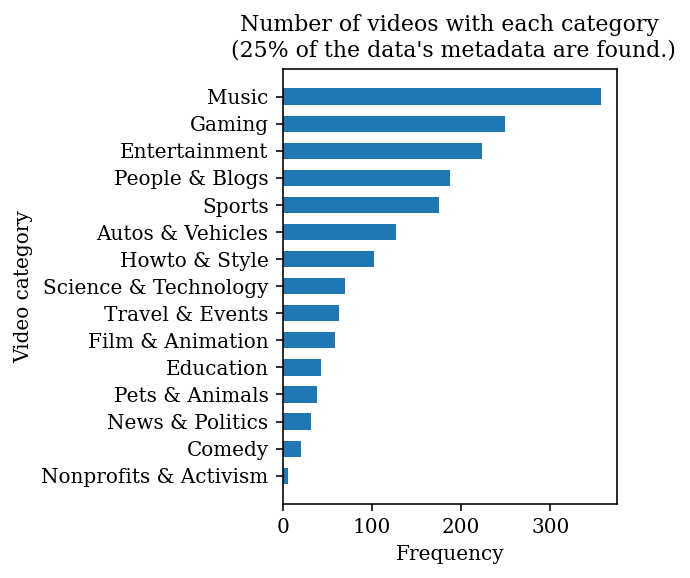

In [42]:
category_count = video_info_noNAN.categories.value_counts()
fig = plt.figure(figsize=(3,4))
n_cat = len(category_count)
x =  -1*np.arange(0,n_cat,1)
category_names = category_count.index
plt.barh(x,category_count.values,height=0.6)
plt.yticks(x,category_names)
plt.ylabel("Video category",fontsize=10)
plt.xlabel("Frequency",fontsize=10)
plt.title("Number of videos with each category\n (25% of the data's metadata are found.)",fontsize=11)
plt.savefig("plots/video_category.png",bbox_inches = 'tight')
plt.show()

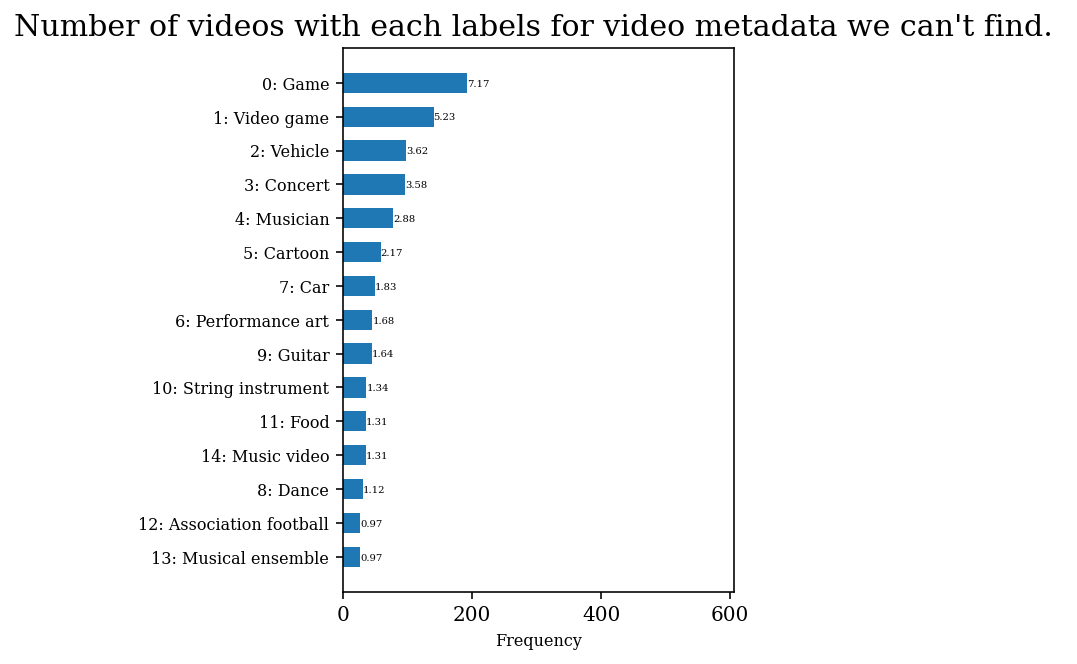

In [36]:
# video labels within for the videos whose metadata can not be found.
video_info_NAN = video_info.loc[video_info.real_id.isna()]
count_df_na = prepare_hist(video_info_NAN ,15)

fig = plt.figure(figsize=(3.5,5))
x =  -1*np.arange(0,topN,1)
barplot = plt.barh(x,count_df_na.counts,height=0.6)
# annotate each label with percentage
for i in range(topN):
    plt.annotate(round(count_df_na.percent_video[i]*100,2),(count_df_na.counts[i],x[i]-0.1),fontsize=5)
plt.yticks(x,count_df_na.label,fontsize=8)#,rotation=90)
plt.xlabel("Frequency",fontsize=8)
plt.xlim(0,np.max(count_df.counts)*1.1)
plt.title("Number of videos with each labels for video metadata we can't find. ",fontsize=15)
plt.show()

### Median popularity if a video contains label x

In [ ]:
# for each video check if a label is in the ground truth (up to 500)
labels= np.arange(0,3800,1)
if_label = np.zeros((len(video_info_noNAN),500))
for i in labels[:500]:
    if_label[:,i] = video_info_noNAN.labels.apply(lambda x: i in x).values

col_names = ["contain_"+str(i) for i in labels[:500]]
if_label_df = pd.DataFrame(if_label,columns = col_names)

video_info_noNAN = video_info_noNAN.copy()
video_info_noNAN = pd.concat([video_info_noNAN,if_label_df],axis=1)
video_info_noNAN.head()
view_med_by_lab = [ video_info_noNAN.loc[video_info_noNAN["contain_"+str(i)]==1,"view_count"].median() for i in range(500)]

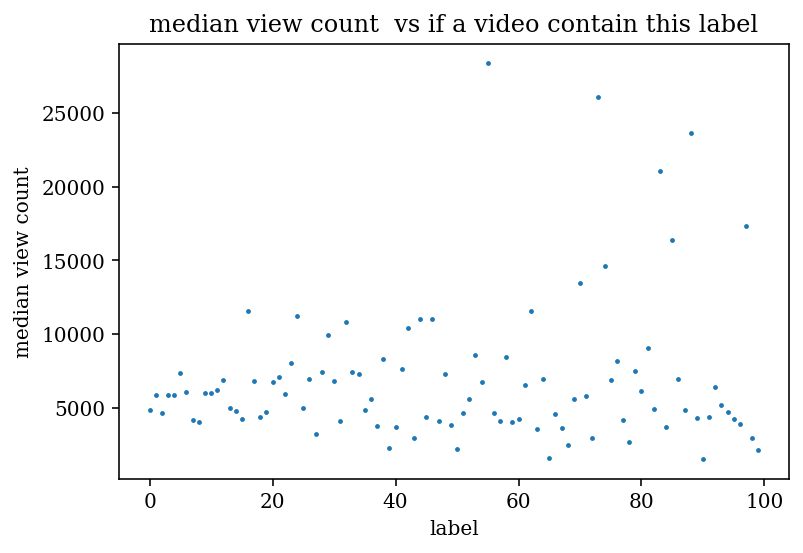

In [57]:
plt.scatter(np.arange(0,100,1),view_med_by_lab[:100],s=2)
plt.xlabel("label")
plt.ylabel("median view count")
plt.title("median view count  vs if a video contain this label")
plt.show()

#### word cloud for most popular video

In [59]:
def prepare_wordCloud(dfi,view_count_bound=500000):
    # for video with than 500000 views, get all their labels
    # prepare word cloud
    dfi = dfi.loc[dfi.view_count >view_count_bound,]
    wordCloud_index= np.concatenate(dfi.labels.values)
    label_map = dict(zip(label_dict.Index, label_dict.Name))
    label_name = list(map(label_map.get, wordCloud_index)) 
    label_name = list(map(str,label_name))
    label_name = np.array(label_name)[[i !="nan" for i in label_name]]
    wordCloud_words = " ".join(label_name)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(wordCloud_words)
    return wordcloud


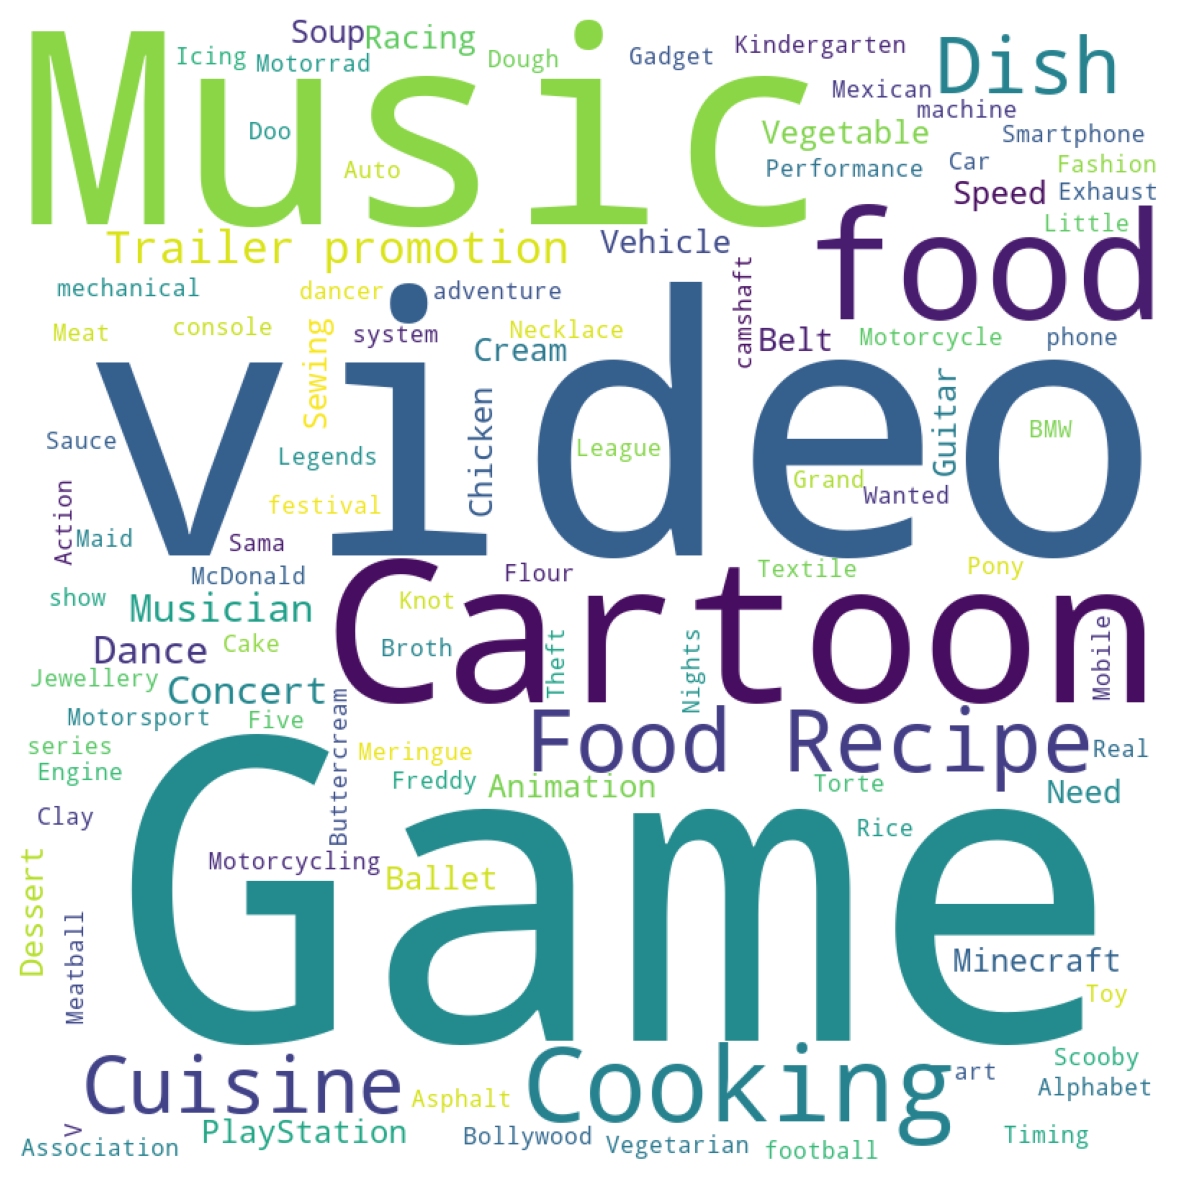

In [60]:

# sort video with view_count from top 
video_info_noNAN = video_info_noNAN.copy()
video_info_noNAN.sort_values(by=["view_count"],ascending=False,inplace=True)

wordcloud =prepare_wordCloud(video_info_noNAN)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig("plots/wordCloud_eda.png")
plt.show()

##### Numbers of labels associated with each vertical category in vocabulary dictionary

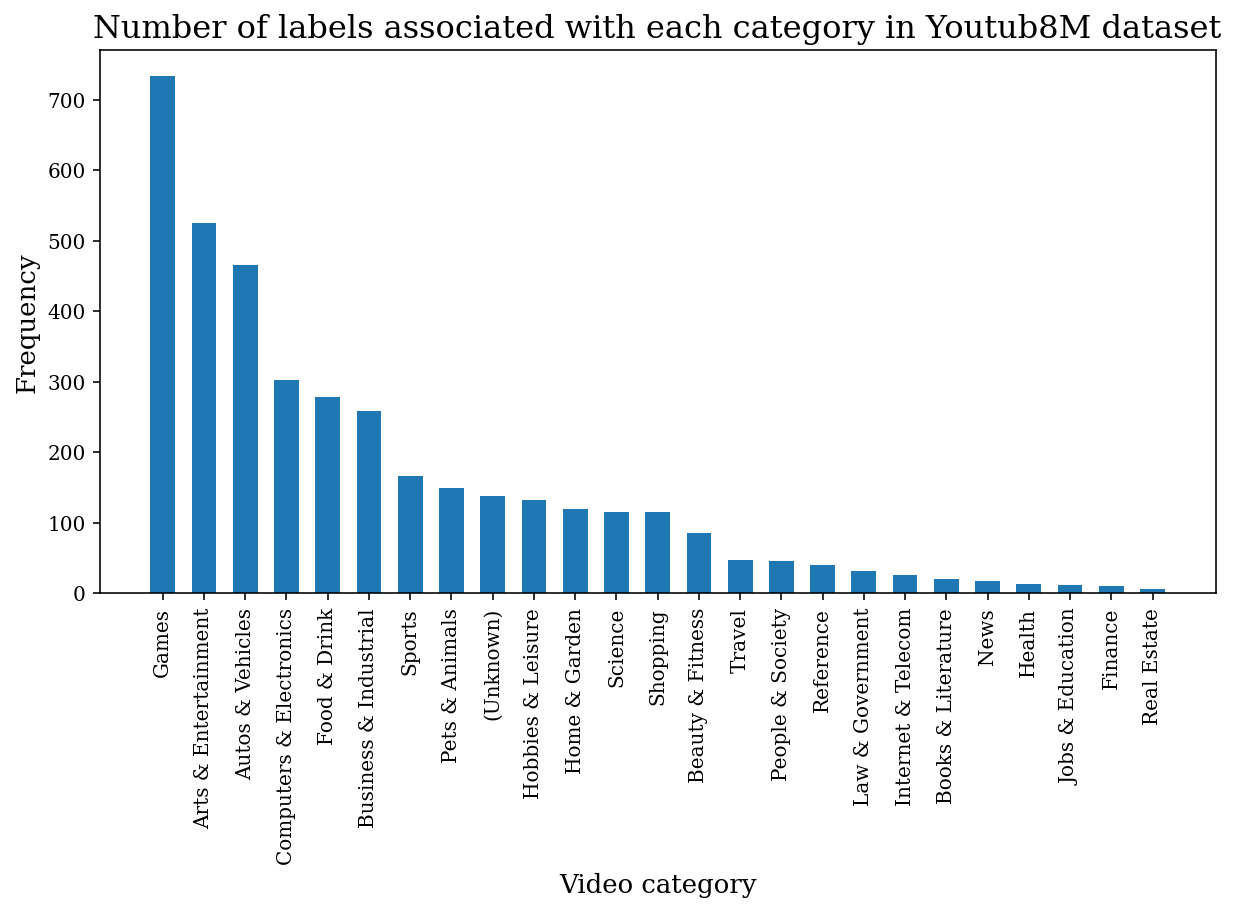

In [224]:
label_cat_count = label_dict.groupby(['Vertical1'])['Index'].count()

fig = plt.figure(figsize=(10,5))
n_cat = len(label_cat_count)
x =  np.arange(0,n_cat,1)

category_names = label_cat_count.index[np.argsort(label_cat_count.values)[::-1]]
plt.bar(x,np.sort(label_cat_count.values)[::-1],width=0.6)
plt.xticks(x,category_names,rotation=90)
plt.xlabel("Video category",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.title("Number of labels associated with each category in Youtub8M dataset",fontsize=16)
plt.show()


In [ ]:
# colors = plt.cm.rainbow(np.linspace(0, 1, n))
# mean_rgb_top_n = []
# labels_for_tsne = []
# # filtering mean_rgb so it only contains top n labels
# for idx, list_of_nodes in enumerate(labels):
#     for node in list_of_nodes:
#         if node in top_n_labels:
#             mean_rgb_top_n.append(mean_rgb[idx])
#             labels_for_tsne.append(node)


# X_embedded = TSNE(n_components=2, random_state=0).fit_transform(mean_rgb_top_n) 


# fig = plt.figure()
# ax = fig.add_subplot(111)

# handles = []
# for indx, color in enumerate(colors):
#     this_label = top_n_labels[indx]
#     X_embedded_filtered = X_embedded[np.array([x==this_label for x in labels_for_tsne])]
#     handles.append(ax.scatter(X_embedded_filtered[:, 0], X_embedded_filtered[:, 1], c=color, marker="o",edgecolor='none'))

# ax.legend(handles, top_n_labels)

# plt.show()